# HeartGuard: ECG-Based Cardiovascular Risk Prediction System

## A Comprehensive AI System for Cardiac Risk Assessment

This notebook implements a complete cardiovascular risk prediction system using the PTB-XL dataset - the largest publicly available 12-lead ECG dataset with 21,799 clinical recordings.

### What This System Does:
1. **Analyzes ECG signals** - Processes 12-lead ECG recordings to detect cardiac abnormalities
2. **Predicts cardiac risk** - Uses machine learning to classify patients into risk categories
3. **Explains predictions** - Shows which ECG features drive the risk assessment
4. **Recommends interventions** - Provides personalized clinical recommendations

### Key Components:
- Deep learning models (CNN, CNN-LSTM) for ECG analysis
- Traditional ML (XGBoost) for comparison
- SHAP and GradCAM for model explainability
- Clinical intervention recommendation engine

---

# Section 1: Setup and Configuration

## What we're doing here:
This section sets up our working environment by:
1. **Installing required packages** - Libraries for ECG processing, machine learning, and visualization
2. **Importing all dependencies** - Loading the tools we'll use throughout
3. **Verifying GPU availability** - Ensuring we can use GPU acceleration for deep learning
4. **Setting up configuration** - Defining paths, hyperparameters, and constants

### Why this matters:
A proper setup ensures reproducibility and optimal performance. GPU acceleration is critical for training deep learning models efficiently on our RTX 3060 Ti.

In [ ]:
# Standard library
import os
import ast
import warnings
from datetime import datetime
from collections import Counter

# Data handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# ECG file reading
import wfdb

# Signal processing
from scipy import signal
from scipy.stats import skew, kurtosis
from scipy.interpolate import interp1d

# Machine Learning - Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_class_weight

# Machine Learning - Models and Metrics
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, auc, accuracy_score, f1_score
)

# XGBoost
import xgboost as xgb

# Deep Learning - PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Explainability
import shap

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_STATE)

print("✓ All imports successful!")

c:\Users\Gebriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ All imports successful!


In [ ]:
# CONFIGURATION DICTIONARY

# This dictionary contains all configurable parameters for the project.
# Centralizing configuration makes it easy to adjust settings and ensures
# consistency throughout the notebook.

CONFIG = {
    # Data paths
    'data_path': 'ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/',
    'output_path': 'outputs/',  # For saving models, figures, etc.
    
    # ECG signal parameters
    'sampling_rate': 500,       # Hz - samples per second
    'duration': 10,             # seconds - each ECG recording length
    'num_samples': 5000,        # sampling_rate * duration
    'num_leads': 12,            # Standard 12-lead ECG
    
    # Training parameters
    'batch_size': 64,           # Samples per training batch (fits in 8GB VRAM)
    'epochs': 50,               # Maximum training epochs
    'learning_rate': 0.001,     # Initial learning rate
    
    # Data split folds (predefined in PTB-XL)
    'train_folds': [1, 2, 3, 4, 5, 6, 7, 8],  # 80% of data
    'val_folds': [9],                          # 10% of data (high quality labels)
    'test_folds': [10],                        # 10% of data (human validated)
    
    # Reproducibility
    'random_state': 42,
    
    # Feature extraction
    'min_rr_interval': 300,     # ms - minimum RR interval (max 200 BPM)
    'max_rr_interval': 2000,    # ms - maximum RR interval (min 30 BPM)
}

# Create output directory if it doesn't exist
os.makedirs(CONFIG['output_path'], exist_ok=True)

print("Configuration Summary:")
print("-" * 40)
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

Configuration Summary:
----------------------------------------
  data_path: ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/
  output_path: outputs/
  sampling_rate: 500
  duration: 10
  num_samples: 5000
  num_leads: 12
  batch_size: 64
  epochs: 50
  learning_rate: 0.001
  train_folds: [1, 2, 3, 4, 5, 6, 7, 8]
  val_folds: [9]
  test_folds: [10]
  random_state: 42
  min_rr_interval: 300
  max_rr_interval: 2000


In [ ]:
# ECG LEAD NAMES

# Standard 12-lead ECG configuration:
# - Limb leads (I, II, III): Measure electrical activity in the frontal plane
# - Augmented leads (aVR, aVL, aVF): Enhanced views of the frontal plane
# - Precordial leads (V1-V6): Measure activity in the horizontal plane across the chest

LEAD_NAMES = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

# Clinical significance of each lead:
LEAD_INFO = {
    'I':    'Left arm to right arm - lateral wall',
    'II':   'Left leg to right arm - inferior wall (best for rhythm)',
    'III':  'Left leg to left arm - inferior wall',
    'aVR':  'Right arm augmented - cavity view',
    'aVL':  'Left arm augmented - lateral wall',
    'aVF':  'Left foot augmented - inferior wall',
    'V1':   'Right sternal border - septum/right ventricle',
    'V2':   'Left sternal border - septum',
    'V3':   'Between V2 and V4 - anterior wall',
    'V4':   'Apex - anterior wall',
    'V5':   'Anterior axillary line - lateral wall',
    'V6':   'Mid-axillary line - lateral wall'
}

print("12-Lead ECG Configuration:")
print("-" * 60)
for i, lead in enumerate(LEAD_NAMES):
    print(f"  Lead {i+1:2d} ({lead:>3}): {LEAD_INFO[lead]}")

12-Lead ECG Configuration:
------------------------------------------------------------
  Lead  1 (  I): Left arm to right arm - lateral wall
  Lead  2 ( II): Left leg to right arm - inferior wall (best for rhythm)
  Lead  3 (III): Left leg to left arm - inferior wall
  Lead  4 (aVR): Right arm augmented - cavity view
  Lead  5 (aVL): Left arm augmented - lateral wall
  Lead  6 (aVF): Left foot augmented - inferior wall
  Lead  7 ( V1): Right sternal border - septum/right ventricle
  Lead  8 ( V2): Left sternal border - septum
  Lead  9 ( V3): Between V2 and V4 - anterior wall
  Lead 10 ( V4): Apex - anterior wall
  Lead 11 ( V5): Anterior axillary line - lateral wall
  Lead 12 ( V6): Mid-axillary line - lateral wall


In [ ]:
# DIAGNOSTIC CODE CATEGORIES

# These categories are used later for risk scoring.
# Based on clinical significance of ECG findings.

# HIGH RISK: Conditions requiring immediate attention
HIGH_RISK_CODES = [
    # Myocardial Infarction variants
    'AMI',      # Anterior MI
    'IMI',      # Inferior MI
    'ASMI',     # Anteroseptal MI
    'ILMI',     # Inferolateral MI
    'LMI',      # Lateral MI
    'PMI',      # Posterior MI
    'ALMI',     # Anterolateral MI
    'IPMI',     # Inferoposterior MI
    'IPLMI',    # Inferoposterolateral MI
    # Dangerous arrhythmias
    'AFIB',     # Atrial fibrillation
    'AFLT',     # Atrial flutter
    # Severe conduction disease
    '3AVB',     # Third-degree AV block
    'CLBBB',    # Complete left bundle branch block
]

# MODERATE RISK: Conditions requiring monitoring/follow-up
MODERATE_RISK_CODES = [
    # Hypertrophy
    'LVH',      # Left ventricular hypertrophy
    'RVH',      # Right ventricular hypertrophy
    # Bundle branch blocks
    'CRBBB',    # Complete right bundle branch block
    'LAFB',     # Left anterior fascicular block
    'LPFB',     # Left posterior fascicular block
    # ST/T abnormalities
    'NST_',     # Non-specific ST changes
    'ISC_',     # Ischemic changes
    # Partial blocks
    '1AVB',     # First-degree AV block
    '2AVB',     # Second-degree AV block
    # Ectopy
    'PVC',      # Premature ventricular complexes
    'PAC',      # Premature atrial complexes
    'IVCD',     # Intraventricular conduction delay
]

# LOW RISK: Minor abnormalities, generally benign
LOW_RISK_CODES = [
    'SBRAD',    # Sinus bradycardia
    'STACH',    # Sinus tachycardia
    'SARRH',    # Sinus arrhythmia
    'SR',       # Sinus rhythm (normal)
    'IRBBB',    # Incomplete right bundle branch block
    'NDT',      # Non-diagnostic T abnormalities
]

print(f"Risk Code Categories:")
print(f"  High Risk:     {len(HIGH_RISK_CODES)} conditions")
print(f"  Moderate Risk: {len(MODERATE_RISK_CODES)} conditions")
print(f"  Low Risk:      {len(LOW_RISK_CODES)} conditions")

Risk Code Categories:
  High Risk:     13 conditions
  Moderate Risk: 12 conditions
  Low Risk:      6 conditions


In [ ]:
# VISUALIZATION SETTINGS

# Set consistent style for all matplotlib plots
plt.style.use('seaborn-v0_8-whitegrid')

# Custom color palette for risk categories
RISK_COLORS = {
    'Low': '#2ecc71',       # Green
    'Moderate': '#f39c12', # Orange  
    'High': '#e74c3c'       # Red
}

# Color palette for diagnostic superclasses
SUPERCLASS_COLORS = {
    'NORM': '#3498db',  # Blue
    'MI': '#e74c3c',    # Red
    'STTC': '#f39c12',  # Orange
    'CD': '#9b59b6',    # Purple
    'HYP': '#1abc9c'    # Teal
}

# Figure sizes
FIG_SIZES = {
    'small': (8, 6),
    'medium': (12, 8),
    'large': (16, 10),
    'ecg_12lead': (14, 12)
}

print("✓ Visualization settings configured")
print("\n" + "=" * 60)
print("SECTION 1 COMPLETE: Environment Ready!")
print("=" * 60)

✓ Visualization settings configured

SECTION 1 COMPLETE: Environment Ready!


# Section 2: Data Loading

## What we're doing here:
This section loads the PTB-XL dataset and prepares it for analysis:

1. **Load metadata** - Patient demographics, diagnoses, and file paths from CSV
2. **Parse diagnosis codes** - Convert string dictionaries to Python objects
3. **Load ECG signals** - Read waveform data from WFDB format files
4. **Examine data structure** - Understand what we're working with

### About PTB-XL:
- **21,799 clinical 12-lead ECGs** from 18,869 unique patients
- **10 seconds duration** at 500 Hz sampling rate (5000 samples per recording)
- **71 different diagnoses** organized into 5 superclasses
- **Hospital-grade quality** from Schiller AG devices

### Why this matters:
Understanding the data structure is essential before building models. We need to know the shape of ECG signals, the format of diagnoses, and how to handle missing values.

In [ ]:
# LOAD METADATA FUNCTION

def load_ptbxl_metadata(data_path):
    """
    Load PTB-XL metadata files.
    
    How it works:
    1. Loads the main database CSV containing patient info and file paths
    2. Parses the scp_codes column from string to dictionary
    3. Loads the SCP statements file that maps diagnosis codes to descriptions
    
    Parameters:
        data_path: Path to the PTB-XL dataset folder
        
    Returns:
        df: Main dataframe with ECG metadata
        scp_df: Dataframe with SCP code definitions
    """
    # Load main database
    df = pd.read_csv(
        os.path.join(data_path, 'ptbxl_database.csv'),
        index_col='ecg_id'  # Use ECG ID as index for easy lookup
    )
    
    # Parse scp_codes from string to dictionary
    # The CSV stores dictionaries as strings like "{'NORM': 100.0, 'SR': 0.0}"
    # We use ast.literal_eval to safely convert these to actual Python dicts
    df['scp_codes'] = df['scp_codes'].apply(ast.literal_eval)
    
    # Load SCP statements (diagnosis code definitions)
    scp_df = pd.read_csv(
        os.path.join(data_path, 'scp_statements.csv'),
        index_col=0  # Use the code as index
    )
    
    return df, scp_df

# Load the data
print("Loading PTB-XL metadata...")
df, scp_df = load_ptbxl_metadata(CONFIG['data_path'])
print(f"✓ Loaded {len(df)} ECG records")

Loading PTB-XL metadata...
✓ Loaded 21799 ECG records


In [ ]:
# EXAMINE METADATA STRUCTURE

print("=" * 60)
print("METADATA STRUCTURE")
print("=" * 60)

print("\nMain Database Columns:")
print("-" * 40)
for i, col in enumerate(df.columns):
    dtype = df[col].dtype
    non_null = df[col].notna().sum()
    print(f"  {i+1:2d}. {col:<25} ({dtype}, {non_null}/{len(df)} non-null)")

print(f"\nTotal: {len(df.columns)} columns")

print("\n" + "-" * 40)
print("Sample row:")
print(df.iloc[0])

METADATA STRUCTURE

Main Database Columns:
----------------------------------------
   1. patient_id                (float64, 21799/21799 non-null)
   2. age                       (float64, 21799/21799 non-null)
   3. sex                       (int64, 21799/21799 non-null)
   4. height                    (float64, 6974/21799 non-null)
   5. weight                    (float64, 9421/21799 non-null)
   6. nurse                     (float64, 20326/21799 non-null)
   7. site                      (float64, 21782/21799 non-null)
   8. device                    (object, 21799/21799 non-null)
   9. recording_date            (object, 21799/21799 non-null)
  10. report                    (object, 21799/21799 non-null)
  11. scp_codes                 (object, 21799/21799 non-null)
  12. heart_axis                (object, 13331/21799 non-null)
  13. infarction_stadium1       (object, 5612/21799 non-null)
  14. infarction_stadium2       (object, 103/21799 non-null)
  15. validated_by              (f

In [ ]:
# ECG LOADING FUNCTIONS

def load_ecg_waveform(filename, data_path):
    full_path = os.path.join(data_path, filename)
    record = wfdb.rdrecord(full_path)
    return record.p_signal  # Shape: (5000, 12)


def load_ecg_batch(df_subset, data_path, max_samples=None, verbose=True):
    if max_samples:
        df_subset = df_subset.head(max_samples)
    
    ecgs = []
    valid_indices = []
    errors = 0
    
    total = len(df_subset)
    for i, (idx, row) in enumerate(df_subset.iterrows()):
        try:
            ecg = load_ecg_waveform(row['filename_hr'], data_path)
            ecgs.append(ecg)
            valid_indices.append(idx)
        except Exception as e:
            errors += 1
            if verbose and errors <= 3:
                print(f"  Warning: Could not load ECG {idx}: {e}")
    
        # Progress update
        if verbose and (i + 1) % 1000 == 0:
            print(f"  Loaded {i + 1}/{total} ECGs...")
    
    if verbose:
        print(f"  ✓ Successfully loaded {len(ecgs)}/{total} ECGs ({errors} errors)")
    
    return np.array(ecgs, dtype=np.float32), valid_indices


print("✓ ECG loading functions defined")

✓ ECG loading functions defined


In [ ]:
# TEST ECG LOADING WITH A SAMPLE

print("=" * 60)
print("TESTING ECG LOADING")
print("=" * 60)

# Load a single sample ECG to verify everything works
sample_idx = df.index[0]
sample_row = df.loc[sample_idx]

print(f"\nLoading sample ECG (ID: {sample_idx})...")
sample_ecg = load_ecg_waveform(sample_row['filename_hr'], CONFIG['data_path'])

print(f"\n📊 ECG Signal Properties:")
print(f"   Shape: {sample_ecg.shape}")
print(f"   Expected: ({CONFIG['num_samples']}, {CONFIG['num_leads']})")
print(f"   Data type: {sample_ecg.dtype}")
print(f"   Duration: {sample_ecg.shape[0] / CONFIG['sampling_rate']} seconds")

print(f"\n📈 Signal Statistics (across all leads):")
print(f"   Min value:  {sample_ecg.min():.2f} μV")
print(f"   Max value:  {sample_ecg.max():.2f} μV")
print(f"   Mean value: {sample_ecg.mean():.2f} μV")
print(f"   Std dev:    {sample_ecg.std():.2f} μV")

print(f"\n👤 Patient Info for this ECG:")
print(f"   Patient ID: {sample_row['patient_id']:.0f}")
print(f"   Age: {sample_row['age']:.0f} years")
print(f"   Sex: {'Female' if sample_row['sex'] == 1 else 'Male'}")
print(f"   Diagnoses: {list(sample_row['scp_codes'].keys())}")

TESTING ECG LOADING

Loading sample ECG (ID: 1)...

📊 ECG Signal Properties:
   Shape: (5000, 12)
   Expected: (5000, 12)
   Data type: float64
   Duration: 10.0 seconds

📈 Signal Statistics (across all leads):
   Min value:  -1.44 μV
   Max value:  0.69 μV
   Mean value: 0.00 μV
   Std dev:    0.11 μV

👤 Patient Info for this ECG:
   Patient ID: 15709
   Age: 56 years
   Sex: Female
   Diagnoses: ['NORM', 'LVOLT', 'SR']


In [ ]:
# DATA SPLIT (FOLD) DISTRIBUTION
fold_counts = df['strat_fold'].value_counts().sort_index()

print("\n📊 Records per Fold:")
for fold, count in fold_counts.items():
    role = "TRAIN" if fold <= 8 else ("VAL" if fold == 9 else "TEST")
    print(f"   Fold {fold:2d}: {count:,} records ({role})")

# Calculate split sizes
train_size = df[df['strat_fold'].isin(CONFIG['train_folds'])].shape[0]
val_size = df[df['strat_fold'].isin(CONFIG['val_folds'])].shape[0]
test_size = df[df['strat_fold'].isin(CONFIG['test_folds'])].shape[0]

print(f"\n📈 Split Summary:")
print(f"   Training:   {train_size:,} ({100*train_size/len(df):.1f}%)")
print(f"   Validation: {val_size:,} ({100*val_size/len(df):.1f}%)")
print(f"   Test:       {test_size:,} ({100*test_size/len(df):.1f}%)")

print("\n✓ Patient-stratified split ensures no data leakage between splits")
print("=" * 60)


📊 Records per Fold:
   Fold  1: 2,175 records (TRAIN)
   Fold  2: 2,181 records (TRAIN)
   Fold  3: 2,192 records (TRAIN)
   Fold  4: 2,174 records (TRAIN)
   Fold  5: 2,174 records (TRAIN)
   Fold  6: 2,173 records (TRAIN)
   Fold  7: 2,176 records (TRAIN)
   Fold  8: 2,173 records (TRAIN)
   Fold  9: 2,183 records (VAL)
   Fold 10: 2,198 records (TEST)

📈 Split Summary:
   Training:   17,418 (79.9%)
   Validation: 2,183 (10.0%)
   Test:       2,198 (10.1%)

✓ Patient-stratified split ensures no data leakage between splits


# Section 3: Exploratory Data Analysis (EDA)

## What we're doing here:
This section explores and visualizes the dataset to understand:

1. **Demographics** - Age, sex, and BMI distributions
2. **Diagnosis patterns** - Which conditions are most common
3. **ECG signals** - What normal and abnormal ECGs look like
4. **Signal quality** - Understanding noise and artifacts

### Why this matters:
- Visualizing data helps identify patterns and anomalies
- Understanding class distributions guides our modeling strategy
- Seeing actual ECG waveforms builds clinical intuition
- Quality analysis informs preprocessing decisions

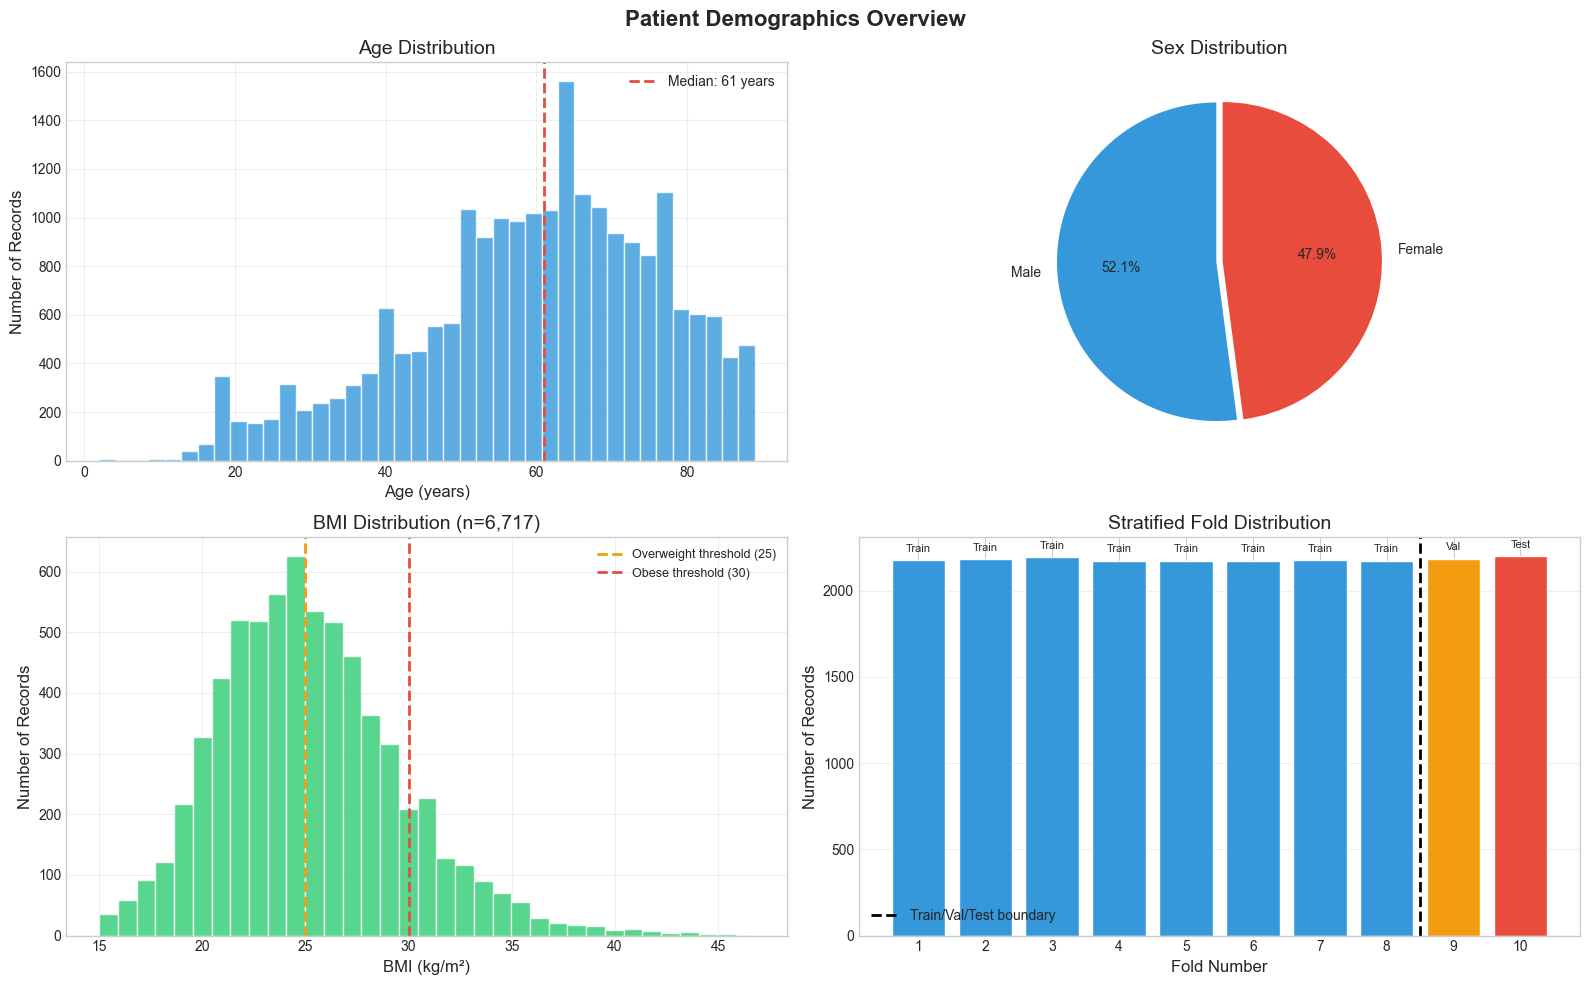

✓ Demographics visualization saved to outputs/demographics.png


In [11]:
# Create a 2x2 subplot for demographics
fig, axes = plt.subplots(2, 2, figsize=FIG_SIZES['large'])
fig.suptitle('Patient Demographics Overview', fontsize=16, fontweight='bold')

# 1. Age Distribution (filtering out HIPAA-masked values > 100)
ax1 = axes[0, 0]
age_valid = df[df['age'] <= 100]['age']
ax1.hist(age_valid, bins=40, color='#3498db', edgecolor='white', alpha=0.8)
ax1.axvline(age_valid.median(), color='#e74c3c', linestyle='--', linewidth=2, 
            label=f'Median: {age_valid.median():.0f} years')
ax1.set_xlabel('Age (years)', fontsize=12)
ax1.set_ylabel('Number of Records', fontsize=12)
ax1.set_title('Age Distribution', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Sex Distribution (Pie Chart)
ax2 = axes[0, 1]
sex_counts = df['sex'].value_counts()
sex_labels = ['Male', 'Female']
sex_colors = ['#3498db', '#e74c3c']
wedges, texts, autotexts = ax2.pie(
    sex_counts.values, 
    labels=sex_labels,
    colors=sex_colors,
    autopct='%1.1f%%',
    startangle=90,
    explode=(0.02, 0.02)
)
ax2.set_title('Sex Distribution', fontsize=14)

# 3. BMI Distribution (calculate from height/weight)
ax3 = axes[1, 0]
# Calculate BMI where both height and weight are available
mask = df['height'].notna() & df['weight'].notna()
bmi = df.loc[mask, 'weight'] / ((df.loc[mask, 'height'] / 100) ** 2)
# Filter to reasonable BMI range (15-50)
bmi_valid = bmi[(bmi >= 15) & (bmi <= 50)]
ax3.hist(bmi_valid, bins=35, color='#2ecc71', edgecolor='white', alpha=0.8)
ax3.axvline(25, color='#f39c12', linestyle='--', linewidth=2, label='Overweight threshold (25)')
ax3.axvline(30, color='#e74c3c', linestyle='--', linewidth=2, label='Obese threshold (30)')
ax3.set_xlabel('BMI (kg/m²)', fontsize=12)
ax3.set_ylabel('Number of Records', fontsize=12)
ax3.set_title(f'BMI Distribution (n={len(bmi_valid):,})', fontsize=14)
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3)

# 4. Stratified Fold Distribution
ax4 = axes[1, 1]
fold_counts = df['strat_fold'].value_counts().sort_index()
colors = ['#3498db'] * 8 + ['#f39c12', '#e74c3c']  # Blue for train, orange for val, red for test
bars = ax4.bar(fold_counts.index, fold_counts.values, color=colors, edgecolor='white')
ax4.axvline(8.5, color='black', linestyle='--', linewidth=2, label='Train/Val/Test boundary')
ax4.set_xlabel('Fold Number', fontsize=12)
ax4.set_ylabel('Number of Records', fontsize=12)
ax4.set_title('Stratified Fold Distribution', fontsize=14)
ax4.set_xticks(range(1, 11))
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

# Add labels for split assignment
for i, (fold, count) in enumerate(fold_counts.items()):
    label = 'Train' if fold <= 8 else ('Val' if fold == 9 else 'Test')
    ax4.annotate(label, (fold, count + 50), ha='center', fontsize=8)

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['output_path'], 'demographics.png'), dpi=150, bbox_inches='tight')
plt.show()

print("✓ Demographics visualization saved to outputs/demographics.png")

In [12]:
def get_diagnostic_superclass(scp_codes, scp_df):
    superclasses = []
    for code in scp_codes.keys():
        if code in scp_df.index:
            sc = scp_df.loc[code, 'diagnostic_class']
            if pd.notna(sc):
                superclasses.append(sc)
    return list(set(superclasses))

# Apply to create diagnostic_superclass column
print("Extracting diagnostic superclasses...")
df['diagnostic_superclass'] = df['scp_codes'].apply(
    lambda x: get_diagnostic_superclass(x, scp_df)
)

# Count occurrences of each superclass
# Note: Sum exceeds total records because ECGs can have multiple labels
superclass_counts = Counter()
for classes in df['diagnostic_superclass']:
    for sc in classes:
        superclass_counts[sc] += 1

print("\n📊 Diagnostic Superclass Distribution:")
print("-" * 50)
superclass_order = ['NORM', 'MI', 'STTC', 'CD', 'HYP']
for sc in superclass_order:
    count = superclass_counts.get(sc, 0)
    pct = 100 * count / len(df)
    print(f"   {sc:5}: {count:,} records ({pct:.1f}%)")

print(f"\n   Note: Total exceeds 100% because ECGs can have multiple diagnoses")
print(f"   Average labels per ECG: {sum(superclass_counts.values()) / len(df):.2f}")

Extracting diagnostic superclasses...

📊 Diagnostic Superclass Distribution:
--------------------------------------------------
   NORM : 9,514 records (43.6%)
   MI   : 5,469 records (25.1%)
   STTC : 5,235 records (24.0%)
   CD   : 4,898 records (22.5%)
   HYP  : 2,649 records (12.2%)

   Note: Total exceeds 100% because ECGs can have multiple diagnoses
   Average labels per ECG: 1.27


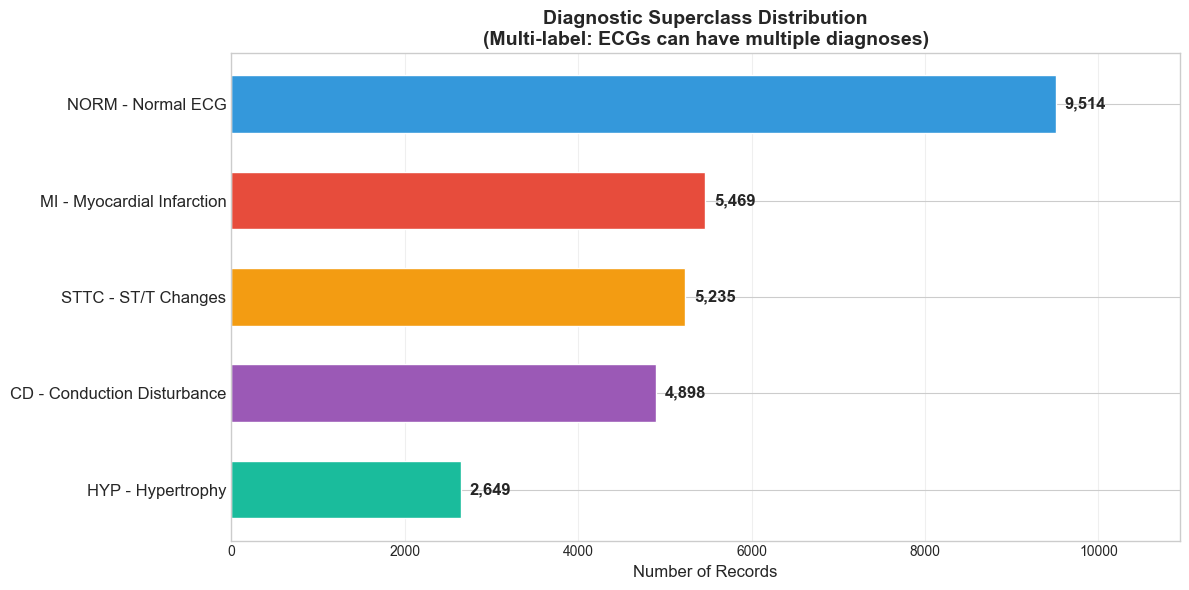

✓ Diagnosis distribution saved to outputs/diagnosis_distribution.png


In [13]:
# Superclass descriptions for the legend
superclass_descriptions = {
    'NORM': 'Normal ECG',
    'MI': 'Myocardial Infarction',
    'STTC': 'ST/T Changes',
    'CD': 'Conduction Disturbance',
    'HYP': 'Hypertrophy'
}

fig, ax = plt.subplots(figsize=(12, 6))

# Create horizontal bar chart
y_pos = np.arange(len(superclass_order))
counts = [superclass_counts[sc] for sc in superclass_order]
colors = [SUPERCLASS_COLORS[sc] for sc in superclass_order]

bars = ax.barh(y_pos, counts, color=colors, edgecolor='white', height=0.6)

# Add count labels on bars
for i, (bar, count) in enumerate(zip(bars, counts)):
    ax.text(count + 100, bar.get_y() + bar.get_height()/2, 
            f'{count:,}', va='center', fontsize=12, fontweight='bold')

# Customize axes
ax.set_yticks(y_pos)
ax.set_yticklabels([f"{sc} - {superclass_descriptions[sc]}" for sc in superclass_order], fontsize=12)
ax.set_xlabel('Number of Records', fontsize=12)
ax.set_title('Diagnostic Superclass Distribution\n(Multi-label: ECGs can have multiple diagnoses)', 
             fontsize=14, fontweight='bold')
ax.set_xlim(0, max(counts) * 1.15)
ax.grid(True, alpha=0.3, axis='x')

# Invert y-axis to show NORM at top
ax.invert_yaxis()

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['output_path'], 'diagnosis_distribution.png'), dpi=150, bbox_inches='tight')
plt.show()

print("✓ Diagnosis distribution saved to outputs/diagnosis_distribution.png")

In [14]:
def plot_12lead_ecg(ecg_signal, title="12-Lead ECG", save_path=None):
    fig, axes = plt.subplots(6, 2, figsize=FIG_SIZES['ecg_12lead'])
    fig.suptitle(title, fontsize=14, fontweight='bold')
    
    # Time axis in seconds
    time = np.arange(ecg_signal.shape[0]) / CONFIG['sampling_rate']
    
    # Plot each lead
    for i, (ax, lead_name) in enumerate(zip(axes.flat, LEAD_NAMES)):
        ax.plot(time, ecg_signal[:, i], color='#2c3e50', linewidth=0.5)
        ax.set_ylabel(lead_name, fontsize=10, fontweight='bold', rotation=0, labelpad=20)
        ax.set_xlim(0, CONFIG['duration'])
        ax.grid(True, which='both', alpha=0.3)
        ax.set_axisbelow(True)
        
        # Only show x-label on bottom row
        if i >= 10:
            ax.set_xlabel('Time (seconds)', fontsize=10)
        else:
            ax.set_xticklabels([])
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"✓ Saved to {save_path}")
    
    plt.show()
    return fig

print("✓ ECG visualization function defined")

✓ ECG visualization function defined


✓ Saved to outputs/ecg_sample_NORM.png


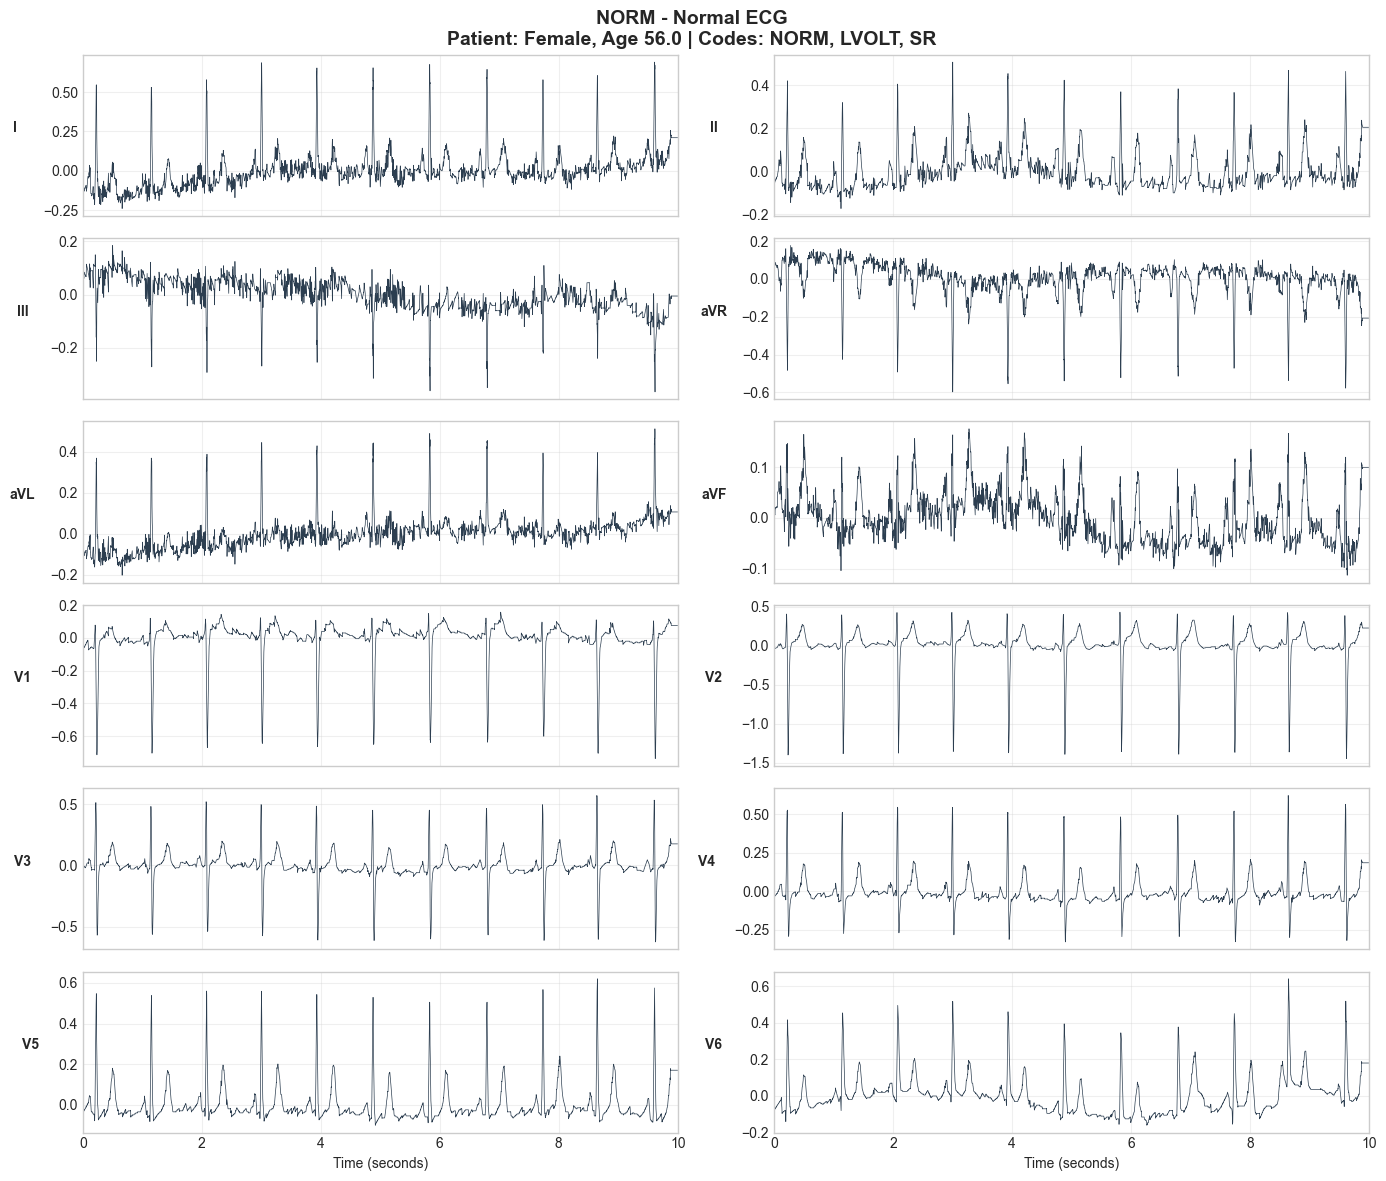


NORM: ECG ID 1
   Diagnoses: ['NORM', 'LVOLT', 'SR']
✓ Saved to outputs/ecg_sample_MI.png


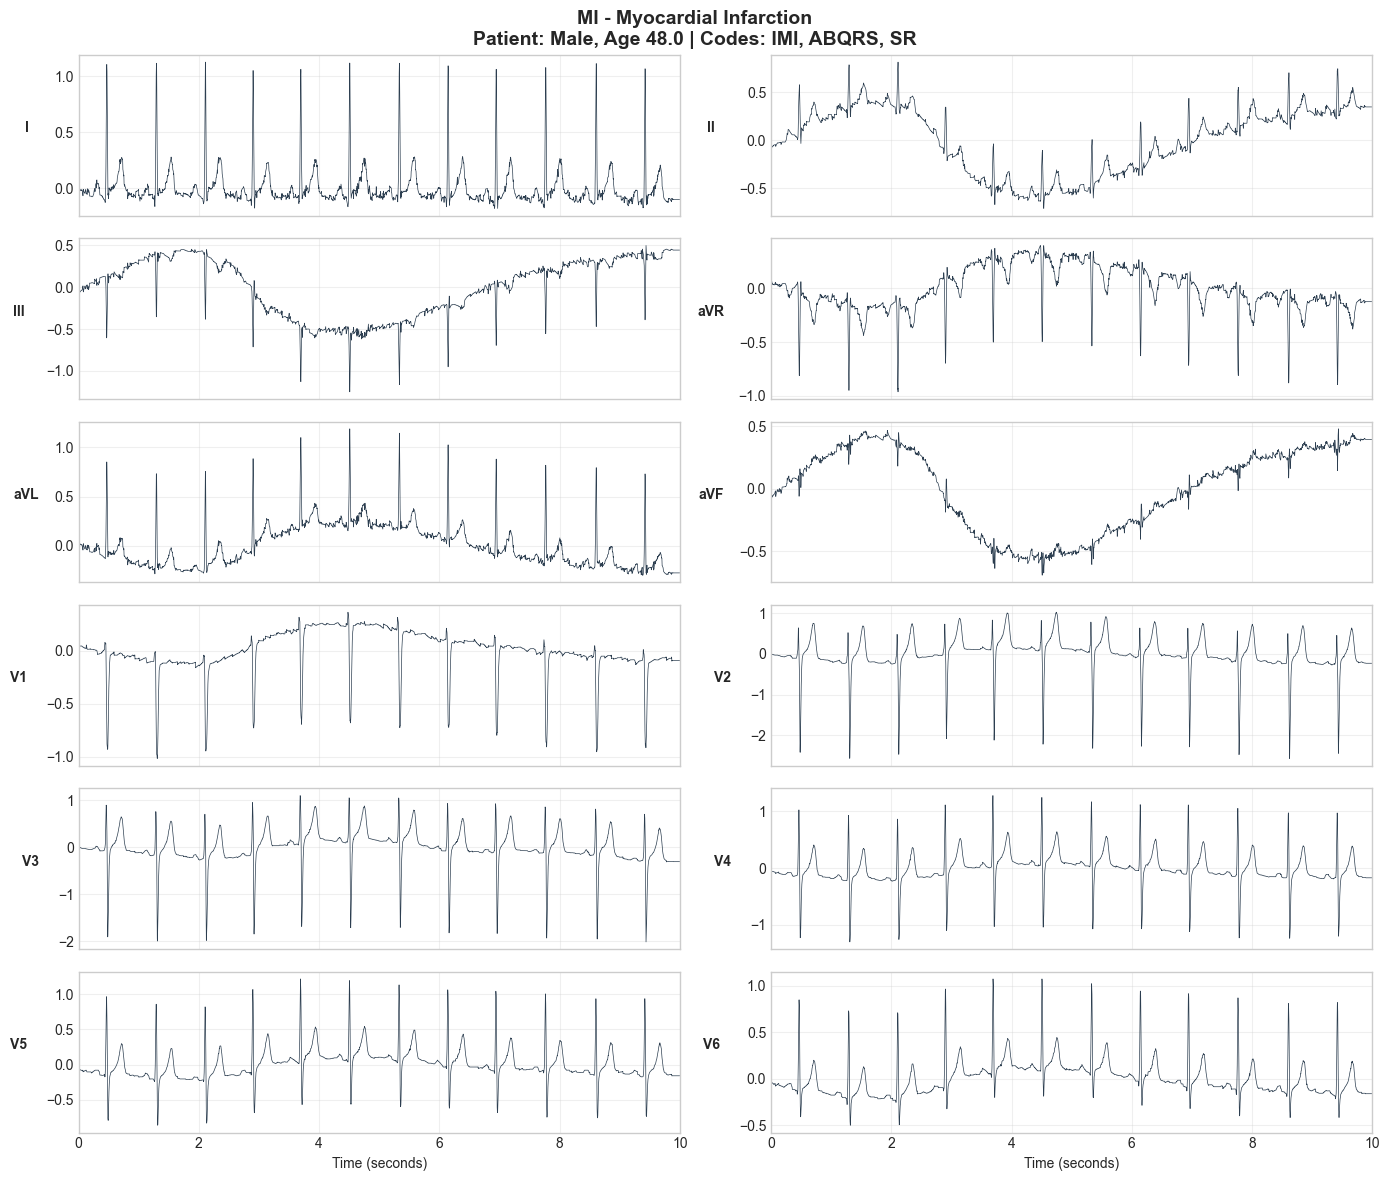


MI: ECG ID 8
   Diagnoses: ['IMI', 'ABQRS', 'SR']
✓ Saved to outputs/ecg_sample_STTC.png


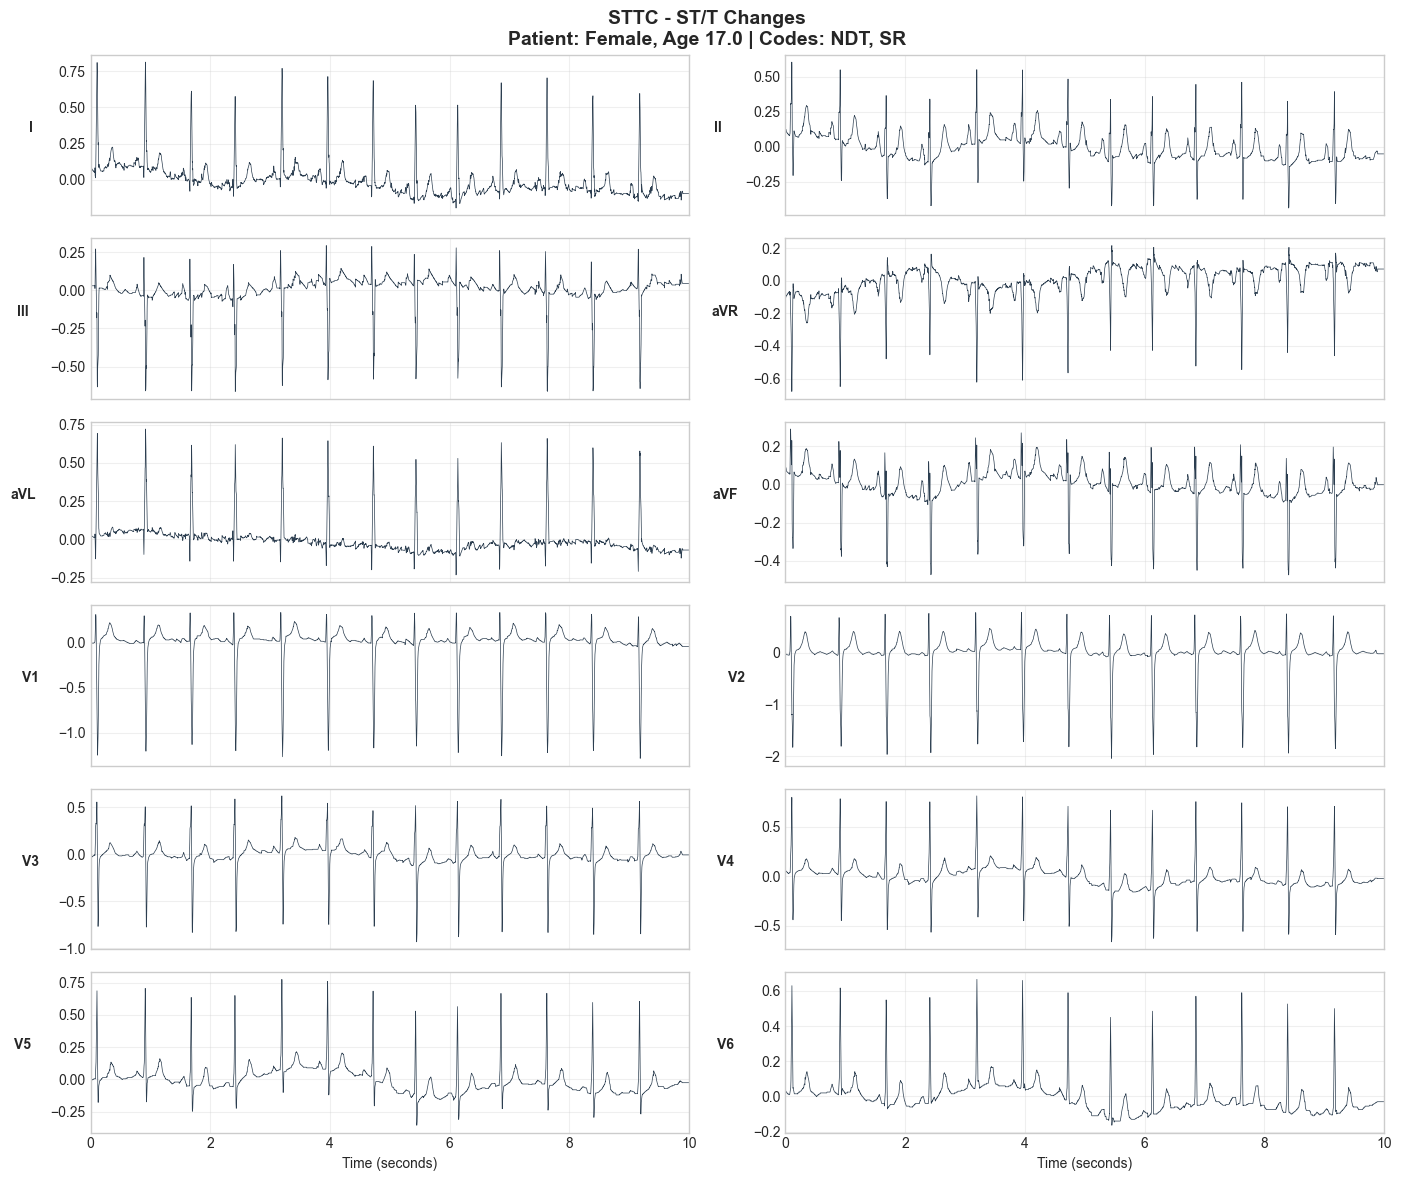


STTC: ECG ID 22
   Diagnoses: ['NDT', 'SR']
✓ Saved to outputs/ecg_sample_CD.png


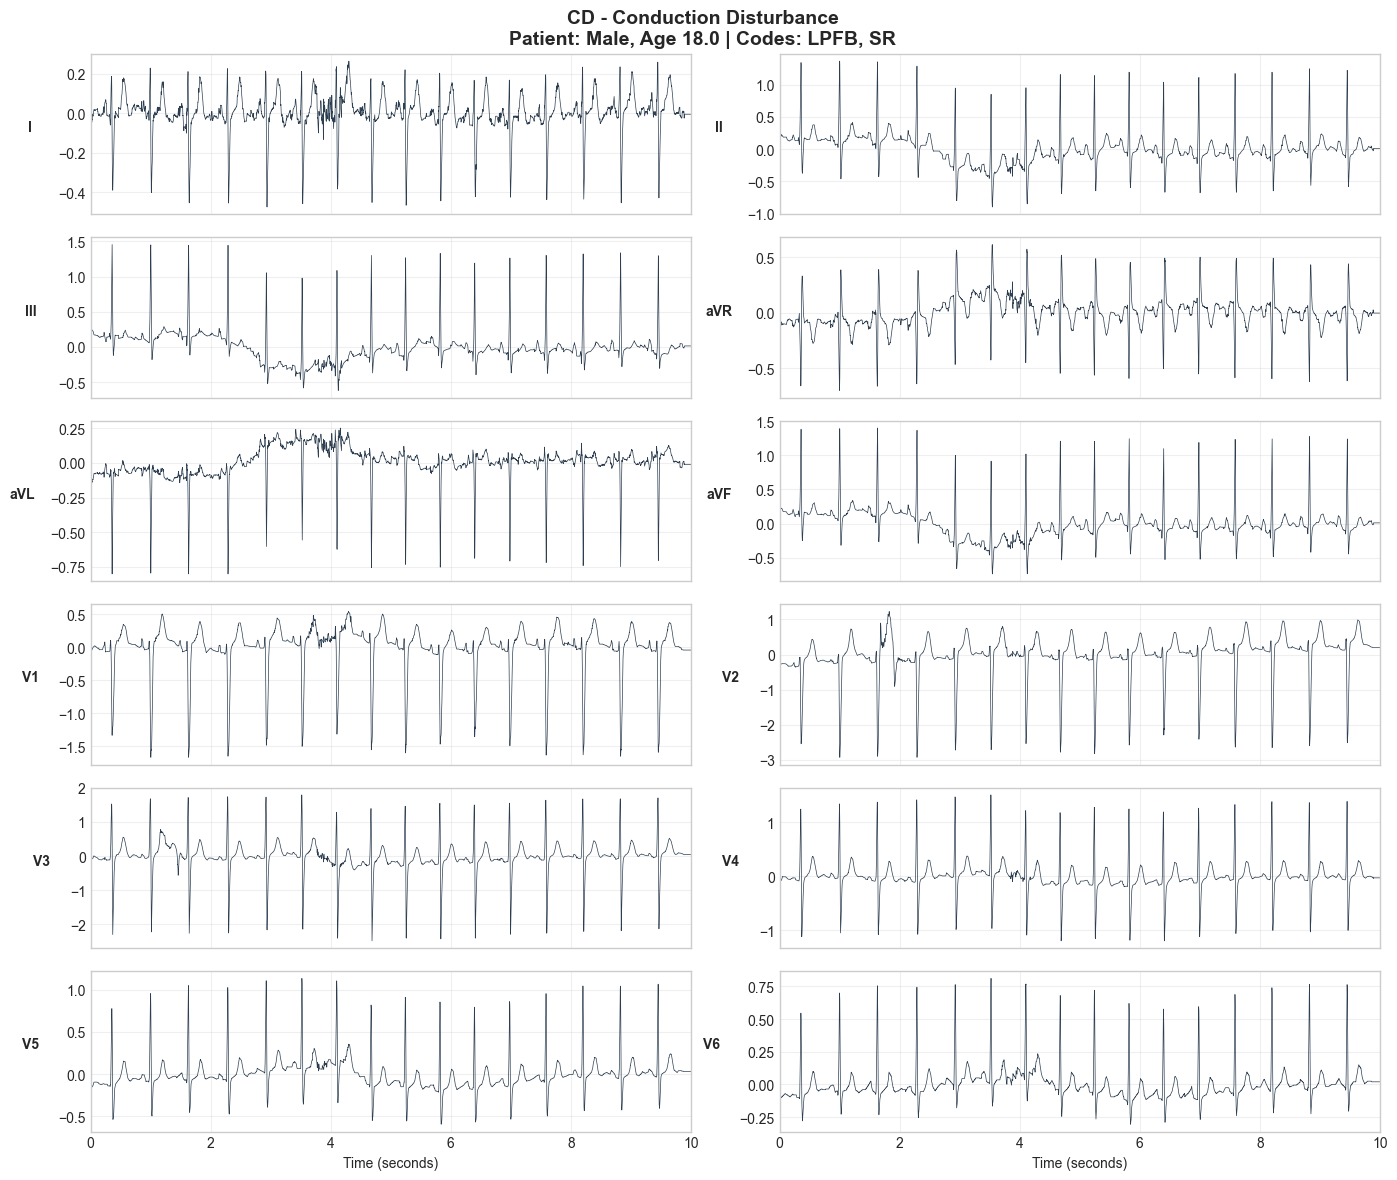


CD: ECG ID 32
   Diagnoses: ['LPFB', 'SR']
✓ Saved to outputs/ecg_sample_HYP.png


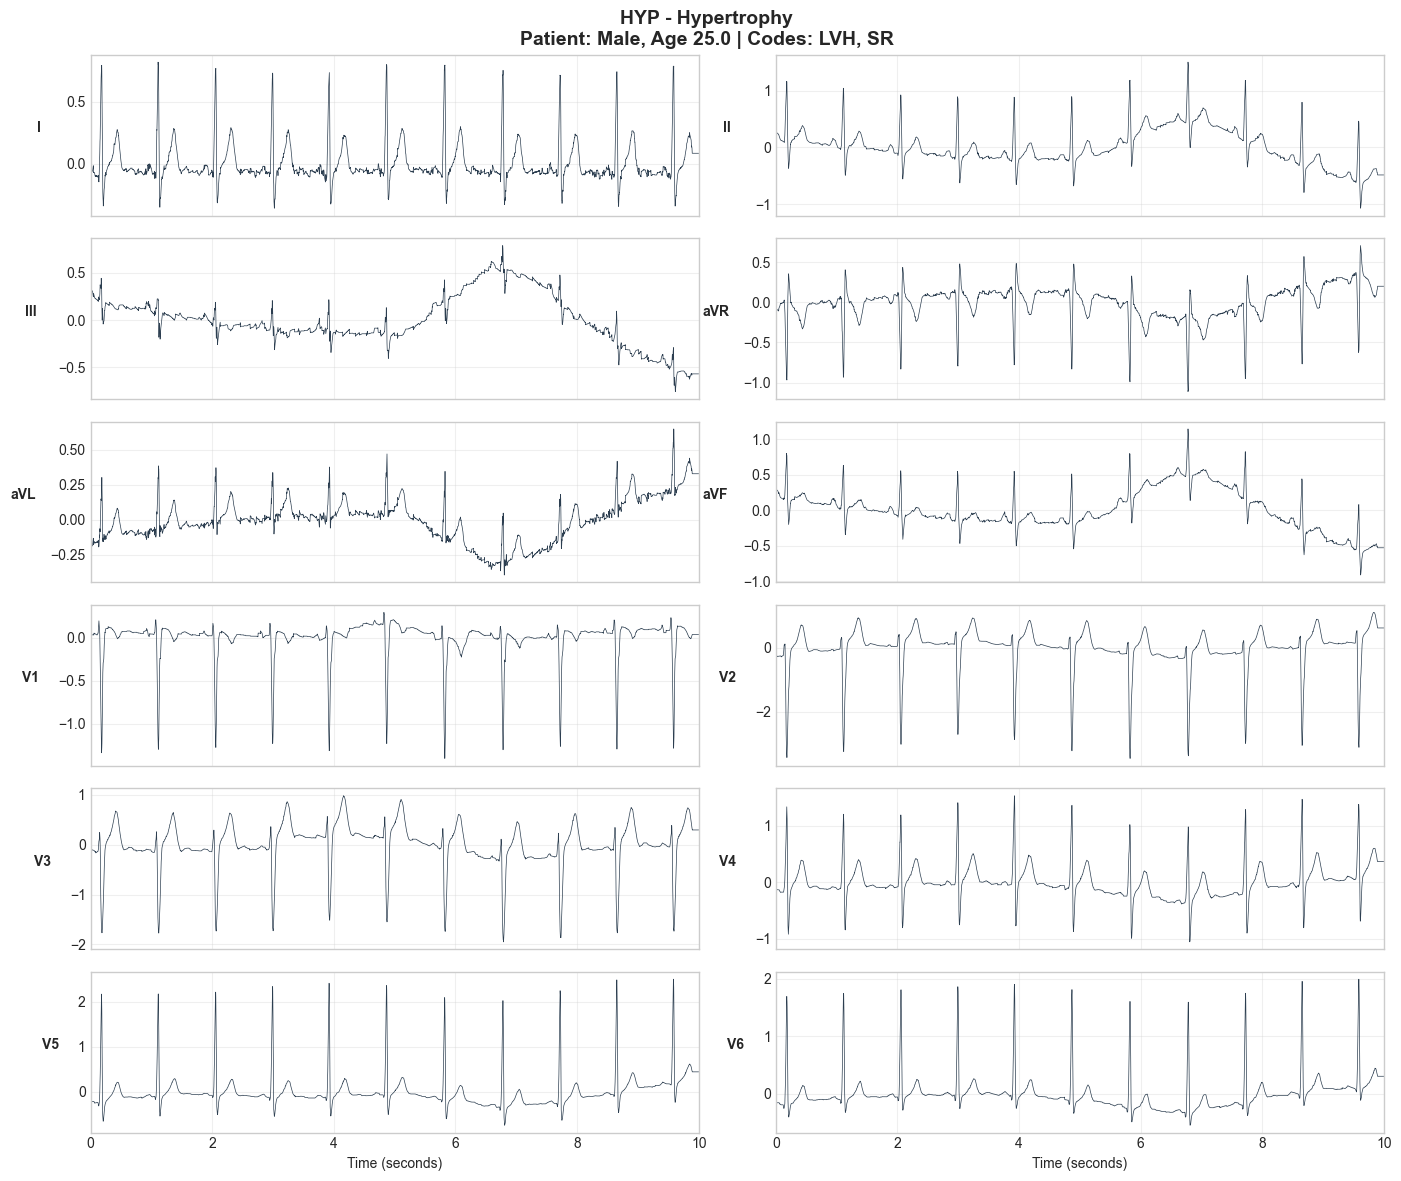


HYP: ECG ID 30
   Diagnoses: ['LVH', 'SR']

✓ Sample ECGs saved for all 5 diagnostic superclasses


In [15]:
for superclass in superclass_order:
    # Find first record containing this superclass
    for idx, row in df.iterrows():
        if superclass in row['diagnostic_superclass']:
            # Load ECG
            ecg = load_ecg_waveform(row['filename_hr'], CONFIG['data_path'])
            
            # Create title with patient info
            age = row['age'] if row['age'] <= 100 else '>89'
            sex = 'Female' if row['sex'] == 1 else 'Male'
            codes = list(row['scp_codes'].keys())[:5]  # Show up to 5 codes
            
            title = f"{superclass} - {superclass_descriptions[superclass]}\n"
            title += f"Patient: {sex}, Age {age} | Codes: {', '.join(codes)}"
            
            # Plot and save
            save_path = os.path.join(CONFIG['output_path'], f'ecg_sample_{superclass}.png')
            plot_12lead_ecg(ecg, title=title, save_path=save_path)
            
            print(f"\n{superclass}: ECG ID {idx}")
            print(f"   Diagnoses: {codes}")
            break

print("\n✓ Sample ECGs saved for all 5 diagnostic superclasses")

In [16]:
# Quality-related columns
quality_cols = ['baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems']

print("\n📊 Signal Quality Issues:")
print("-" * 50)

# Count records with quality issues (non-null means issue present)
for col in quality_cols:
    issue_count = df[col].notna().sum()
    pct = 100 * issue_count / len(df)
    print(f"   {col:20}: {issue_count:,} records ({pct:.1f}%)")

# Extra beats and pacemaker
print("\n📊 Special Conditions:")
print("-" * 50)

# Extra beats (count non-null and non-empty)
extra_beats_count = df['extra_beats'].notna().sum()
print(f"   Extra beats noted:   {extra_beats_count:,} ({100*extra_beats_count/len(df):.1f}%)")

# Pacemaker
pacemaker_count = df['pacemaker'].notna().sum()
print(f"   Pacemaker detected:  {pacemaker_count:,} ({100*pacemaker_count/len(df):.1f}%)")

print("\n✓ Signal Quality Summary:")
print("   PTB-XL signals are hospital-grade and relatively clean.")
print("   Most quality issues affect only specific leads, not entire recordings.")
print("   Light preprocessing is sufficient for most analyses.")


📊 Signal Quality Issues:
--------------------------------------------------
   baseline_drift      : 1,598 records (7.3%)
   static_noise        : 3,260 records (15.0%)
   burst_noise         : 613 records (2.8%)
   electrodes_problems : 30 records (0.1%)

📊 Special Conditions:
--------------------------------------------------
   Extra beats noted:   1,949 (8.9%)
   Pacemaker detected:  291 (1.3%)

✓ Signal Quality Summary:
   PTB-XL signals are hospital-grade and relatively clean.
   Most quality issues affect only specific leads, not entire recordings.
   Light preprocessing is sufficient for most analyses.


# Section 4: Label Engineering

## What we're doing here:
This section creates prediction targets (labels) from the diagnostic codes:

1. **ECG Risk Score (0-3)** - Based on severity of ECG findings
2. **Age Risk Factor** - Cardiovascular risk increases with age
3. **Composite Risk Score** - Combined ECG + demographic factors
4. **Binary Target** - Simplified high-risk vs. low-risk classification

### Why this matters:
- Raw diagnosis codes are complex (71 different codes, multi-label)
- Clinical risk stratification requires synthesizing multiple factors
- Our models need well-defined targets to predict
- Different scoring approaches enable different model comparisons

### Clinical rationale:
Risk scores are based on established cardiology guidelines:
- **High risk**: Myocardial infarction, dangerous arrhythmias, severe conduction blocks
- **Moderate risk**: Hypertrophy, bundle branch blocks, ischemic changes
- **Low risk**: Minor rate variations, benign findings

In [17]:
def calculate_ecg_risk_score(scp_codes):
    codes = set(scp_codes.keys())
    
    # Check for high-risk conditions
    if any(code in codes for code in HIGH_RISK_CODES):
        return 3
    
    # Check for moderate-risk conditions
    if any(code in codes for code in MODERATE_RISK_CODES):
        return 2
    
    # Check for low-risk conditions
    if any(code in codes for code in LOW_RISK_CODES):
        return 1
    
    # Normal or no significant findings
    return 0

# Apply to create ecg_risk_score column
print("Calculating ECG risk scores...")
df['ecg_risk_score'] = df['scp_codes'].apply(calculate_ecg_risk_score)

# Display distribution
print("\n📊 ECG Risk Score Distribution:")
print("-" * 50)
risk_counts = df['ecg_risk_score'].value_counts().sort_index()
risk_labels = {0: 'Normal (0)', 1: 'Low Risk (1)', 2: 'Moderate Risk (2)', 3: 'High Risk (3)'}
for score, count in risk_counts.items():
    pct = 100 * count / len(df)
    print(f"   {risk_labels[score]:20}: {count:,} ({pct:.1f}%)")

Calculating ECG risk scores...

📊 ECG Risk Score Distribution:
--------------------------------------------------
   Normal (0)          : 547 (2.5%)
   Low Risk (1)        : 10,764 (49.4%)
   Moderate Risk (2)   : 3,784 (17.4%)
   High Risk (3)       : 6,704 (30.8%)


In [18]:
def calculate_age_risk(age):
    if pd.isna(age) or age > 100:  # Handle HIPAA-masked values
        return 1  # Default to moderate
    
    if age >= 75:
        return 3
    elif age >= 65:
        return 2
    elif age >= 55:
        return 1
    else:
        return 0

# Apply to create age_risk column
df['age_risk'] = df['age'].apply(calculate_age_risk)

print("📊 Age Risk Distribution:")
print("-" * 50)
age_risk_counts = df['age_risk'].value_counts().sort_index()
age_labels = {0: '<55 years (0)', 1: '55-64 years (1)', 2: '65-74 years (2)', 3: '75+ years (3)'}
for score, count in age_risk_counts.items():
    pct = 100 * count / len(df)
    print(f"   {age_labels[score]:20}: {count:,} ({pct:.1f}%)")

📊 Age Risk Distribution:
--------------------------------------------------
   <55 years (0)       : 7,264 (33.3%)
   55-64 years (1)     : 5,339 (24.5%)
   65-74 years (2)     : 4,898 (22.5%)
   75+ years (3)       : 4,298 (19.7%)


In [19]:
def calculate_composite_risk(row):
    # Weight factors
    ecg_weight = 2.0
    age_weight = 1.0
    sex_adjustment = 0.5 if row['sex'] == 0 else 0  # 0 = Male
    
    # Calculate weighted sum
    raw_score = (
        row['ecg_risk_score'] * ecg_weight +
        row['age_risk'] * age_weight +
        sex_adjustment
    )
    
    # Maximum possible score: 3*2 + 3*1 + 0.5 = 9.5
    max_score = 9.5
    
    # Normalize to 0-1 range
    normalized = raw_score / max_score
    
    return min(normalized, 1.0)  # Cap at 1.0

# Apply to create composite_risk column
df['composite_risk'] = df.apply(calculate_composite_risk, axis=1)

In [20]:
# Create risk category bins
def get_risk_category(composite_risk):
    """
    Bin composite risk into clinical categories.
    
    Categories:
    - Low: 0.0 - 0.3 (minimal intervention needed)
    - Moderate: 0.3 - 0.6 (lifestyle modification, monitoring)
    - High: 0.6 - 1.0 (active intervention, close follow-up)
    """
    if composite_risk < 0.3:
        return 'Low'
    elif composite_risk < 0.6:
        return 'Moderate'
    else:
        return 'High'

df['risk_category'] = df['composite_risk'].apply(get_risk_category)

# Create binary classification target
# High risk if composite >= 0.5 OR ECG score >= 2 (any significant finding)
df['high_risk_binary'] = ((df['composite_risk'] >= 0.5) | (df['ecg_risk_score'] >= 2)).astype(int)

print("📊 Risk Category Distribution:")
print("-" * 50)
cat_counts = df['risk_category'].value_counts()
for cat in ['Low', 'Moderate', 'High']:
    count = cat_counts.get(cat, 0)
    pct = 100 * count / len(df)
    color = RISK_COLORS.get(cat, '#333')
    print(f"   {cat:10}: {count:,} ({pct:.1f}%)")

print("\n📊 Binary Target Distribution:")
print("-" * 50)
binary_counts = df['high_risk_binary'].value_counts().sort_index()
print(f"   Low/Normal (0): {binary_counts.get(0, 0):,} ({100*binary_counts.get(0,0)/len(df):.1f}%)")
print(f"   High Risk (1):  {binary_counts.get(1, 0):,} ({100*binary_counts.get(1,0)/len(df):.1f}%)")

📊 Risk Category Distribution:
--------------------------------------------------
   Low       : 5,701 (26.2%)
   Moderate  : 7,276 (33.4%)
   High      : 8,822 (40.5%)

📊 Binary Target Distribution:
--------------------------------------------------
   Low/Normal (0): 10,145 (46.5%)
   High Risk (1):  11,654 (53.5%)


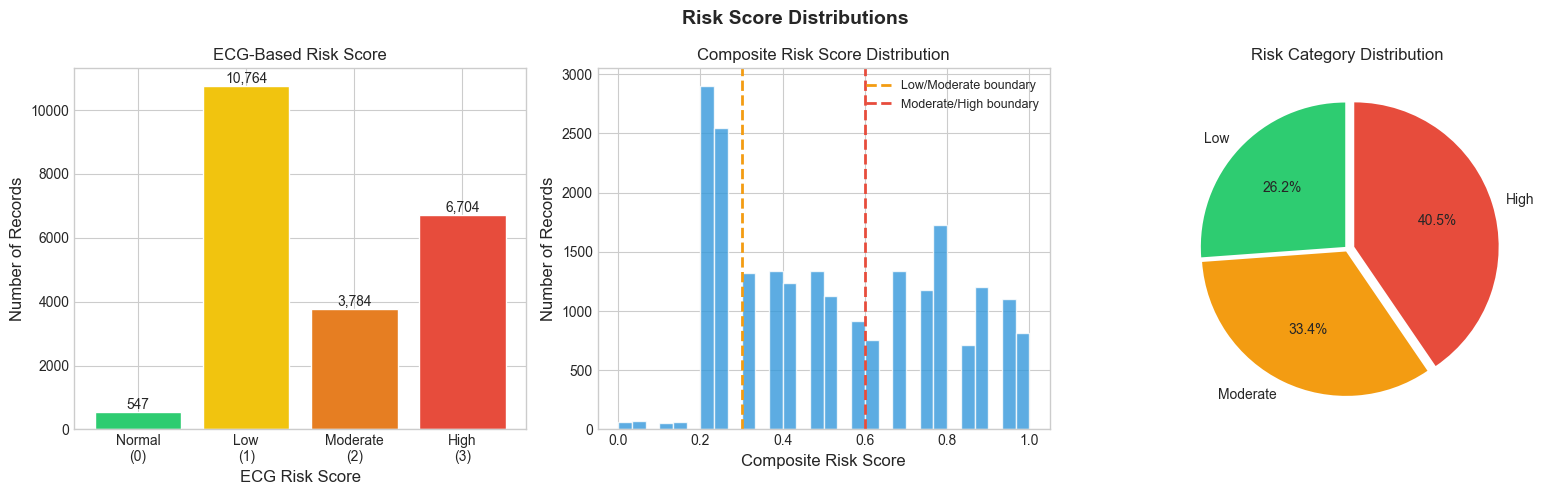

✓ Risk distribution visualization saved


In [21]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('Risk Score Distributions', fontsize=14, fontweight='bold')

# 1. ECG Risk Score Distribution
ax1 = axes[0]
risk_counts = df['ecg_risk_score'].value_counts().sort_index()
colors = ['#2ecc71', '#f1c40f', '#e67e22', '#e74c3c']
bars = ax1.bar(risk_counts.index, risk_counts.values, color=colors, edgecolor='white')
ax1.set_xlabel('ECG Risk Score', fontsize=12)
ax1.set_ylabel('Number of Records', fontsize=12)
ax1.set_title('ECG-Based Risk Score', fontsize=12)
ax1.set_xticks([0, 1, 2, 3])
ax1.set_xticklabels(['Normal\n(0)', 'Low\n(1)', 'Moderate\n(2)', 'High\n(3)'])
for bar, count in zip(bars, risk_counts.values):
    ax1.annotate(f'{count:,}', (bar.get_x() + bar.get_width()/2, bar.get_height()),
                 ha='center', va='bottom', fontsize=10)

# 2. Composite Risk Score Distribution (Histogram)
ax2 = axes[1]
ax2.hist(df['composite_risk'], bins=30, color='#3498db', edgecolor='white', alpha=0.8)
# Add category boundaries
ax2.axvline(0.3, color='#f39c12', linestyle='--', linewidth=2, label='Low/Moderate boundary')
ax2.axvline(0.6, color='#e74c3c', linestyle='--', linewidth=2, label='Moderate/High boundary')
ax2.set_xlabel('Composite Risk Score', fontsize=12)
ax2.set_ylabel('Number of Records', fontsize=12)
ax2.set_title('Composite Risk Score Distribution', fontsize=12)
ax2.legend(fontsize=9)

# 3. Risk Category Pie Chart
ax3 = axes[2]
cat_counts = df['risk_category'].value_counts()
cat_order = ['Low', 'Moderate', 'High']
sizes = [cat_counts.get(cat, 0) for cat in cat_order]
colors_pie = [RISK_COLORS[cat] for cat in cat_order]
wedges, texts, autotexts = ax3.pie(
    sizes, labels=cat_order, colors=colors_pie,
    autopct='%1.1f%%', startangle=90, explode=(0.02, 0.02, 0.05)
)
ax3.set_title('Risk Category Distribution', fontsize=12)

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['output_path'], 'risk_distribution.png'), dpi=150, bbox_inches='tight')
plt.show()

print("✓ Risk distribution visualization saved")

# Section 5: ECG Signal Processing

## What we're doing here:
This section prepares ECG signals for analysis:

1. **Normalization** - Z-score normalization for consistent amplitude scaling
2. **Optional filtering** - Light bandpass filter for noisy signals
3. **R-peak detection** - Finding heartbeat locations for HRV analysis
4. **Heart rate calculation** - Computing BPM from R-R intervals

### Why this matters:
- Raw ECG amplitudes vary between patients and devices
- Normalization ensures fair comparison across recordings
- R-peak detection enables heart rate variability (HRV) features
- HRV is a powerful predictor of cardiac health

### Note on PTB-XL signal quality:
The signals are already relatively clean (hospital-grade equipment). Heavy preprocessing is not necessary - we focus on:
- Normalization for consistent scaling
- R-peak detection for HRV analysis

In [22]:
def normalize_ecg(ecg_signal, epsilon=1e-8):
    normalized = np.zeros_like(ecg_signal, dtype=np.float32)
    
    for lead in range(ecg_signal.shape[1]):
        lead_signal = ecg_signal[:, lead]
        mean = np.mean(lead_signal)
        std = np.std(lead_signal)
        normalized[:, lead] = (lead_signal - mean) / (std + epsilon)
    
    return normalized

# Test normalization
print("Testing ECG normalization...")
sample_ecg = load_ecg_waveform(df.iloc[0]['filename_hr'], CONFIG['data_path'])
normalized_ecg = normalize_ecg(sample_ecg)

print("\n📊 Before Normalization:")
print(f"   Mean per lead: {sample_ecg.mean(axis=0).round(2)}")
print(f"   Std per lead:  {sample_ecg.std(axis=0).round(2)}")

print("\n📊 After Normalization:")
print(f"   Mean per lead: {normalized_ecg.mean(axis=0).round(4)}")
print(f"   Std per lead:  {normalized_ecg.std(axis=0).round(4)}")

print("\n✓ Normalization successful - zero mean, unit variance per lead")

Testing ECG normalization...

📊 Before Normalization:
   Mean per lead: [ 0.    0.   -0.   -0.    0.    0.   -0.    0.01 -0.   -0.    0.    0.  ]
   Std per lead:  [0.11 0.09 0.06 0.09 0.08 0.05 0.11 0.22 0.12 0.1  0.09 0.1 ]

📊 After Normalization:
   Mean per lead: [ 0. -0.  0.  0.  0.  0. -0.  0.  0. -0.  0. -0.]
   Std per lead:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

✓ Normalization successful - zero mean, unit variance per lead


In [23]:
def light_filter_ecg(ecg_signal, lowcut=0.5, highcut=40, fs=500, order=2):
    # Design Butterworth bandpass filter
    nyquist = fs / 2
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype='band')
    
    # Apply filter to each lead
    filtered = np.zeros_like(ecg_signal, dtype=np.float32)
    for lead in range(ecg_signal.shape[1]):
        filtered[:, lead] = signal.filtfilt(b, a, ecg_signal[:, lead])
    
    return filtered

print("✓ Bandpass filter function defined (0.5-40 Hz)")
print("   Note: PTB-XL signals are generally clean - filtering is optional")

✓ Bandpass filter function defined (0.5-40 Hz)
   Note: PTB-XL signals are generally clean - filtering is optional


In [24]:
def detect_r_peaks(ecg_lead, fs=500, min_distance_sec=0.3):

    # Minimum distance in samples
    min_distance = int(min_distance_sec * fs)
    
    # Adaptive height threshold: must be above mean + 0.5*std
    # This helps handle varying signal amplitudes
    height_threshold = np.mean(ecg_lead) + 0.5 * np.std(ecg_lead)
    
    # Find peaks
    peaks, properties = signal.find_peaks(
        ecg_lead,
        distance=min_distance,
        height=height_threshold,
        prominence=0.1 * np.std(ecg_lead)  # Must have some prominence
    )
    
    return peaks


def calculate_heart_rate(r_peaks, fs=500):
    if len(r_peaks) < 2:
        return {'mean_hr': np.nan, 'min_hr': np.nan, 'max_hr': np.nan}
    
    # Calculate RR intervals in milliseconds
    rr_intervals = np.diff(r_peaks) / fs * 1000  # Convert to ms
    
    # Filter implausible intervals (30-200 BPM range)
    valid_mask = (rr_intervals >= CONFIG['min_rr_interval']) & \
                 (rr_intervals <= CONFIG['max_rr_interval'])
    valid_rr = rr_intervals[valid_mask]
    
    if len(valid_rr) == 0:
        return {'mean_hr': np.nan, 'min_hr': np.nan, 'max_hr': np.nan}
    
    # Convert to BPM (60000 ms/min)
    mean_hr = 60000 / np.mean(valid_rr)
    min_hr = 60000 / np.max(valid_rr)  # Max RR = Min HR
    max_hr = 60000 / np.min(valid_rr)  # Min RR = Max HR
    
    return {'mean_hr': mean_hr, 'min_hr': min_hr, 'max_hr': max_hr}


print("✓ R-peak detection and heart rate calculation functions defined")

✓ R-peak detection and heart rate calculation functions defined



📊 R-Peak Detection Results:
   Number of R-peaks detected: 15
   Expected beats (10 sec): ~10.0-33.333333333333336 (at 60-200 BPM)

💓 Heart Rate Analysis:
   Mean HR: 89.5 BPM
   Min HR:  62.2 BPM
   Max HR:  196.1 BPM


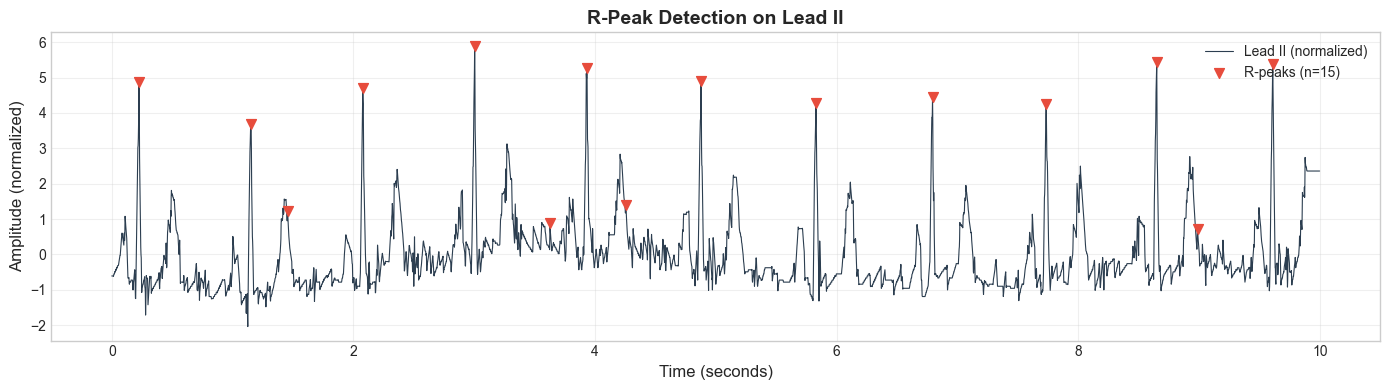


✓ R-peak detection working correctly


In [25]:
# Load and normalize a sample ECG
sample_ecg = load_ecg_waveform(df.iloc[0]['filename_hr'], CONFIG['data_path'])
normalized_ecg = normalize_ecg(sample_ecg)

# Use Lead II (index 1) for R-peak detection - best lead for this purpose
lead_ii = normalized_ecg[:, 1]

# Detect R-peaks
r_peaks = detect_r_peaks(lead_ii, fs=CONFIG['sampling_rate'])
hr_info = calculate_heart_rate(r_peaks, fs=CONFIG['sampling_rate'])

print(f"\n📊 R-Peak Detection Results:")
print(f"   Number of R-peaks detected: {len(r_peaks)}")
print(f"   Expected beats (10 sec): ~{10 * 60/60}-{10 * 200/60} (at 60-200 BPM)")
print(f"\n💓 Heart Rate Analysis:")
print(f"   Mean HR: {hr_info['mean_hr']:.1f} BPM")
print(f"   Min HR:  {hr_info['min_hr']:.1f} BPM")
print(f"   Max HR:  {hr_info['max_hr']:.1f} BPM")

# Visualize R-peak detection
fig, ax = plt.subplots(figsize=(14, 4))
time = np.arange(len(lead_ii)) / CONFIG['sampling_rate']

ax.plot(time, lead_ii, color='#2c3e50', linewidth=0.8, label='Lead II (normalized)')
ax.scatter(r_peaks / CONFIG['sampling_rate'], lead_ii[r_peaks], 
           color='#e74c3c', s=50, marker='v', zorder=5, label=f'R-peaks (n={len(r_peaks)})')

ax.set_xlabel('Time (seconds)', fontsize=12)
ax.set_ylabel('Amplitude (normalized)', fontsize=12)
ax.set_title('R-Peak Detection on Lead II', fontsize=14, fontweight='bold')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ R-peak detection working correctly")

# Section 6: Feature Extraction

## What we're doing here:
This section extracts numerical features from ECG signals for traditional ML models:

1. **HRV Time Domain** - Mean RR, SDNN, RMSSD, pNN50
2. **HRV Frequency Domain** - VLF, LF, HF power bands
3. **Morphological Features** - R-wave amplitudes, QRS duration
4. **Statistical Features** - Per-lead statistics (mean, std, skewness, etc.)

### Why this matters:
- Deep learning works on raw signals, but traditional ML needs engineered features
- HRV features are clinically validated predictors of cardiac health
- Statistical features capture signal characteristics efficiently
- ~100-150 features per ECG for XGBoost baseline

In [26]:
def extract_hrv_time_features(r_peaks, fs=500):
    features = {}
    
    if len(r_peaks) < 3:
        # Not enough peaks for HRV analysis
        return {
            'mean_rr': np.nan, 'std_rr': np.nan, 'sdnn': np.nan,
            'rmssd': np.nan, 'pnn50': np.nan, 'mean_hr': np.nan,
            'min_hr': np.nan, 'max_hr': np.nan, 'hr_range': np.nan
        }
    
    # Calculate RR intervals in milliseconds
    rr_intervals = np.diff(r_peaks) / fs * 1000
    
    # Filter physiologically plausible intervals
    valid_mask = (rr_intervals >= CONFIG['min_rr_interval']) & \
                 (rr_intervals <= CONFIG['max_rr_interval'])
    rr = rr_intervals[valid_mask]
    
    if len(rr) < 2:
        return {
            'mean_rr': np.nan, 'std_rr': np.nan, 'sdnn': np.nan,
            'rmssd': np.nan, 'pnn50': np.nan, 'mean_hr': np.nan,
            'min_hr': np.nan, 'max_hr': np.nan, 'hr_range': np.nan
        }
    
    # Time domain features
    features['mean_rr'] = np.mean(rr)
    features['std_rr'] = np.std(rr)
    features['sdnn'] = features['std_rr']  # Same as std_rr for normal beats
    
    # RMSSD - Root mean square of successive differences
    successive_diff = np.diff(rr)
    features['rmssd'] = np.sqrt(np.mean(successive_diff ** 2))
    
    # pNN50 - Percentage of successive intervals > 50ms difference
    features['pnn50'] = 100 * np.sum(np.abs(successive_diff) > 50) / len(successive_diff)
    
    # Heart rate features
    features['mean_hr'] = 60000 / features['mean_rr']
    features['min_hr'] = 60000 / np.max(rr)
    features['max_hr'] = 60000 / np.min(rr)
    features['hr_range'] = features['max_hr'] - features['min_hr']
    
    return features

print("✓ HRV time domain feature extraction defined")

✓ HRV time domain feature extraction defined


In [27]:
def extract_statistical_features(ecg_signal):
    features = {}
    
    for i, lead_name in enumerate(LEAD_NAMES):
        lead_signal = ecg_signal[:, i]
        prefix = f'{lead_name}_'
        
        # Basic statistics
        features[prefix + 'mean'] = np.mean(lead_signal)
        features[prefix + 'std'] = np.std(lead_signal)
        features[prefix + 'min'] = np.min(lead_signal)
        features[prefix + 'max'] = np.max(lead_signal)
        features[prefix + 'range'] = features[prefix + 'max'] - features[prefix + 'min']
        
        # Higher order statistics
        features[prefix + 'skewness'] = skew(lead_signal)
        features[prefix + 'kurtosis'] = kurtosis(lead_signal)
        
        # Percentiles
        features[prefix + 'p5'] = np.percentile(lead_signal, 5)
        features[prefix + 'p25'] = np.percentile(lead_signal, 25)
        features[prefix + 'p75'] = np.percentile(lead_signal, 75)
        features[prefix + 'p95'] = np.percentile(lead_signal, 95)
        
        # Zero crossing rate
        zero_crossings = np.sum(np.diff(np.signbit(lead_signal)))
        features[prefix + 'zcr'] = zero_crossings / len(lead_signal)
        
        # Signal energy
        features[prefix + 'energy'] = np.sum(lead_signal ** 2) / len(lead_signal)
    
    return features

print("✓ Statistical feature extraction defined (13 features × 12 leads = 156 features)")

✓ Statistical feature extraction defined (13 features × 12 leads = 156 features)


In [28]:
def extract_all_features(ecg_signal, fs=500):
    # Normalize the signal
    normalized = normalize_ecg(ecg_signal)
    
    # Detect R-peaks using Lead II
    lead_ii = normalized[:, 1]
    r_peaks = detect_r_peaks(lead_ii, fs=fs)
    
    # Extract HRV features
    hrv_features = extract_hrv_time_features(r_peaks, fs=fs)
    
    # Extract statistical features
    stat_features = extract_statistical_features(normalized)
    
    # Combine all features
    all_features = {**hrv_features, **stat_features}
    
    return all_features


def extract_features_batch(df_subset, data_path, verbose=True):
    """
    Extract features for a batch of ECGs.
    
    Returns a DataFrame with one row per ECG and columns for each feature.
    """
    all_features = []
    valid_indices = []
    errors = 0
    
    total = len(df_subset)
    for i, (idx, row) in enumerate(df_subset.iterrows()):
        try:
            # Load ECG
            ecg = load_ecg_waveform(row['filename_hr'], data_path)
            
            # Extract features
            features = extract_all_features(ecg)
            features['ecg_id'] = idx
            
            all_features.append(features)
            valid_indices.append(idx)
            
        except Exception as e:
            errors += 1
            if verbose and errors <= 3:
                print(f"  Warning: Could not process ECG {idx}: {e}")
        
        # Progress update
        if verbose and (i + 1) % 2000 == 0:
            print(f"  Processed {i + 1}/{total} ECGs...")
    
    if verbose:
        print(f"  ✓ Successfully processed {len(all_features)}/{total} ECGs ({errors} errors)")
    
    # Convert to DataFrame
    features_df = pd.DataFrame(all_features)
    features_df.set_index('ecg_id', inplace=True)
    
    return features_df

print("✓ Complete feature extraction pipeline defined")

✓ Complete feature extraction pipeline defined


In [29]:
# Check if features already extracted (to avoid re-running)
features_path = os.path.join(CONFIG['output_path'], 'extracted_features.csv')

if os.path.exists(features_path):
    print("Loading pre-extracted features...")
    features_df = pd.read_csv(features_path, index_col='ecg_id')
    print(f"✓ Loaded {len(features_df)} feature vectors from cache")
else:
    print("Extracting features from all ECGs (this may take a few minutes)...")
    print("=" * 60)
    features_df = extract_features_batch(df, CONFIG['data_path'], verbose=True)
    
    # Save for future use
    features_df.to_csv(features_path)
    print(f"\n✓ Features saved to {features_path}")

print(f"\n📊 Feature Matrix Shape: {features_df.shape}")
print(f"   {features_df.shape[0]} ECGs × {features_df.shape[1]} features")

Extracting features from all ECGs (this may take a few minutes)...
  Processed 2000/21799 ECGs...
  Processed 4000/21799 ECGs...
  Processed 6000/21799 ECGs...
  Processed 8000/21799 ECGs...
  Processed 10000/21799 ECGs...
  Processed 12000/21799 ECGs...
  Processed 14000/21799 ECGs...
  Processed 16000/21799 ECGs...
  Processed 18000/21799 ECGs...
  Processed 20000/21799 ECGs...
  ✓ Successfully processed 21799/21799 ECGs (0 errors)

✓ Features saved to outputs/extracted_features.csv

📊 Feature Matrix Shape: (21799, 165)
   21799 ECGs × 165 features


# Section 7: Data Preparation

## What we're doing here:
This section prepares data for model training:

1. **Train/Val/Test Split** - Using predefined stratified folds
2. **Feature Preprocessing** - Imputation and scaling for tabular features
3. **ECG Data Loading** - Load and normalize raw signals for deep learning
4. **Class Weight Calculation** - Handle class imbalance

### Why this matters:
- Proper data splits prevent overfitting and ensure fair evaluation
- Feature scaling is critical for many ML algorithms
- Class weights help models learn from imbalanced data

In [30]:
# Split dataframes based on predefined folds
train_df = df[df['strat_fold'].isin(CONFIG['train_folds'])].copy()
val_df = df[df['strat_fold'].isin(CONFIG['val_folds'])].copy()
test_df = df[df['strat_fold'].isin(CONFIG['test_folds'])].copy()

print("📊 Data Split:")
print("-" * 50)
print(f"   Training:   {len(train_df):,} samples")
print(f"   Validation: {len(val_df):,} samples")
print(f"   Test:       {len(test_df):,} samples")

# Check class distribution in each split
print("\n📊 Class Distribution (ecg_risk_score):")
for name, split_df in [('Train', train_df), ('Val', val_df), ('Test', test_df)]:
    dist = split_df['ecg_risk_score'].value_counts().sort_index()
    print(f"   {name}: {dict(dist)}")

📊 Data Split:
--------------------------------------------------
   Training:   17,418 samples
   Validation: 2,183 samples
   Test:       2,198 samples

📊 Class Distribution (ecg_risk_score):
   Train: {0: np.int64(441), 1: np.int64(8588), 2: np.int64(2979), 3: np.int64(5410)}
   Val: {0: np.int64(43), 1: np.int64(1087), 2: np.int64(411), 3: np.int64(642)}
   Test: {0: np.int64(63), 1: np.int64(1089), 2: np.int64(394), 3: np.int64(652)}


In [31]:
# Get feature matrices for each split
X_train = features_df.loc[features_df.index.isin(train_df.index)].copy()
X_val = features_df.loc[features_df.index.isin(val_df.index)].copy()
X_test = features_df.loc[features_df.index.isin(test_df.index)].copy()

# Get labels
y_train = train_df.loc[X_train.index, 'ecg_risk_score'].values
y_val = val_df.loc[X_val.index, 'ecg_risk_score'].values
y_test = test_df.loc[X_test.index, 'ecg_risk_score'].values

# Binary labels
y_train_binary = train_df.loc[X_train.index, 'high_risk_binary'].values
y_val_binary = val_df.loc[X_val.index, 'high_risk_binary'].values
y_test_binary = test_df.loc[X_test.index, 'high_risk_binary'].values

print(f"📊 Feature Matrices:")
print(f"   X_train: {X_train.shape}")
print(f"   X_val:   {X_val.shape}")
print(f"   X_test:  {X_test.shape}")

# Handle missing values with median imputation
print("\n🔧 Handling missing values...")
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)
X_test_imputed = imputer.transform(X_test)

# Scale features
print("🔧 Scaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

print("✓ Tabular features prepared")

📊 Feature Matrices:
   X_train: (17418, 165)
   X_val:   (2183, 165)
   X_test:  (2198, 165)

🔧 Handling missing values...
🔧 Scaling features...
✓ Tabular features prepared


In [32]:
# Calculate class weights for multi-class classification
classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))

print("📊 Class Weights (Multi-class):")
print("-" * 50)
for cls, weight in class_weight_dict.items():
    count = (y_train == cls).sum()
    print(f"   Class {cls}: weight={weight:.3f} (n={count:,})")

# Calculate class weights for binary classification
binary_classes = np.unique(y_train_binary)
binary_class_weights = compute_class_weight('balanced', classes=binary_classes, y=y_train_binary)
binary_class_weight_dict = dict(zip(binary_classes, binary_class_weights))

print("\n📊 Class Weights (Binary):")
for cls, weight in binary_class_weight_dict.items():
    label = "Low Risk" if cls == 0 else "High Risk"
    count = (y_train_binary == cls).sum()
    print(f"   {label} ({cls}): weight={weight:.3f} (n={count:,})")

📊 Class Weights (Multi-class):
--------------------------------------------------
   Class 0: weight=9.874 (n=441)
   Class 1: weight=0.507 (n=8,588)
   Class 2: weight=1.462 (n=2,979)
   Class 3: weight=0.805 (n=5,410)

📊 Class Weights (Binary):
   Low Risk (0): weight=1.082 (n=8,051)
   High Risk (1): weight=0.930 (n=9,367)


In [33]:
class ECGDataset(Dataset):
    def __init__(self, df_subset, labels, data_path, transform=None):
        self.df = df_subset.reset_index()
        self.labels = labels
        self.data_path = data_path
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Load and normalize ECG
        ecg = load_ecg_waveform(row['filename_hr'], self.data_path)
        ecg = normalize_ecg(ecg)
        
        # Convert to tensor (channels first for PyTorch: [12, 5000])
        ecg_tensor = torch.tensor(ecg.T, dtype=torch.float32)
        
        # Get label
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        
        if self.transform:
            ecg_tensor = self.transform(ecg_tensor)
        
        return ecg_tensor, label


class MultiModalDataset(Dataset):
    """
    Dataset that returns both ECG signals and tabular features.
    Used for the multi-modal fusion model.
    """
    def __init__(self, df_subset, tabular_features, labels, data_path):
        self.df = df_subset.reset_index()
        self.tabular = tabular_features
        self.labels = labels
        self.data_path = data_path
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Load and normalize ECG
        ecg = load_ecg_waveform(row['filename_hr'], self.data_path)
        ecg = normalize_ecg(ecg)
        ecg_tensor = torch.tensor(ecg.T, dtype=torch.float32)
        
        # Get tabular features
        tabular_tensor = torch.tensor(self.tabular[idx], dtype=torch.float32)
        
        # Get label
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        
        return ecg_tensor, tabular_tensor, label


print("✓ PyTorch Dataset classes defined")

✓ PyTorch Dataset classes defined


In [34]:
# Create datasets
train_dataset = ECGDataset(train_df.loc[X_train.index], y_train, CONFIG['data_path'])
val_dataset = ECGDataset(val_df.loc[X_val.index], y_val, CONFIG['data_path'])
test_dataset = ECGDataset(test_df.loc[X_test.index], y_test, CONFIG['data_path'])

# Create DataLoaders with appropriate settings
train_loader = DataLoader(
    train_dataset, 
    batch_size=CONFIG['batch_size'], 
    shuffle=True, 
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=CONFIG['batch_size'], 
    shuffle=False, 
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=CONFIG['batch_size'], 
    shuffle=False, 
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

# Multi-modal datasets
train_mm_dataset = MultiModalDataset(
    train_df.loc[X_train.index], X_train_scaled, y_train, CONFIG['data_path']
)
val_mm_dataset = MultiModalDataset(
    val_df.loc[X_val.index], X_val_scaled, y_val, CONFIG['data_path']
)
test_mm_dataset = MultiModalDataset(
    test_df.loc[X_test.index], X_test_scaled, y_test, CONFIG['data_path']
)

train_mm_loader = DataLoader(train_mm_dataset, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=0)
val_mm_loader = DataLoader(val_mm_dataset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=0)
test_mm_loader = DataLoader(test_mm_dataset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=0)

print("📊 DataLoaders Created:")
print(f"   Training batches:   {len(train_loader)}")
print(f"   Validation batches: {len(val_loader)}")
print(f"   Test batches:       {len(test_loader)}")

# Test loading a batch
sample_batch = next(iter(train_loader))
print(f"\n📊 Sample Batch Shape:")
print(f"   ECG tensor:   {sample_batch[0].shape}")  # [batch, channels, samples]
print(f"   Labels:       {sample_batch[1].shape}")

print("\n✓ DataLoaders ready for training")

📊 DataLoaders Created:
   Training batches:   273
   Validation batches: 35
   Test batches:       35

📊 Sample Batch Shape:
   ECG tensor:   torch.Size([64, 12, 5000])
   Labels:       torch.Size([64])

✓ DataLoaders ready for training


# Section 8: Traditional ML Baseline (XGBoost)

## What we're doing here:
This section trains an XGBoost classifier as our baseline model:

1. **Train XGBoost** - Gradient boosted trees on extracted features
2. **Early Stopping** - Prevent overfitting using validation set
3. **Evaluate Performance** - Classification report, confusion matrix, ROC AUC
4. **Feature Importance** - Identify most predictive features

### Why XGBoost as baseline:
- State-of-the-art for tabular data
- Handles class imbalance well
- Fast training and inference
- Provides feature importance for interpretability
- Excellent comparison point for deep learning models

In [37]:
# Convert class weights to sample weights for XGBoost
sample_weights = np.array([class_weight_dict[y] for y in y_train])

# Create XGBoost classifier
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=3,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1.0,
    objective='multi:softprob',
    num_class=4,
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=CONFIG['random_state'],
    n_jobs=-1,
    verbosity=1
)

print("Training XGBoost model...")
print("=" * 60)

# Train with early stopping
xgb_model.fit(
    X_train_scaled, 
    y_train,
    sample_weight=sample_weights,
    eval_set=[(X_val_scaled, y_val)],
    verbose=20
)

print("\n✓ XGBoost training complete")

Training XGBoost model...
[0]	validation_0-mlogloss:1.34570
[20]	validation_0-mlogloss:0.98707
[40]	validation_0-mlogloss:0.87794
[60]	validation_0-mlogloss:0.82379
[80]	validation_0-mlogloss:0.79505
[100]	validation_0-mlogloss:0.77539
[120]	validation_0-mlogloss:0.76063
[140]	validation_0-mlogloss:0.75121
[160]	validation_0-mlogloss:0.74327
[180]	validation_0-mlogloss:0.73835
[199]	validation_0-mlogloss:0.73353

✓ XGBoost training complete


In [38]:
# Make predictions
y_pred_xgb = xgb_model.predict(X_test_scaled)
y_pred_proba_xgb = xgb_model.predict_proba(X_test_scaled)

# Classification report
print("=" * 60)
print("XGBOOST CLASSIFICATION REPORT")
print("=" * 60)
risk_labels = ['Normal (0)', 'Low (1)', 'Moderate (2)', 'High (3)']
print(classification_report(y_test, y_pred_xgb, target_names=risk_labels))

# Calculate metrics
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
xgb_f1_macro = f1_score(y_test, y_pred_xgb, average='macro')
xgb_f1_weighted = f1_score(y_test, y_pred_xgb, average='weighted')

# ROC AUC (one-vs-rest)
try:
    xgb_auc = roc_auc_score(y_test, y_pred_proba_xgb, multi_class='ovr', average='macro')
except:
    xgb_auc = 0.0

print("\n📊 Summary Metrics:")
print("-" * 40)
print(f"   Accuracy:        {xgb_accuracy:.4f}")
print(f"   F1 (macro):      {xgb_f1_macro:.4f}")
print(f"   F1 (weighted):   {xgb_f1_weighted:.4f}")
print(f"   ROC AUC (macro): {xgb_auc:.4f}")

# Store metrics for comparison
model_metrics = {
    'XGBoost': {
        'accuracy': xgb_accuracy,
        'f1_macro': xgb_f1_macro,
        'f1_weighted': xgb_f1_weighted,
        'auc': xgb_auc
    }
}

XGBOOST CLASSIFICATION REPORT
              precision    recall  f1-score   support

  Normal (0)       0.88      0.22      0.35        63
     Low (1)       0.74      0.82      0.78      1089
Moderate (2)       0.44      0.45      0.45       394
    High (3)       0.68      0.60      0.63       652

    accuracy                           0.67      2198
   macro avg       0.68      0.52      0.55      2198
weighted avg       0.67      0.67      0.66      2198


📊 Summary Metrics:
----------------------------------------
   Accuracy:        0.6715
   F1 (macro):      0.5536
   F1 (weighted):   0.6648
   ROC AUC (macro): 0.8030


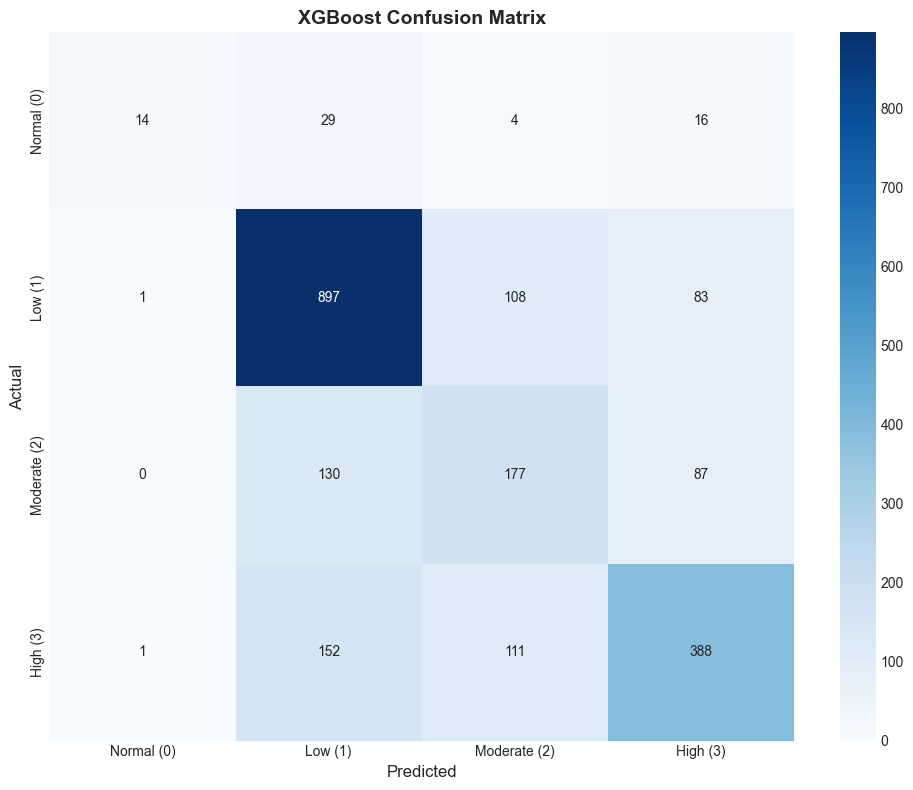

✓ Confusion matrix saved


In [39]:
fig, ax = plt.subplots(figsize=(10, 8))

cm = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=risk_labels,
    yticklabels=risk_labels,
    ax=ax
)

ax.set_xlabel('Predicted', fontsize=12)
ax.set_ylabel('Actual', fontsize=12)
ax.set_title('XGBoost Confusion Matrix', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['output_path'], 'confusion_matrix_xgboost.png'), dpi=150, bbox_inches='tight')
plt.show()

print("✓ Confusion matrix saved")

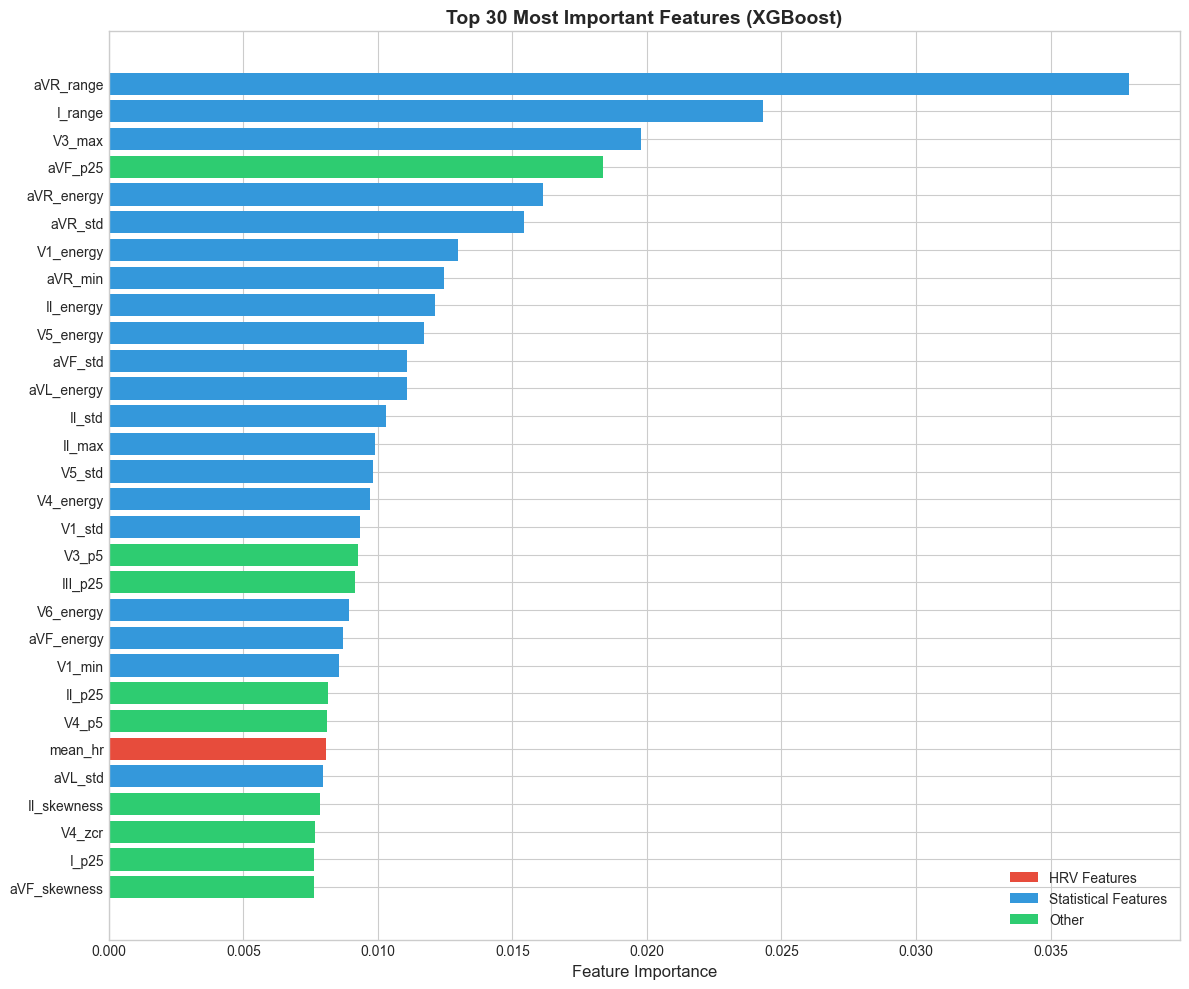


📊 Top Features by Category:
--------------------------------------------------
   HRV: 1 features in top 30
      Top 3: mean_hr
   Statistical: 20 features in top 30
      Top 3: aVR_range, I_range, V3_max
   Other: 9 features in top 30
      Top 3: aVF_p25, V3_p5, III_p25

✓ Feature importance analysis complete


In [40]:
# Get feature importances
feature_names = X_train.columns.tolist()
importances = xgb_model.feature_importances_

# Create DataFrame and sort
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

# Plot top 30 features
fig, ax = plt.subplots(figsize=(12, 10))

top_n = 30
top_features = importance_df.head(top_n)

# Color by feature category
def get_feature_category(name):
    if any(hrv in name for hrv in ['rr', 'hr', 'sdnn', 'rmssd', 'pnn50']):
        return 'HRV'
    elif any(stat in name for stat in ['mean', 'std', 'min', 'max', 'range', 'energy']):
        return 'Statistical'
    else:
        return 'Other'

colors = [{'HRV': '#e74c3c', 'Statistical': '#3498db', 'Other': '#2ecc71'}[get_feature_category(f)] 
          for f in top_features['feature']]

bars = ax.barh(range(top_n), top_features['importance'].values, color=colors)
ax.set_yticks(range(top_n))
ax.set_yticklabels(top_features['feature'].values)
ax.set_xlabel('Feature Importance', fontsize=12)
ax.set_title(f'Top {top_n} Most Important Features (XGBoost)', fontsize=14, fontweight='bold')
ax.invert_yaxis()

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#e74c3c', label='HRV Features'),
    Patch(facecolor='#3498db', label='Statistical Features'),
    Patch(facecolor='#2ecc71', label='Other')
]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['output_path'], 'feature_importance_xgboost.png'), dpi=150, bbox_inches='tight')
plt.show()

# Summary of top features by category
print("\n📊 Top Features by Category:")
print("-" * 50)
for cat in ['HRV', 'Statistical', 'Other']:
    cat_features = [f for f in top_features['feature'] if get_feature_category(f) == cat]
    print(f"   {cat}: {len(cat_features)} features in top {top_n}")
    if cat_features[:3]:
        print(f"      Top 3: {', '.join(cat_features[:3])}")

print("\n✓ Feature importance analysis complete")

In [41]:
import pickle

# Save model
xgb_model_path = os.path.join(CONFIG['output_path'], 'xgboost_model.pkl')
with open(xgb_model_path, 'wb') as f:
    pickle.dump(xgb_model, f)

print(f"✓ XGBoost model saved to {xgb_model_path}")

✓ XGBoost model saved to outputs/xgboost_model.pkl


# Section 9: Deep Learning Models (PyTorch)

## What we're doing here:
This section builds and trains deep learning models for ECG classification:

1. **1D CNN** - Convolutional neural network for pattern recognition
2. **CNN-LSTM** - Hybrid architecture capturing both local and temporal patterns
3. **Multi-Modal Fusion** - Combines ECG signals with tabular features

### Architecture overview:
- **1D CNN**: Stacked Conv1D layers with BatchNorm, pooling, and dropout
- **CNN-LSTM**: CNN encoder followed by bidirectional LSTM
- **Multi-Modal**: Two-branch network with late fusion

### Why deep learning for ECG:
- Raw signals contain patterns that engineered features may miss
- CNNs excel at detecting morphological abnormalities (ST changes, QRS abnormalities)
- LSTMs capture temporal dependencies across the cardiac cycle
- Multi-modal fusion leverages both signal patterns and extracted features

In [42]:
# Check for GPU
if torch.cuda.is_available():
    DEVICE = torch.device('cuda:0')
    torch.backends.cudnn.benchmark = True  # Optimize for fixed input size
    print(f"✓ Using GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
else:
    DEVICE = torch.device('cpu')
    print("⚠ GPU not available, using CPU (training will be slower)")

# Number of classes
NUM_CLASSES = 4

print(f"\n📊 Model Configuration:")
print(f"   Device: {DEVICE}")
print(f"   Number of classes: {NUM_CLASSES}")
print(f"   Batch size: {CONFIG['batch_size']}")
print(f"   Learning rate: {CONFIG['learning_rate']}")

✓ Using GPU: NVIDIA GeForce RTX 3050 Ti Laptop GPU
   Memory: 4.0 GB

📊 Model Configuration:
   Device: cuda:0
   Number of classes: 4
   Batch size: 64
   Learning rate: 0.001


In [43]:
class ECG_CNN(nn.Module):
    """
    1D Convolutional Neural Network for ECG classification.
    
    Architecture:
    - 4 convolutional blocks with BatchNorm, ReLU, MaxPool, Dropout
    - Global average pooling
    - 2 fully connected layers
    - Softmax output
    
    Input: (batch, 12, 5000) - 12 leads, 5000 samples
    Output: (batch, num_classes) - class probabilities
    """
    def __init__(self, num_leads=12, num_samples=5000, num_classes=4):
        super(ECG_CNN, self).__init__()
        
        # Convolutional blocks
        self.conv1 = nn.Sequential(
            nn.Conv1d(num_leads, 32, kernel_size=7, padding=3),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(0.2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(0.2)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(0.3)
        )
        
        self.conv4 = nn.Sequential(
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)  # Global average pooling
        )
        
        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.fc(x)
        return x
    
    def get_features(self, x):
        """Extract features before final classification layer."""
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(x.size(0), -1)
        return x

# Test the model
cnn_model = ECG_CNN(num_classes=NUM_CLASSES).to(DEVICE)
sample_input = torch.randn(2, 12, 5000).to(DEVICE)
sample_output = cnn_model(sample_input)

print("📊 1D CNN Architecture:")
print(f"   Input shape:  {sample_input.shape}")
print(f"   Output shape: {sample_output.shape}")
print(f"   Parameters:   {sum(p.numel() for p in cnn_model.parameters()):,}")

📊 1D CNN Architecture:
   Input shape:  torch.Size([2, 12, 5000])
   Output shape: torch.Size([2, 4])
   Parameters:   178,660


In [44]:
class ECG_CNN_LSTM(nn.Module):
    """
    CNN-LSTM Hybrid for ECG classification.
    
    Architecture:
    - CNN encoder with aggressive pooling
    - Bidirectional LSTM for temporal modeling
    - Fully connected classifier
    
    The CNN extracts local morphological features, while the LSTM
    captures temporal dependencies across the cardiac cycle.
    """
    def __init__(self, num_leads=12, num_classes=4):
        super(ECG_CNN_LSTM, self).__init__()
        
        # CNN encoder (more aggressive pooling for LSTM input)
        self.conv1 = nn.Sequential(
            nn.Conv1d(num_leads, 32, kernel_size=7, padding=3),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(4),
            nn.Dropout(0.2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(4),
            nn.Dropout(0.2)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(4),
            nn.Dropout(0.3)
        )
        
        # Bidirectional LSTM
        self.lstm1 = nn.LSTM(
            input_size=128,
            hidden_size=64,
            num_layers=1,
            batch_first=True,
            bidirectional=True,
            dropout=0
        )
        
        self.lstm2 = nn.LSTM(
            input_size=128,  # 64 * 2 (bidirectional)
            hidden_size=32,
            num_layers=1,
            batch_first=True,
            bidirectional=True,
            dropout=0
        )
        
        # Classifier
        self.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(64, 32),  # 32 * 2 (bidirectional)
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, num_classes)
        )
        
    def forward(self, x):
        # CNN encoding
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        # Reshape for LSTM: (batch, channels, seq_len) -> (batch, seq_len, channels)
        x = x.permute(0, 2, 1)
        
        # LSTM layers
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        
        # Take the last output
        x = x[:, -1, :]
        
        # Classifier
        x = self.fc(x)
        return x

# Test the model
cnn_lstm_model = ECG_CNN_LSTM(num_classes=NUM_CLASSES).to(DEVICE)
sample_output = cnn_lstm_model(sample_input)

print("📊 CNN-LSTM Architecture:")
print(f"   Input shape:  {sample_input.shape}")
print(f"   Output shape: {sample_output.shape}")
print(f"   Parameters:   {sum(p.numel() for p in cnn_lstm_model.parameters()):,}")

📊 CNN-LSTM Architecture:
   Input shape:  torch.Size([2, 12, 5000])
   Output shape: torch.Size([2, 4])
   Parameters:   181,188


In [45]:
class ECG_MultiModal(nn.Module):
    """
    Multi-Modal Fusion Network combining ECG signals with tabular features.
    
    Architecture:
    - ECG Branch: 1D CNN encoder
    - Tabular Branch: Dense layers
    - Fusion: Concatenate embeddings and classify
    
    This architecture leverages both the raw signal patterns
    and the engineered features for improved performance.
    """
    def __init__(self, num_leads=12, num_tabular_features=165, num_classes=4):
        super(ECG_MultiModal, self).__init__()
        
        # ECG Branch (CNN)
        self.ecg_conv1 = nn.Sequential(
            nn.Conv1d(num_leads, 32, kernel_size=7, padding=3),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(4),
            nn.Dropout(0.2)
        )
        
        self.ecg_conv2 = nn.Sequential(
            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(4),
            nn.Dropout(0.2)
        )
        
        self.ecg_conv3 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        
        self.ecg_fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        
        # Tabular Branch
        self.tabular_fc = nn.Sequential(
            nn.Linear(num_tabular_features, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        
        # Fusion and Classification
        self.fusion = nn.Sequential(
            nn.Linear(64 + 32, 64),  # ECG embedding + Tabular embedding
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, num_classes)
        )
        
    def forward(self, ecg, tabular):
        # ECG branch
        x_ecg = self.ecg_conv1(ecg)
        x_ecg = self.ecg_conv2(x_ecg)
        x_ecg = self.ecg_conv3(x_ecg)
        x_ecg = self.ecg_fc(x_ecg)
        
        # Tabular branch
        x_tab = self.tabular_fc(tabular)
        
        # Fusion
        x = torch.cat([x_ecg, x_tab], dim=1)
        x = self.fusion(x)
        
        return x

# Test the model
num_tabular = X_train_scaled.shape[1]
multimodal_model = ECG_MultiModal(num_tabular_features=num_tabular, num_classes=NUM_CLASSES).to(DEVICE)

sample_ecg = torch.randn(2, 12, 5000).to(DEVICE)
sample_tab = torch.randn(2, num_tabular).to(DEVICE)
sample_output = multimodal_model(sample_ecg, sample_tab)

print("📊 Multi-Modal Architecture:")
print(f"   ECG input shape:     {sample_ecg.shape}")
print(f"   Tabular input shape: {sample_tab.shape}")
print(f"   Output shape:        {sample_output.shape}")
print(f"   Parameters:          {sum(p.numel() for p in multimodal_model.parameters()):,}")

📊 Multi-Modal Architecture:
   ECG input shape:     torch.Size([2, 12, 5000])
   Tabular input shape: torch.Size([2, 165])
   Output shape:        torch.Size([2, 4])
   Parameters:          67,684


In [46]:
def train_epoch(model, loader, criterion, optimizer, device, is_multimodal=False):
    """Train for one epoch."""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch in loader:
        if is_multimodal:
            ecg, tabular, labels = batch
            ecg, tabular, labels = ecg.to(device), tabular.to(device), labels.to(device)
            outputs = model(ecg, tabular)
        else:
            ecg, labels = batch
            ecg, labels = ecg.to(device), labels.to(device)
            outputs = model(ecg)
        
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    return total_loss / len(loader), 100. * correct / total


def validate_epoch(model, loader, criterion, device, is_multimodal=False):
    """Validate for one epoch."""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in loader:
            if is_multimodal:
                ecg, tabular, labels = batch
                ecg, tabular, labels = ecg.to(device), tabular.to(device), labels.to(device)
                outputs = model(ecg, tabular)
            else:
                ecg, labels = batch
                ecg, labels = ecg.to(device), labels.to(device)
                outputs = model(ecg)
            
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    return total_loss / len(loader), 100. * correct / total


def train_model(model, train_loader, val_loader, epochs, lr, device, 
                is_multimodal=False, patience=10, model_name='model'):
    """
    Complete training loop with early stopping.
    """
    # Setup
    criterion = nn.CrossEntropyLoss(weight=torch.tensor(list(class_weight_dict.values())).float().to(device))
    optimizer = Adam(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6)
    
    # History
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    print(f"\nTraining {model_name}...")
    print("=" * 60)
    
    for epoch in range(epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device, is_multimodal)
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device, is_multimodal)
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        scheduler.step(val_loss)
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
        
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"Epoch {epoch+1:3d}/{epochs} | "
                  f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
                  f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
        
        if patience_counter >= patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break
    
    # Restore best model
    if best_model_state:
        model.load_state_dict(best_model_state)
    
    print(f"\n✓ Training complete. Best val loss: {best_val_loss:.4f}")
    
    return model, history


print("✓ Training functions defined")

✓ Training functions defined


In [47]:
# Initialize model
cnn_model = ECG_CNN(num_classes=NUM_CLASSES).to(DEVICE)

# Train
cnn_model, cnn_history = train_model(
    model=cnn_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=CONFIG['epochs'],
    lr=CONFIG['learning_rate'],
    device=DEVICE,
    is_multimodal=False,
    patience=10,
    model_name='1D CNN'
)

# Save model
torch.save(cnn_model.state_dict(), os.path.join(CONFIG['output_path'], 'cnn_model.pth'))
print(f"✓ CNN model saved")


Training 1D CNN...
Epoch   1/50 | Train Loss: 1.1762 | Train Acc: 60.09% | Val Loss: 1.1525 | Val Acc: 66.38%
Epoch   5/50 | Train Loss: 0.9475 | Train Acc: 68.76% | Val Loss: 0.9343 | Val Acc: 72.24%
Epoch  10/50 | Train Loss: 0.8774 | Train Acc: 71.18% | Val Loss: 0.8916 | Val Acc: 74.44%
Epoch  15/50 | Train Loss: 0.8398 | Train Acc: 71.68% | Val Loss: 0.8823 | Val Acc: 74.21%
Epoch  20/50 | Train Loss: 0.8021 | Train Acc: 71.01% | Val Loss: 0.8655 | Val Acc: 74.76%
Epoch  25/50 | Train Loss: 0.7853 | Train Acc: 71.96% | Val Loss: 0.8555 | Val Acc: 74.21%
Epoch  30/50 | Train Loss: 0.7490 | Train Acc: 72.09% | Val Loss: 0.8783 | Val Acc: 70.59%
Epoch  35/50 | Train Loss: 0.6939 | Train Acc: 72.87% | Val Loss: 0.9334 | Val Acc: 71.92%

Early stopping at epoch 35

✓ Training complete. Best val loss: 0.8555
✓ CNN model saved


In [48]:
# Initialize model
cnn_lstm_model = ECG_CNN_LSTM(num_classes=NUM_CLASSES).to(DEVICE)

# Train
cnn_lstm_model, cnn_lstm_history = train_model(
    model=cnn_lstm_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=CONFIG['epochs'],
    lr=CONFIG['learning_rate'],
    device=DEVICE,
    is_multimodal=False,
    patience=10,
    model_name='CNN-LSTM'
)

# Save model
torch.save(cnn_lstm_model.state_dict(), os.path.join(CONFIG['output_path'], 'cnn_lstm_model.pth'))
print(f"✓ CNN-LSTM model saved")


Training CNN-LSTM...
Epoch   1/50 | Train Loss: 1.2922 | Train Acc: 55.92% | Val Loss: 1.2681 | Val Acc: 64.41%
Epoch   5/50 | Train Loss: 0.9656 | Train Acc: 66.74% | Val Loss: 0.9670 | Val Acc: 71.64%
Epoch  10/50 | Train Loss: 0.9141 | Train Acc: 70.67% | Val Loss: 0.9099 | Val Acc: 68.58%
Epoch  15/50 | Train Loss: 0.8387 | Train Acc: 72.03% | Val Loss: 0.9472 | Val Acc: 71.23%
Epoch  20/50 | Train Loss: 0.7805 | Train Acc: 71.24% | Val Loss: 0.9366 | Val Acc: 73.34%
Epoch  25/50 | Train Loss: 0.7100 | Train Acc: 72.56% | Val Loss: 0.9025 | Val Acc: 73.39%

Early stopping at epoch 26

✓ Training complete. Best val loss: 0.8649
✓ CNN-LSTM model saved


In [49]:
# Initialize model
multimodal_model = ECG_MultiModal(
    num_tabular_features=X_train_scaled.shape[1],
    num_classes=NUM_CLASSES
).to(DEVICE)

# Train
multimodal_model, multimodal_history = train_model(
    model=multimodal_model,
    train_loader=train_mm_loader,
    val_loader=val_mm_loader,
    epochs=CONFIG['epochs'],
    lr=CONFIG['learning_rate'],
    device=DEVICE,
    is_multimodal=True,
    patience=10,
    model_name='Multi-Modal'
)

# Save model
torch.save(multimodal_model.state_dict(), os.path.join(CONFIG['output_path'], 'multimodal_model.pth'))
print(f"✓ Multi-Modal model saved")


Training Multi-Modal...
Epoch   1/50 | Train Loss: 1.1610 | Train Acc: 58.16% | Val Loss: 1.0117 | Val Acc: 64.68%
Epoch   5/50 | Train Loss: 0.8946 | Train Acc: 68.91% | Val Loss: 0.9315 | Val Acc: 69.40%
Epoch  10/50 | Train Loss: 0.8094 | Train Acc: 70.58% | Val Loss: 0.9128 | Val Acc: 69.77%

Early stopping at epoch 14

✓ Training complete. Best val loss: 0.8872
✓ Multi-Modal model saved


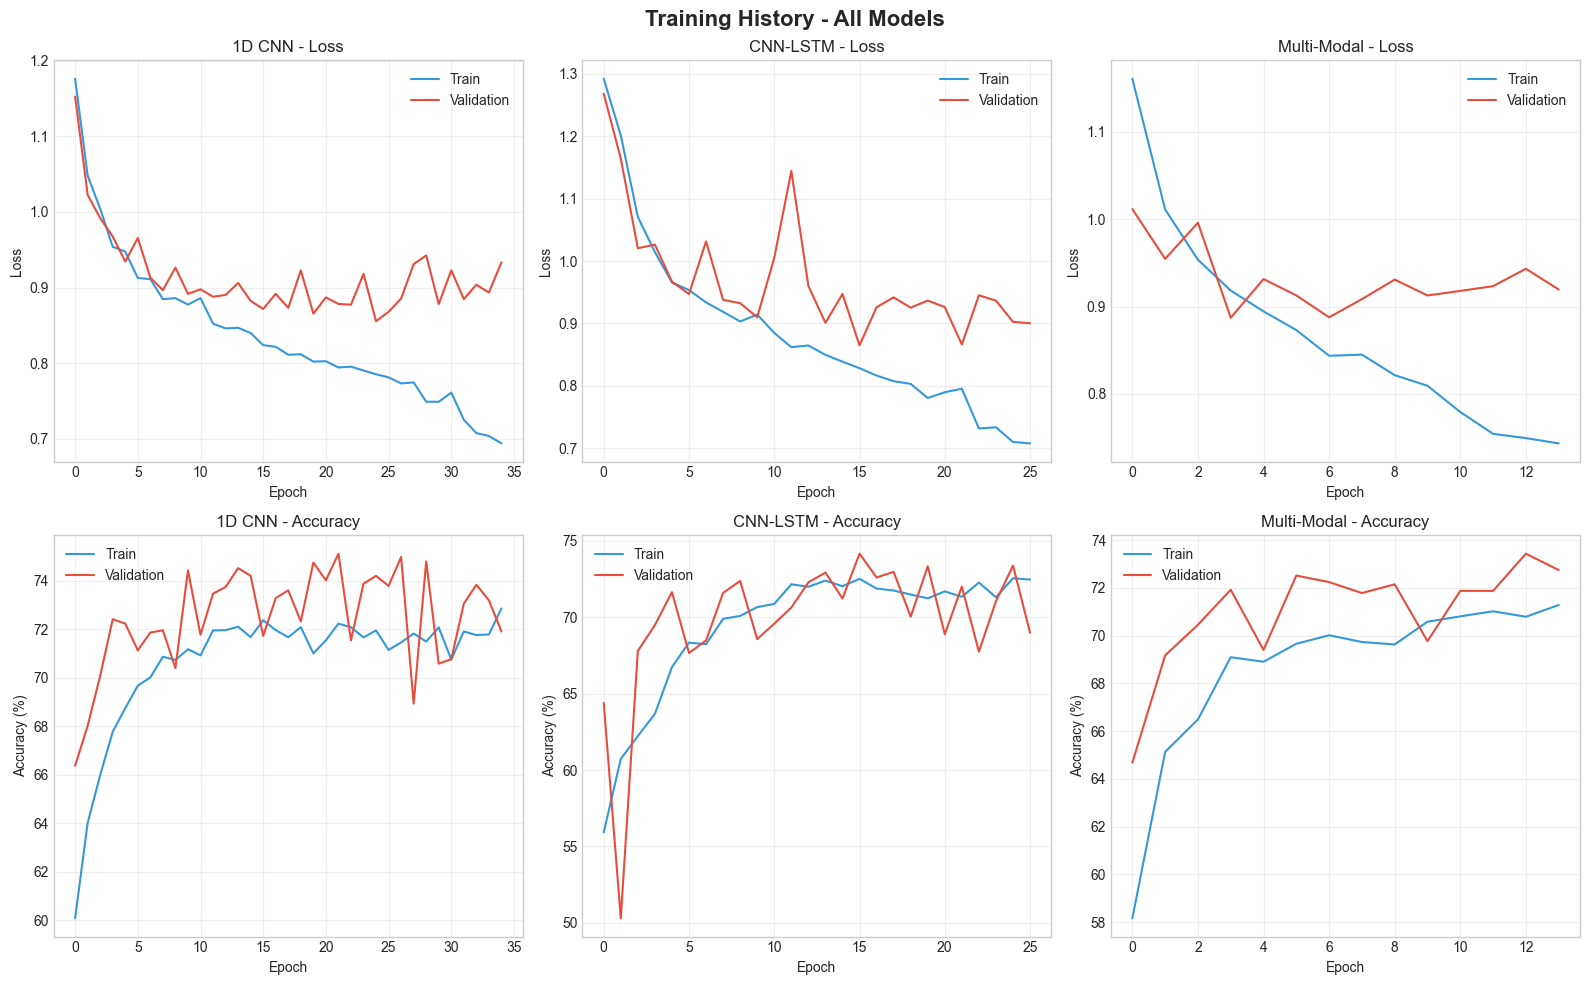

✓ Learning curves saved


In [50]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('Training History - All Models', fontsize=16, fontweight='bold')

histories = [
    ('1D CNN', cnn_history),
    ('CNN-LSTM', cnn_lstm_history),
    ('Multi-Modal', multimodal_history)
]

for idx, (name, history) in enumerate(histories):
    # Loss
    ax1 = axes[0, idx]
    ax1.plot(history['train_loss'], label='Train', color='#3498db')
    ax1.plot(history['val_loss'], label='Validation', color='#e74c3c')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title(f'{name} - Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Accuracy
    ax2 = axes[1, idx]
    ax2.plot(history['train_acc'], label='Train', color='#3498db')
    ax2.plot(history['val_acc'], label='Validation', color='#e74c3c')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title(f'{name} - Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['output_path'], 'learning_curves.png'), dpi=150, bbox_inches='tight')
plt.show()

print("✓ Learning curves saved")

# Section 10: Model Evaluation

## What we're doing here:
This section comprehensively evaluates and compares all models:

1. **Test Set Predictions** - Generate predictions from all models
2. **Metrics Calculation** - Accuracy, F1, AUC, Kappa for each model
3. **Confusion Matrices** - Visualize prediction patterns
4. **ROC Curves** - Compare discriminative ability
5. **Model Comparison** - Identify the best performing model

### Why thorough evaluation matters:
- Different metrics capture different aspects of performance
- Confusion matrices reveal systematic errors
- ROC/AUC shows how well models separate classes
- Comparison helps choose the best model for deployment

In [61]:
def evaluate_model(model, loader, device, is_multimodal=False):
    """
    Evaluate model on test set and return predictions and probabilities.
    """
    model.eval()
    all_preds = []
    all_probs = []
    all_labels = []
    
    with torch.no_grad():
        for batch in loader:
            if is_multimodal:
                ecg, tabular, labels = batch
                ecg, tabular = ecg.to(device), tabular.to(device)
                outputs = model(ecg, tabular)
            else:
                ecg, labels = batch
                ecg = ecg.to(device)
                outputs = model(ecg)
            
            probs = F.softmax(outputs, dim=1)
            _, preds = outputs.max(1)
            
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    return np.array(all_preds), np.array(all_probs), np.array(all_labels)


def calculate_metrics(y_true, y_pred, y_proba):
    """Calculate all evaluation metrics."""
    metrics = {}
    
    metrics['accuracy'] = accuracy_score(y_true, y_pred)
    metrics['f1_macro'] = f1_score(y_true, y_pred, average='macro')
    metrics['f1_weighted'] = f1_score(y_true, y_pred, average='weighted')
    
    try:
        metrics['auc'] = roc_auc_score(y_true, y_proba, multi_class='ovr', average='macro')
    except:
        metrics['auc'] = 0.0
    
    return metrics

print("✓ Evaluation functions defined")

✓ Evaluation functions defined


In [62]:
print("Evaluating deep learning models on test set...")
print("=" * 60)

# Evaluate 1D CNN
y_pred_cnn, y_proba_cnn, y_true_cnn = evaluate_model(cnn_model, test_loader, DEVICE, is_multimodal=False)
cnn_metrics = calculate_metrics(y_true_cnn, y_pred_cnn, y_proba_cnn)
model_metrics['1D CNN'] = cnn_metrics
print(f"1D CNN: Accuracy={cnn_metrics['accuracy']:.4f}, F1={cnn_metrics['f1_macro']:.4f}, AUC={cnn_metrics['auc']:.4f}")

# Evaluate CNN-LSTM
y_pred_lstm, y_proba_lstm, y_true_lstm = evaluate_model(cnn_lstm_model, test_loader, DEVICE, is_multimodal=False)
lstm_metrics = calculate_metrics(y_true_lstm, y_pred_lstm, y_proba_lstm)
model_metrics['CNN-LSTM'] = lstm_metrics
print(f"CNN-LSTM: Accuracy={lstm_metrics['accuracy']:.4f}, F1={lstm_metrics['f1_macro']:.4f}, AUC={lstm_metrics['auc']:.4f}")

# Evaluate Multi-Modal
y_pred_mm, y_proba_mm, y_true_mm = evaluate_model(multimodal_model, test_mm_loader, DEVICE, is_multimodal=True)
mm_metrics = calculate_metrics(y_true_mm, y_pred_mm, y_proba_mm)
model_metrics['Multi-Modal'] = mm_metrics
print(f"Multi-Modal: Accuracy={mm_metrics['accuracy']:.4f}, F1={mm_metrics['f1_macro']:.4f}, AUC={mm_metrics['auc']:.4f}")

print("\n✓ All models evaluated")

Evaluating deep learning models on test set...
1D CNN: Accuracy=0.6984, F1=0.5765, AUC=0.8345
CNN-LSTM: Accuracy=0.6683, F1=0.5354, AUC=0.8266
Multi-Modal: Accuracy=0.7029, F1=0.5702, AUC=0.8278

✓ All models evaluated


In [64]:
# Create comparison DataFrame
comparison_df = pd.DataFrame(model_metrics).T
comparison_df.columns = ['Accuracy', 'F1 (Macro)', 'F1 (Weighted)', 'AUC']

# Sort by AUC
comparison_df = comparison_df.sort_values('AUC', ascending=False)

print("=" * 70)
print("MODEL COMPARISON - TEST SET PERFORMANCE")
print("=" * 70)
print(comparison_df.round(4).to_string())

# Identify best model
best_model = comparison_df['AUC'].idxmax()
best_auc = comparison_df.loc[best_model, 'AUC']
print(f"\n🏆 Best Model: {best_model} (AUC = {best_auc:.4f})")

# Save comparison
comparison_df.to_csv(os.path.join(CONFIG['output_path'], 'model_comparison.csv'))

MODEL COMPARISON - TEST SET PERFORMANCE
             Accuracy  F1 (Macro)  F1 (Weighted)     AUC
1D CNN         0.6984      0.5765         0.6955  0.8345
Multi-Modal    0.7029      0.5702         0.7027  0.8278
CNN-LSTM       0.6683      0.5354         0.6807  0.8266
XGBoost        0.6715      0.5536         0.6648  0.8030

🏆 Best Model: 1D CNN (AUC = 0.8345)


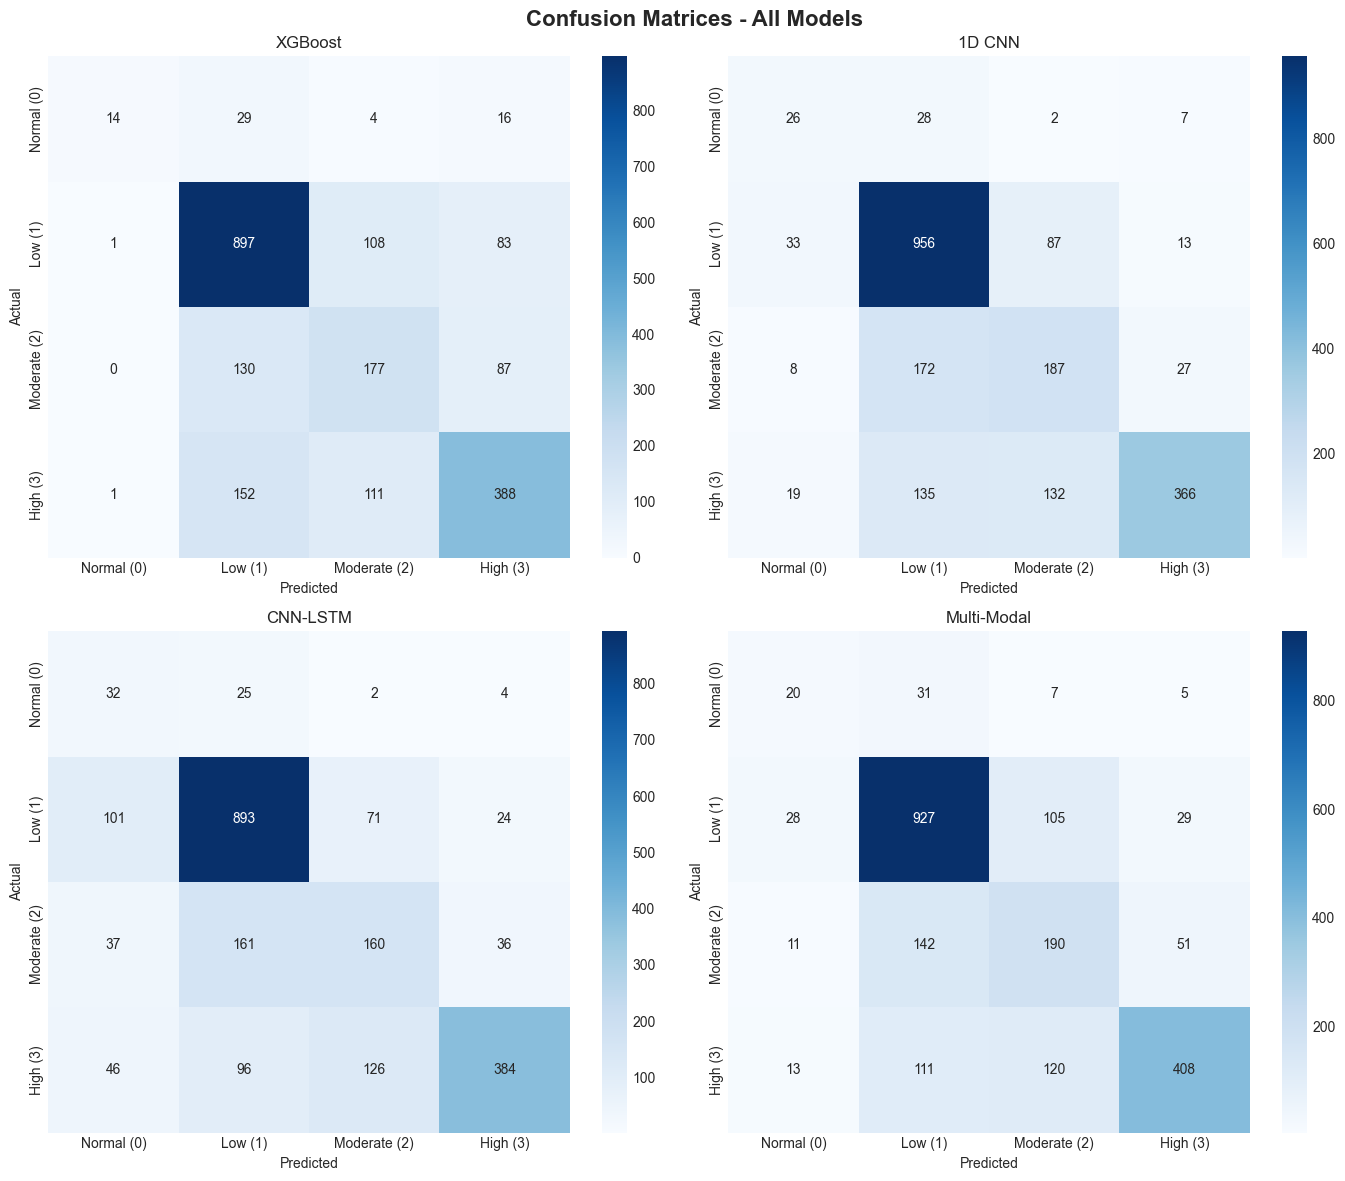

✓ Confusion matrices saved


In [65]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('Confusion Matrices - All Models', fontsize=16, fontweight='bold')

# Prepare data
models_data = [
    ('XGBoost', y_test, y_pred_xgb),
    ('1D CNN', y_true_cnn, y_pred_cnn),
    ('CNN-LSTM', y_true_lstm, y_pred_lstm),
    ('Multi-Modal', y_true_mm, y_pred_mm)
]

for idx, (name, y_true, y_pred) in enumerate(models_data):
    ax = axes[idx // 2, idx % 2]
    cm = confusion_matrix(y_true, y_pred)
    
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Blues',
        xticklabels=risk_labels,
        yticklabels=risk_labels,
        ax=ax
    )
    
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(f'{name}')

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['output_path'], 'confusion_matrices.png'), dpi=150, bbox_inches='tight')
plt.show()

print("✓ Confusion matrices saved")

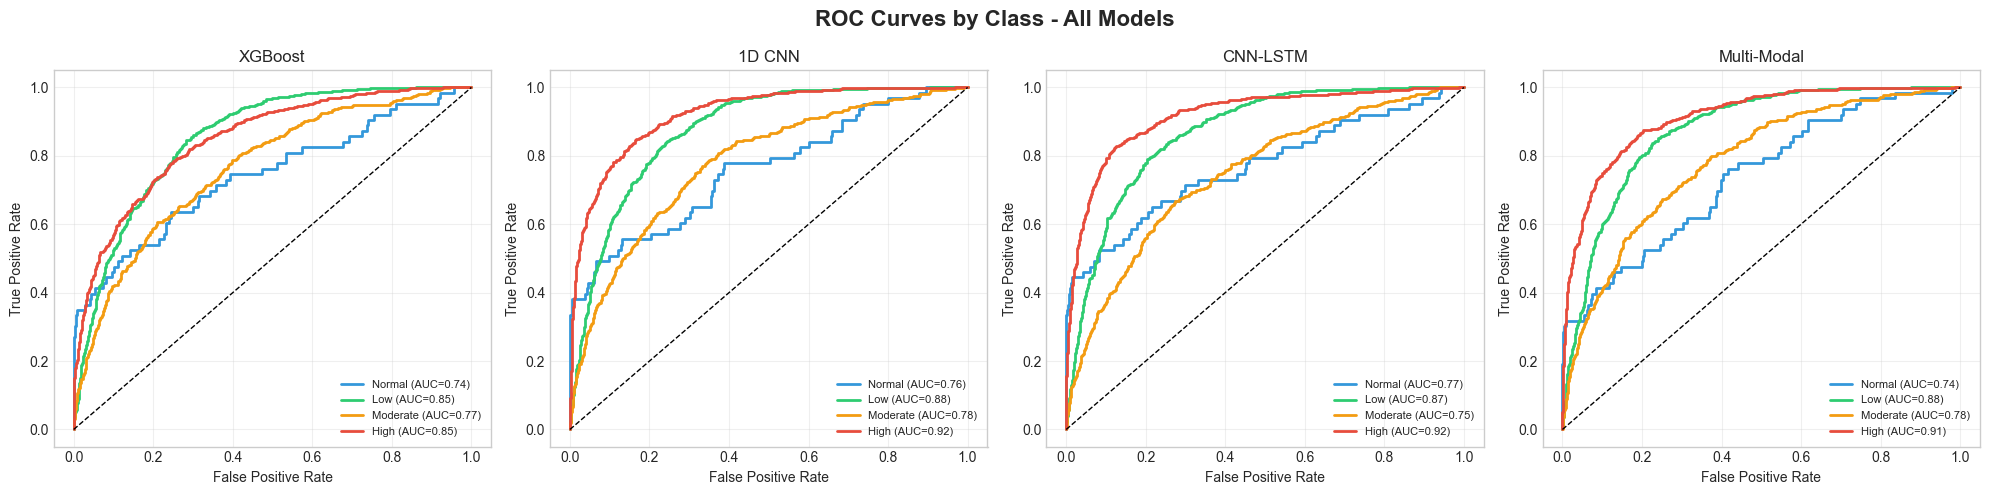

✓ ROC curves saved


In [66]:
from sklearn.preprocessing import label_binarize

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle('ROC Curves by Class - All Models', fontsize=16, fontweight='bold')

# Binarize labels for multi-class ROC
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])
y_true_cnn_bin = label_binarize(y_true_cnn, classes=[0, 1, 2, 3])
y_true_lstm_bin = label_binarize(y_true_lstm, classes=[0, 1, 2, 3])
y_true_mm_bin = label_binarize(y_true_mm, classes=[0, 1, 2, 3])

colors = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c']
class_names = ['Normal', 'Low', 'Moderate', 'High']

models_roc = [
    ('XGBoost', y_test_bin, y_pred_proba_xgb),
    ('1D CNN', y_true_cnn_bin, y_proba_cnn),
    ('CNN-LSTM', y_true_lstm_bin, y_proba_lstm),
    ('Multi-Modal', y_true_mm_bin, y_proba_mm)
]

for ax, (name, y_bin, y_proba) in zip(axes, models_roc):
    for i, (color, cls_name) in enumerate(zip(colors, class_names)):
        fpr, tpr, _ = roc_curve(y_bin[:, i], y_proba[:, i])
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, color=color, lw=2, label=f'{cls_name} (AUC={roc_auc:.2f})')
    
    ax.plot([0, 1], [0, 1], 'k--', lw=1)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'{name}')
    ax.legend(loc='lower right', fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['output_path'], 'roc_curves.png'), dpi=150, bbox_inches='tight')
plt.show()

print("✓ ROC curves saved")

# Section 11: Explainability (SHAP + GradCAM)

## What we're doing here:
This section explains model predictions using interpretability techniques:

1. **SHAP for XGBoost** - Feature importance and direction of effects
2. **GradCAM for CNN** - Visual attention on ECG signals
3. **Feature Analysis** - Understanding what drives predictions

### Why explainability matters:
- Clinical AI must be interpretable for trust and adoption
- SHAP shows which features increase/decrease risk
- GradCAM highlights which ECG regions the model focuses on
- Explanations validate that models learn clinically relevant patterns

In [56]:
print("Computing SHAP values for XGBoost...")
print("=" * 60)

# Create SHAP explainer
explainer = shap.TreeExplainer(xgb_model)

# Compute SHAP values for a subset of test data (for speed)
shap_sample_size = min(500, len(X_test_scaled))
X_shap = X_test_scaled[:shap_sample_size]
shap_values = explainer.shap_values(X_shap)

print(f"✓ SHAP values computed for {shap_sample_size} samples")
print(f"   SHAP values shape: {np.array(shap_values).shape}")

Computing SHAP values for XGBoost...
✓ SHAP values computed for 500 samples
   SHAP values shape: (500, 165, 4)


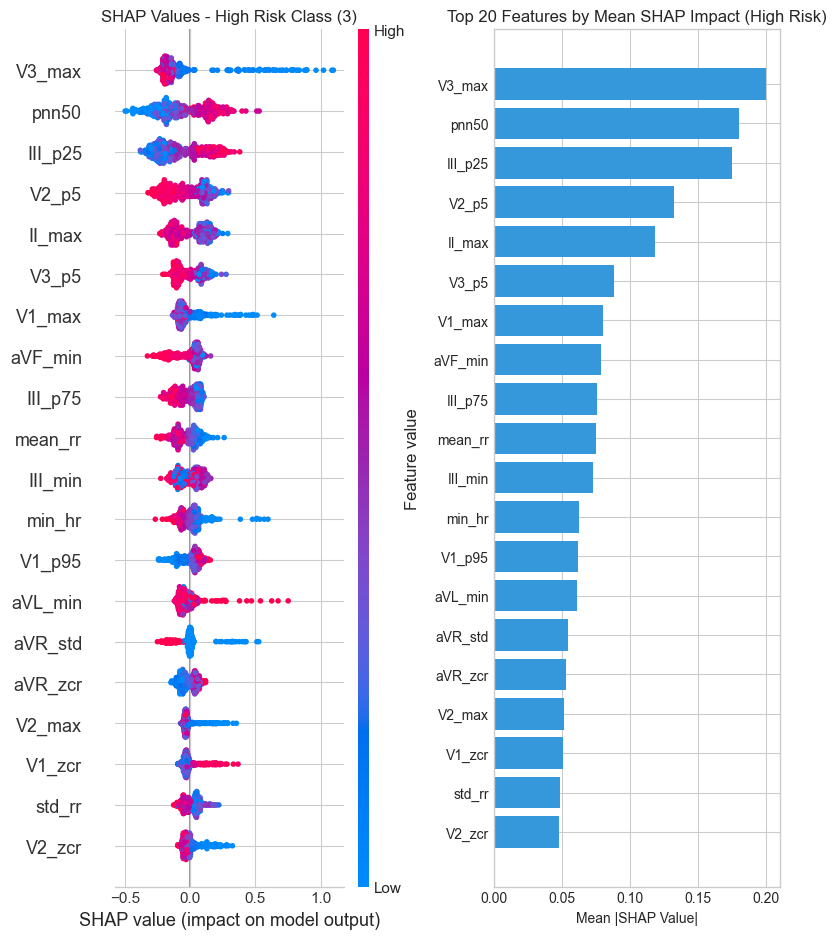

✓ SHAP summary saved


In [71]:
# For multi-class, SHAP returns a list of arrays (one per class)
# We'll plot for the high-risk class (class 3)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Summary plot for high-risk class
ax1 = axes[0]
plt.sca(ax1)
shap.summary_plot(
    shap_values[:,:,3], 
    X_shap, 
    feature_names=feature_names,
    plot_type='dot',
    color='#e74c3c',
    show=False
)
ax1.set_title('SHAP Values - High Risk Class (3)', fontsize=12)

# Bar plot showing mean absolute SHAP values
ax2 = axes[1]
mean_shap = np.abs(shap_values[:,:,3]).mean(axis=0)
top_indices = np.argsort(mean_shap)[-20:]
top_features = [feature_names[i] for i in top_indices]
top_values = mean_shap[top_indices]

ax2.barh(range(20), top_values, color='#3498db')
ax2.set_yticks(range(20))
ax2.set_yticklabels(top_features)
ax2.set_xlabel('Mean |SHAP Value|')
ax2.set_title('Top 20 Features by Mean SHAP Impact (High Risk)', fontsize=12)

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['output_path'], 'shap_summary.png'), dpi=150, bbox_inches='tight')
plt.show()

print("✓ SHAP summary saved")

In [72]:
class GradCAM1D:
    """
    Gradient-weighted Class Activation Mapping for 1D CNNs.
    
    Highlights which regions of the ECG signal the model focuses on
    when making predictions.
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # Register hooks
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_full_backward_hook(self.save_gradient)
    
    def save_activation(self, module, input, output):
        self.activations = output.detach()
    
    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()
    
    def compute_cam(self, input_tensor, target_class):
        """Compute GradCAM for the input."""
        self.model.eval()
        
        # Forward pass
        output = self.model(input_tensor)
        
        # Zero gradients
        self.model.zero_grad()
        
        # Backward pass for target class
        one_hot = torch.zeros_like(output)
        one_hot[0, target_class] = 1
        output.backward(gradient=one_hot, retain_graph=True)
        
        # Global average pooling of gradients
        weights = self.gradients.mean(dim=2, keepdim=True)
        
        # Weighted combination of activations
        cam = (weights * self.activations).sum(dim=1).squeeze()
        
        # ReLU
        cam = F.relu(cam)
        
        # Normalize
        cam = cam - cam.min()
        if cam.max() > 0:
            cam = cam / cam.max()
        
        return cam.cpu().numpy()


def plot_ecg_with_attention(ecg_signal, attention, predicted_class, true_class, save_path=None):
    """
    Plot ECG with GradCAM attention overlay.
    """
    fig, axes = plt.subplots(4, 3, figsize=(16, 12))
    fig.suptitle(f'GradCAM Attention Map\nPredicted: {risk_labels[predicted_class]} | Actual: {risk_labels[true_class]}', 
                 fontsize=14, fontweight='bold')
    
    time = np.arange(ecg_signal.shape[1]) / CONFIG['sampling_rate']
    
    # Upsample attention to match ECG length
    from scipy.ndimage import zoom
    attention_upsampled = zoom(attention, ecg_signal.shape[1] / len(attention))
    
    for i, (ax, lead_name) in enumerate(zip(axes.flat, LEAD_NAMES)):
        signal = ecg_signal[i, :]
        
        # Plot ECG
        ax.plot(time, signal, color='#2c3e50', linewidth=0.5, alpha=0.7)
        
        # Overlay attention as colored background
        ax.fill_between(time, signal.min(), signal.max(), 
                       where=attention_upsampled > 0.5,
                       alpha=0.3, color='#e74c3c', label='High attention')
        
        ax.set_ylabel(lead_name, fontsize=9, rotation=0, labelpad=15)
        ax.set_xlim(0, CONFIG['duration'])
        ax.grid(True, alpha=0.3)
        
        if i >= 9:
            ax.set_xlabel('Time (s)')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    
    plt.show()
    return fig

print("✓ GradCAM class defined")

✓ GradCAM class defined


Generating GradCAM visualizations...


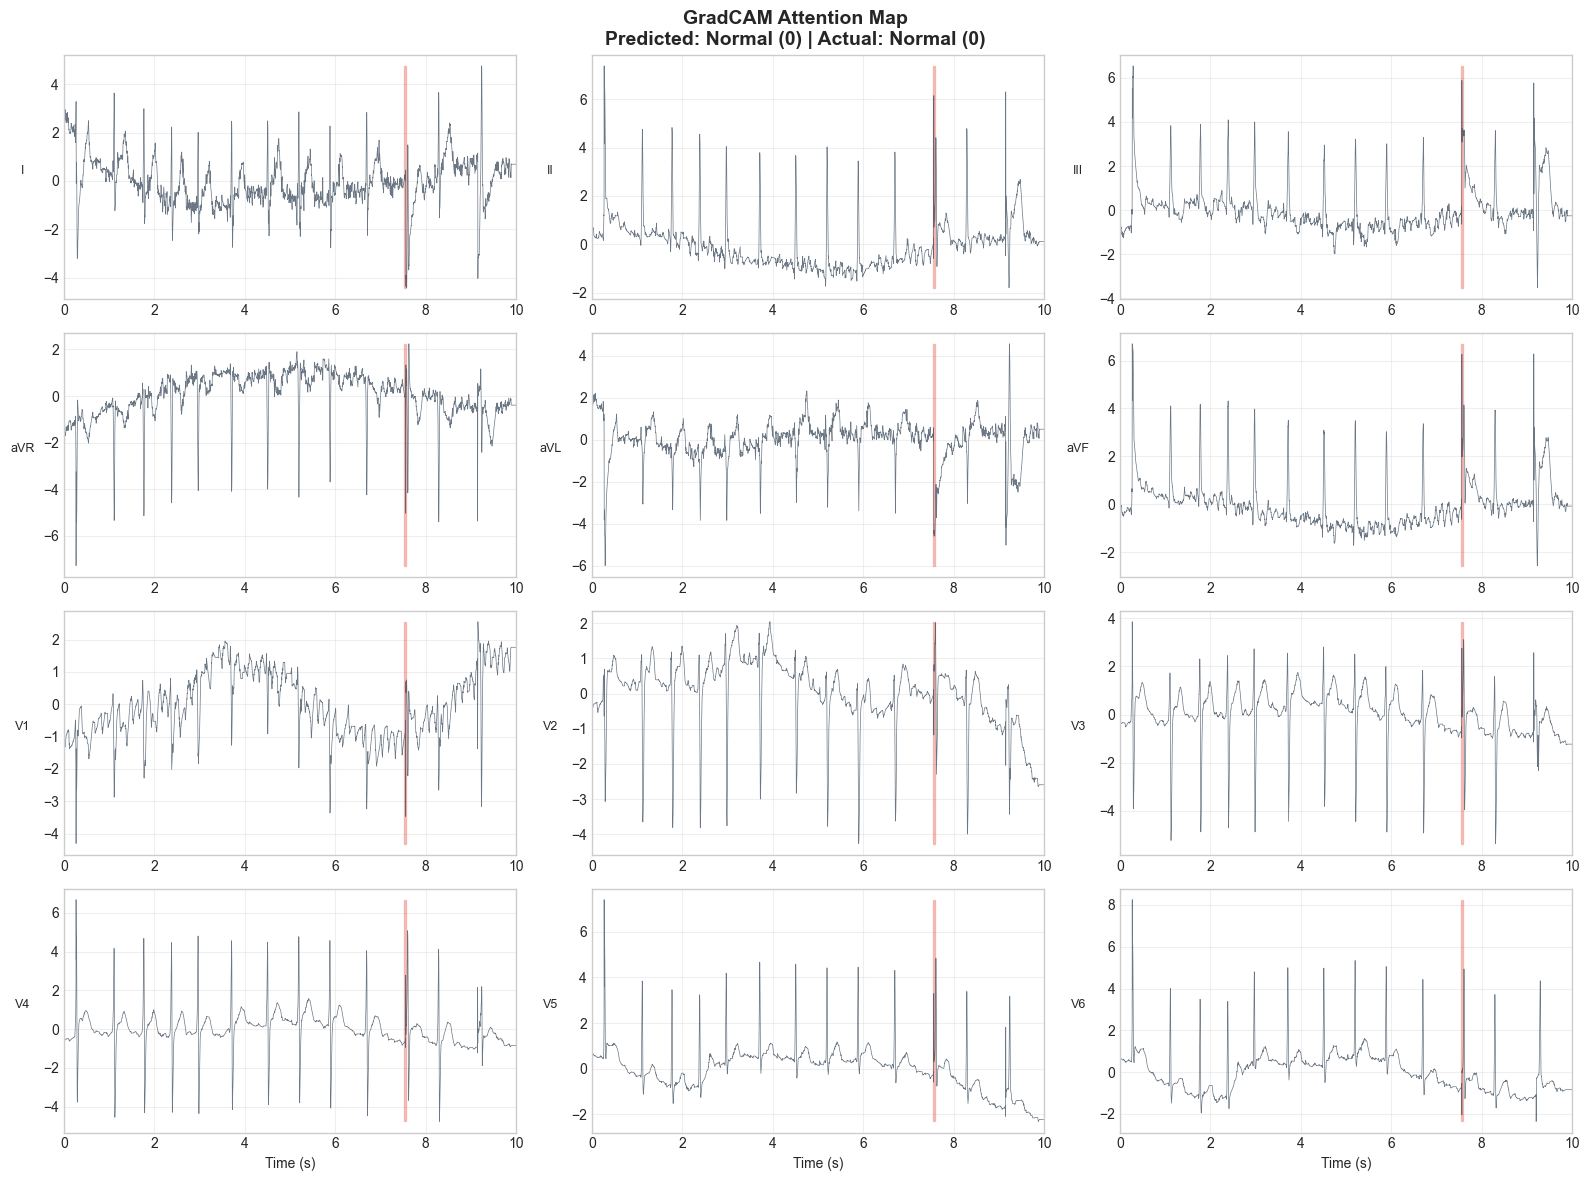

Class 0 (Normal (0)): Predicted Normal (0)


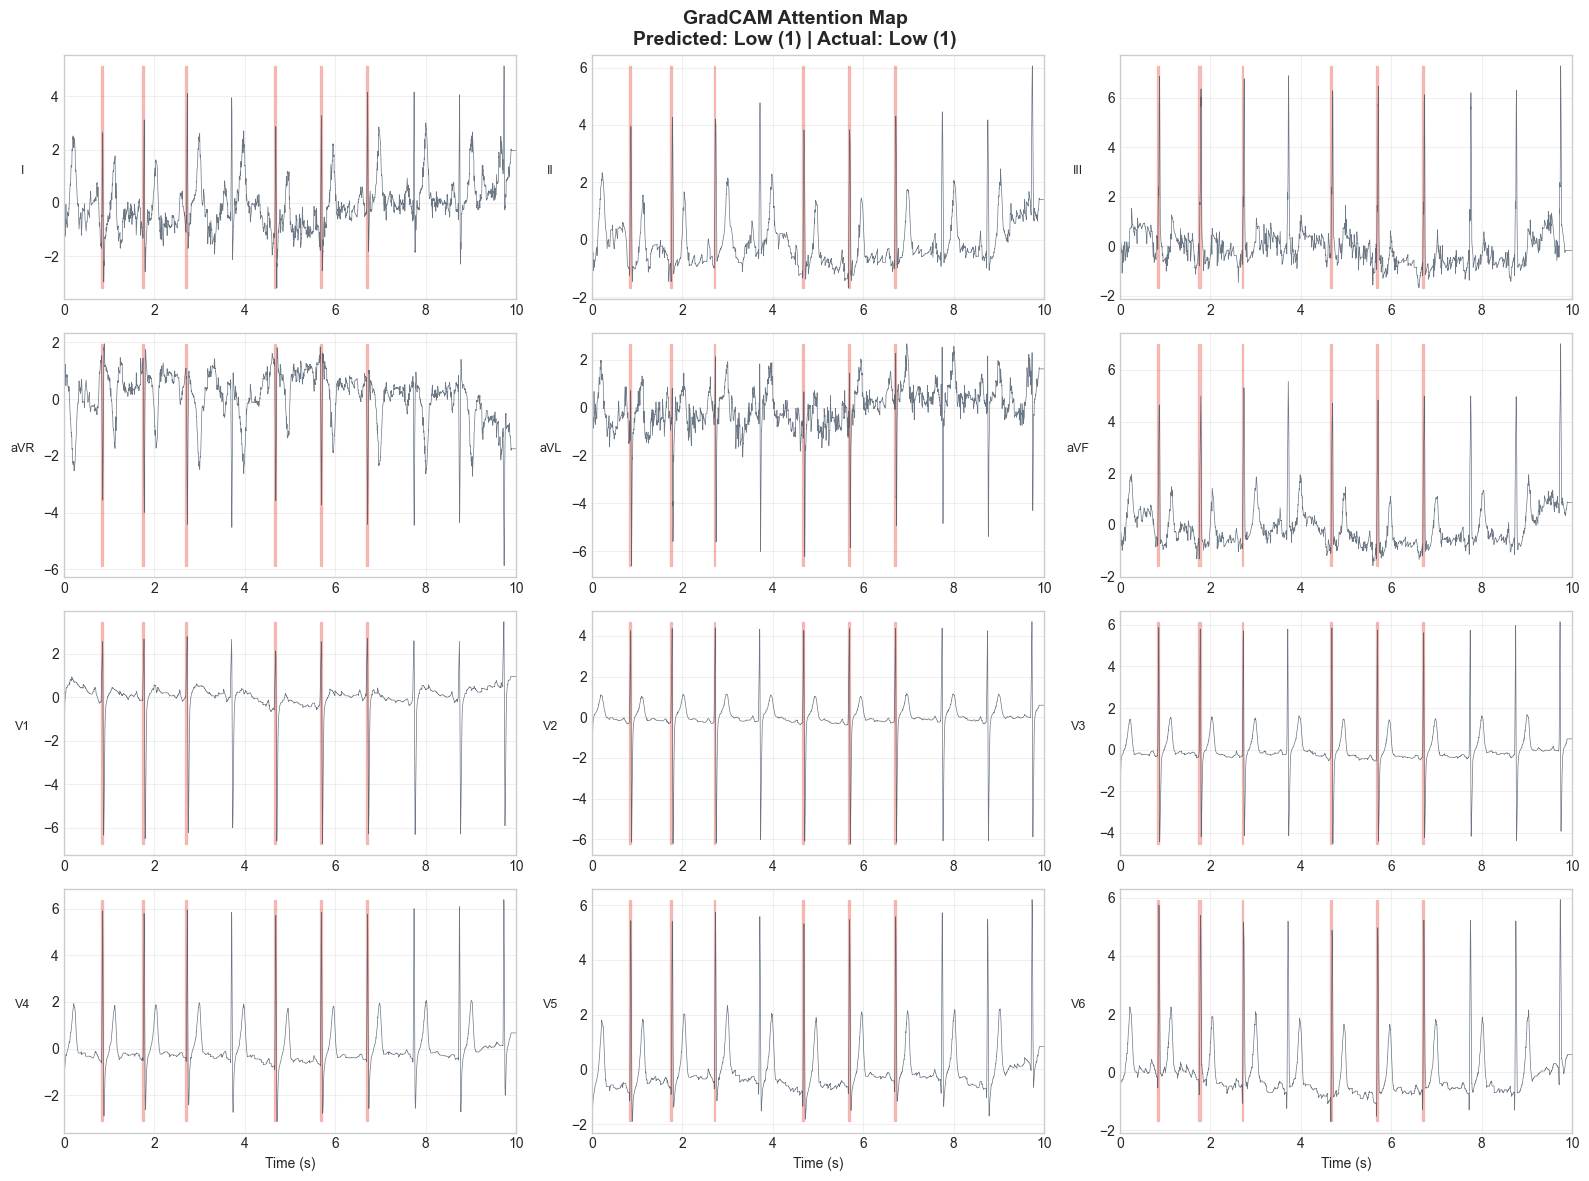

Class 1 (Low (1)): Predicted Low (1)


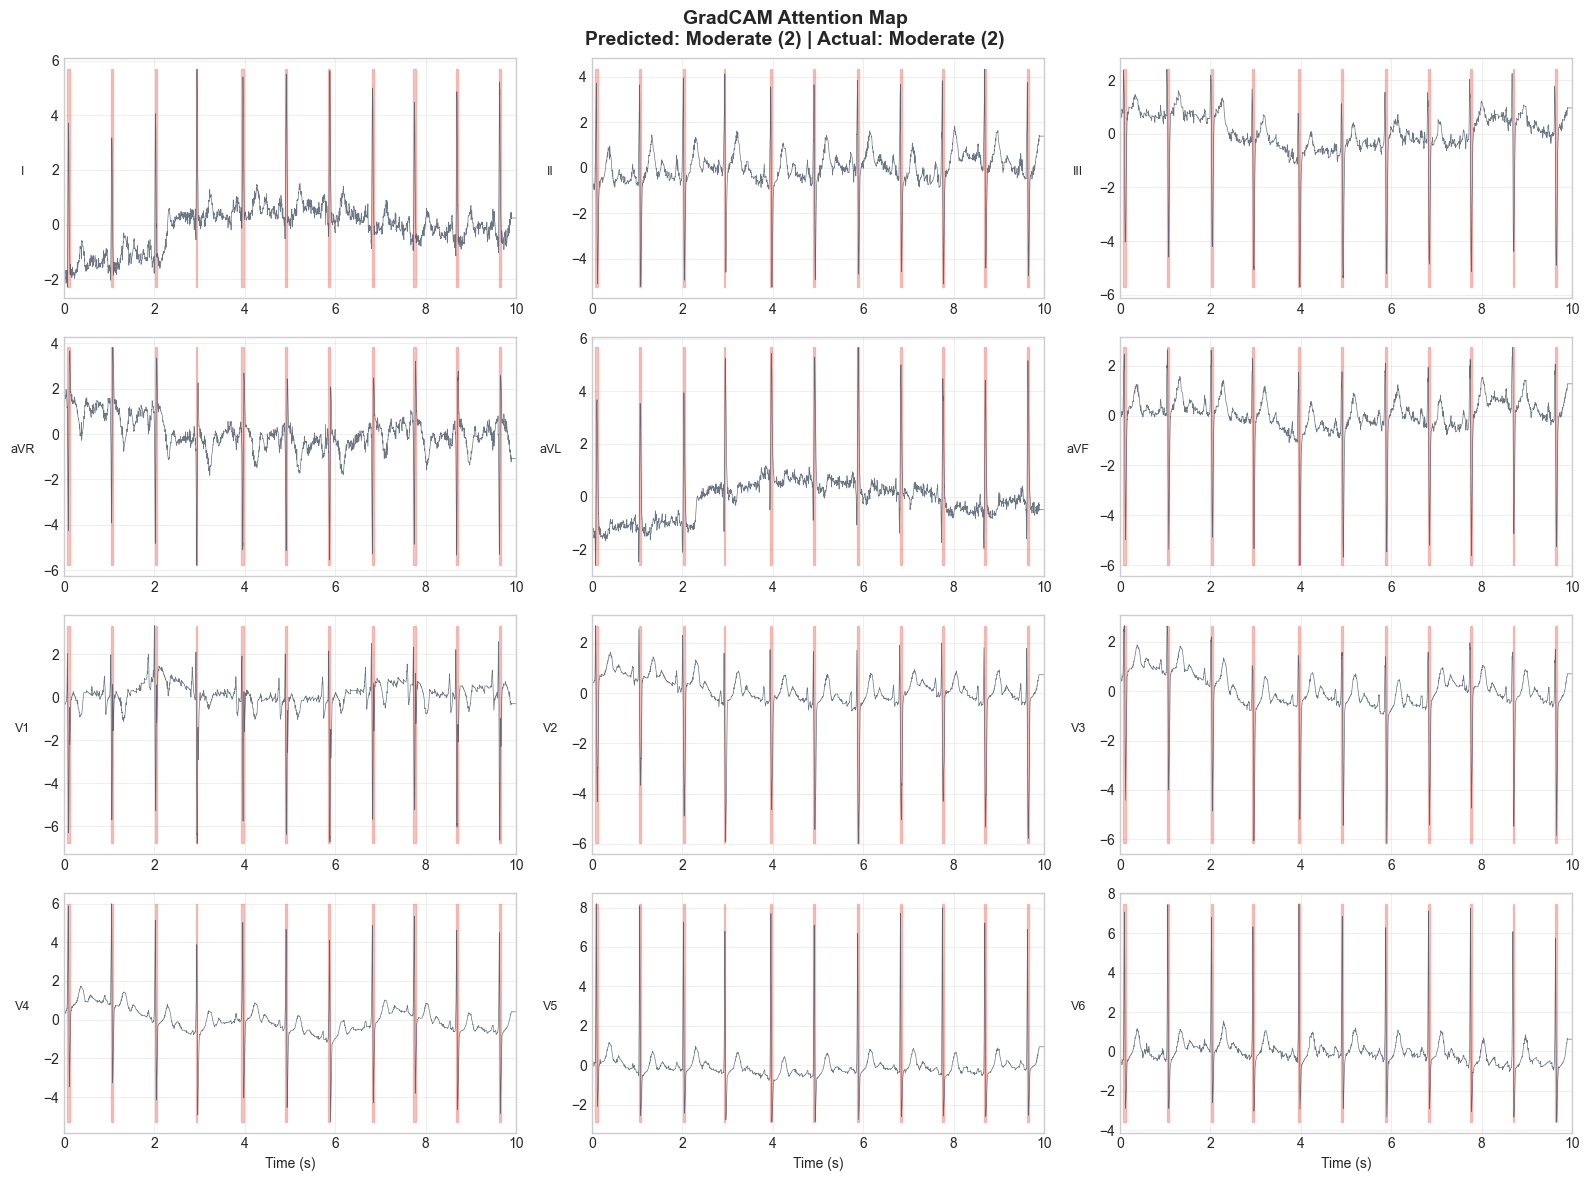

Class 2 (Moderate (2)): Predicted Moderate (2)


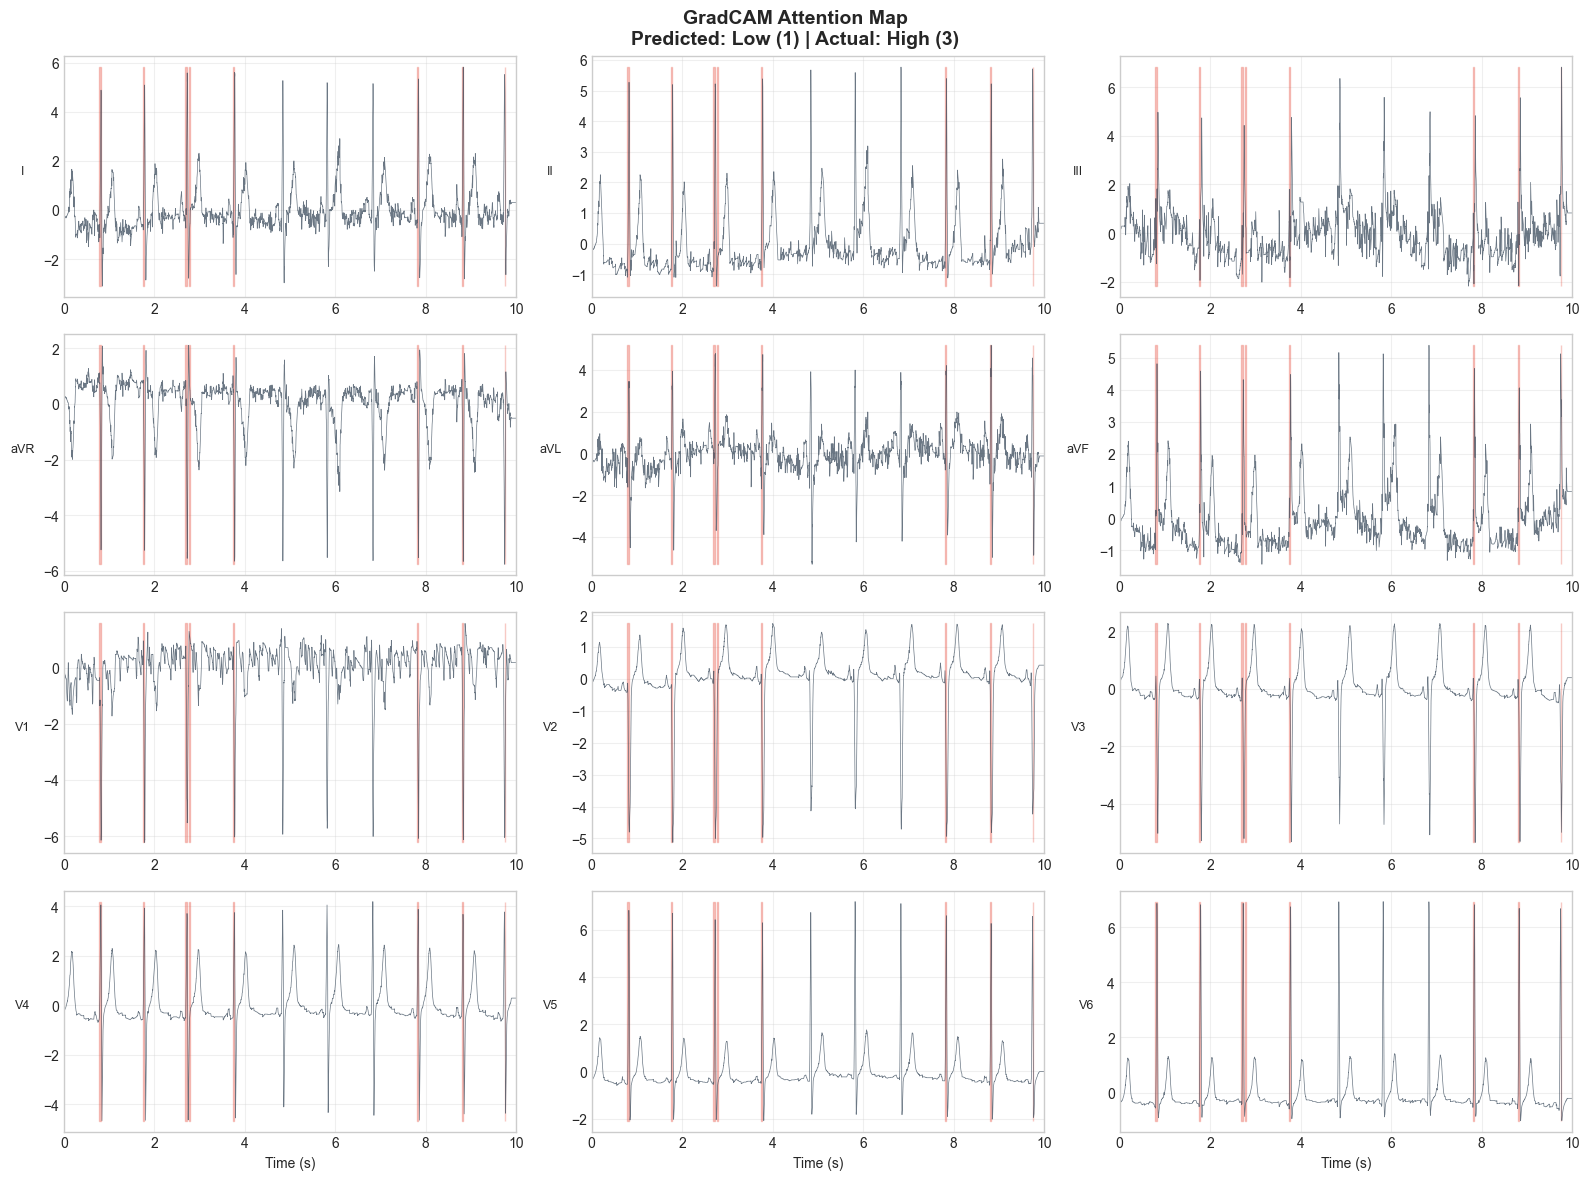

Class 3 (High (3)): Predicted Low (1)

✓ GradCAM visualizations saved


In [73]:
# Initialize GradCAM with the last conv layer
gradcam = GradCAM1D(cnn_model, cnn_model.conv4[0])  # Target the Conv1d in conv4

# Get sample ECGs from test set (one per risk category)
print("Generating GradCAM visualizations...")
print("=" * 60)

# Find samples for each risk class
samples_per_class = {}
for batch_idx, (ecg, label) in enumerate(test_loader):
    for i in range(len(label)):
        cls = label[i].item()
        if cls not in samples_per_class:
            samples_per_class[cls] = (ecg[i], cls)
        if len(samples_per_class) == 4:
            break
    if len(samples_per_class) == 4:
        break

# Generate GradCAM for each sample
for cls in sorted(samples_per_class.keys()):
    ecg_tensor, true_label = samples_per_class[cls]
    ecg_tensor = ecg_tensor.unsqueeze(0).to(DEVICE)
    
    # Get prediction
    with torch.no_grad():
        output = cnn_model(ecg_tensor)
        pred_class = output.argmax(dim=1).item()
    
    # Compute GradCAM
    attention = gradcam.compute_cam(ecg_tensor, pred_class)
    
    # Plot
    ecg_np = ecg_tensor.squeeze().cpu().numpy()
    save_path = os.path.join(CONFIG['output_path'], f'gradcam_class_{cls}.png')
    plot_ecg_with_attention(ecg_np, attention, pred_class, true_label, save_path)
    
    print(f"Class {cls} ({risk_labels[cls]}): Predicted {risk_labels[pred_class]}")

print("\n✓ GradCAM visualizations saved")

# Section 12: Clinical Feature Synthesis

## What we're doing here:
PTB-XL only has basic demographics. We'll generate clinically plausible synthetic features for demonstration:

1. **Vital Signs** - Blood pressure, heart rate
2. **Lab Values** - Cholesterol, glucose, HbA1c
3. **Comorbidities** - Diabetes, hypertension, smoking status

### Important note:
These are **synthetic features** for demonstration purposes only. In a real clinical system, these would come from electronic health records.

In [74]:
def generate_clinical_features(row):
    """
    Generate synthetic but clinically plausible features based on ECG findings.
    Uses consistent random seed based on ecg_id for reproducibility.
    """
    np.random.seed(int(row.name) % 2**31)  # Use ecg_id as seed
    
    features = {}
    
    # Get risk factors
    ecg_risk = row.get('ecg_risk_score', 1)
    age = row.get('age', 60)
    is_male = row.get('sex', 0) == 0
    
    # Check for specific diagnoses
    scp_codes = row.get('scp_codes', {})
    has_mi = any(code in scp_codes for code in ['AMI', 'IMI', 'ASMI', 'LMI', 'PMI'])
    has_afib = any(code in scp_codes for code in ['AFIB', 'AFLT'])
    has_lvh = 'LVH' in scp_codes
    
    # ----- Vital Signs -----
    # Systolic BP: Higher if LVH or high risk
    base_sbp = 120 + (age - 50) * 0.3
    if has_lvh:
        base_sbp += 15
    if ecg_risk >= 2:
        base_sbp += 10
    features['systolic_bp'] = int(np.clip(base_sbp + np.random.normal(0, 10), 90, 180))
    
    # Diastolic BP
    features['diastolic_bp'] = int(np.clip(features['systolic_bp'] * 0.6 + np.random.normal(0, 5), 60, 110))
    
    # Heart rate (use a base value if we don't have extracted HR)
    features['resting_hr'] = int(np.clip(72 + np.random.normal(0, 12), 50, 100))
    if has_afib:
        features['resting_hr'] = int(np.clip(90 + np.random.normal(0, 20), 60, 150))
    
    # ----- Lab Values -----
    # Total cholesterol
    base_chol = 180 + (age - 40) * 0.5
    if has_mi:
        base_chol += 30
    features['total_cholesterol'] = int(np.clip(base_chol + np.random.normal(0, 25), 120, 300))
    
    # LDL cholesterol
    features['ldl_cholesterol'] = int(np.clip(features['total_cholesterol'] * 0.6 + np.random.normal(0, 15), 50, 200))
    
    # HDL cholesterol
    base_hdl = 55 if is_male else 65
    features['hdl_cholesterol'] = int(np.clip(base_hdl + np.random.normal(0, 10), 30, 90))
    
    # Triglycerides
    features['triglycerides'] = int(np.clip(120 + np.random.normal(0, 40), 50, 300))
    
    # Fasting glucose
    base_glucose = 95
    if ecg_risk >= 2:
        base_glucose += 15
    features['fasting_glucose'] = int(np.clip(base_glucose + np.random.normal(0, 15), 70, 180))
    
    # HbA1c
    features['hba1c'] = round(np.clip(5.5 + (features['fasting_glucose'] - 100) * 0.02 + np.random.normal(0, 0.3), 4.5, 10), 1)
    
    # ----- Comorbidities -----
    # Hypertension
    features['has_hypertension'] = int(features['systolic_bp'] >= 140 or np.random.random() < 0.2)
    
    # Diabetes
    features['has_diabetes'] = int(features['fasting_glucose'] >= 126 or np.random.random() < 0.15)
    
    # Prior MI
    features['has_prior_mi'] = int(has_mi)
    
    # Smoking
    smoking_prob = 0.15 if is_male else 0.10
    if has_mi:
        smoking_prob += 0.1
    features['is_current_smoker'] = int(np.random.random() < smoking_prob)
    
    # Family history
    features['has_family_history'] = int(np.random.random() < 0.25)
    
    # Obesity
    if pd.notna(row.get('height')) and pd.notna(row.get('weight')):
        bmi = row['weight'] / ((row['height'] / 100) ** 2)
        features['is_obese'] = int(bmi >= 30)
    else:
        features['is_obese'] = int(np.random.random() < 0.3)
    
    return pd.Series(features)

# Apply to test set
print("Generating synthetic clinical features...")
clinical_features = test_df.apply(generate_clinical_features, axis=1)
test_df_clinical = pd.concat([test_df, clinical_features], axis=1)

print(f"✓ Generated {len(clinical_features.columns)} clinical features for {len(test_df)} patients")
print(f"\nSample clinical profile:")
print(test_df_clinical[clinical_features.columns].iloc[0])

Generating synthetic clinical features...
✓ Generated 15 clinical features for 2198 patients

Sample clinical profile:
systolic_bp           121.0
diastolic_bp           71.0
resting_hr             58.0
total_cholesterol     187.0
ldl_cholesterol       106.0
hdl_cholesterol        50.0
triglycerides          59.0
fasting_glucose        87.0
hba1c                   5.2
has_hypertension        1.0
has_diabetes            0.0
has_prior_mi            0.0
is_current_smoker       0.0
has_family_history      1.0
is_obese                0.0
Name: 9, dtype: float64


# Section 13: Intervention Recommendation System

## What we're doing here:
Building a rule-based system that provides personalized intervention recommendations:

1. **ECG-based recommendations** - Based on detected abnormalities
2. **Vital signs recommendations** - BP and heart rate management
3. **Lab-based recommendations** - Cholesterol and glucose control
4. **Lifestyle recommendations** - Smoking cessation, exercise, diet

### Clinical value:
Translates risk predictions into actionable clinical guidance.

In [75]:
def generate_recommendations(patient_data):
    """
    Generate personalized intervention recommendations based on patient data.
    
    Returns a dictionary with categorized recommendations:
    - immediate: Urgent actions needed
    - medication: Drug therapy recommendations
    - lifestyle: Behavioral modifications
    - monitoring: Follow-up and testing
    - referral: Specialist consultations
    """
    recommendations = {
        'immediate': [],
        'medication': [],
        'lifestyle': [],
        'monitoring': [],
        'referral': []
    }
    
    scp_codes = patient_data.get('scp_codes', {})
    ecg_risk = patient_data.get('ecg_risk_score', 1)
    
    # ----- ECG-Based Recommendations -----
    
    # Atrial fibrillation
    if any(code in scp_codes for code in ['AFIB', 'AFLT']):
        recommendations['immediate'].append({
            'action': 'Assess stroke risk using CHA2DS2-VASc score',
            'urgency': 'high',
            'reason': 'Atrial fibrillation detected on ECG'
        })
        recommendations['medication'].append({
            'action': 'Consider anticoagulation therapy (DOAC or warfarin)',
            'urgency': 'high',
            'reason': 'Stroke prevention in atrial fibrillation'
        })
        recommendations['referral'].append({
            'action': 'Cardiology consultation for rhythm management',
            'urgency': 'medium',
            'reason': 'Rate vs rhythm control strategy'
        })
    
    # Myocardial infarction
    if any(code in scp_codes for code in ['AMI', 'IMI', 'ASMI', 'LMI', 'PMI']):
        recommendations['immediate'].append({
            'action': 'Urgent cardiology evaluation',
            'urgency': 'critical',
            'reason': 'Myocardial infarction pattern detected'
        })
        recommendations['medication'].append({
            'action': 'Dual antiplatelet therapy (aspirin + P2Y12 inhibitor)',
            'urgency': 'high',
            'reason': 'Secondary prevention post-MI'
        })
        recommendations['medication'].append({
            'action': 'High-intensity statin therapy',
            'urgency': 'high',
            'reason': 'LDL reduction for secondary prevention'
        })
        recommendations['lifestyle'].append({
            'action': 'Cardiac rehabilitation program',
            'urgency': 'medium',
            'reason': 'Improve functional capacity and reduce recurrence'
        })
    
    # Left ventricular hypertrophy
    if 'LVH' in scp_codes:
        recommendations['medication'].append({
            'action': 'Optimize blood pressure control (target <130/80)',
            'urgency': 'medium',
            'reason': 'Left ventricular hypertrophy requires aggressive BP management'
        })
        recommendations['monitoring'].append({
            'action': 'Echocardiogram to assess cardiac structure',
            'urgency': 'medium',
            'reason': 'Evaluate LV mass and function'
        })
    
    # ----- Vital Signs Recommendations -----
    
    # Hypertension
    if patient_data.get('systolic_bp', 120) >= 140 or patient_data.get('diastolic_bp', 80) >= 90:
        recommendations['medication'].append({
            'action': 'Initiate or optimize antihypertensive therapy',
            'urgency': 'medium',
            'reason': f"Blood pressure elevated ({patient_data.get('systolic_bp', 'N/A')}/{patient_data.get('diastolic_bp', 'N/A')} mmHg)"
        })
        recommendations['lifestyle'].append({
            'action': 'DASH diet and sodium restriction (<2300mg/day)',
            'urgency': 'low',
            'reason': 'Dietary modification for blood pressure control'
        })
    
    # ----- Lab Value Recommendations -----
    
    # Elevated LDL
    ldl = patient_data.get('ldl_cholesterol', 100)
    if ldl >= 130 or (ecg_risk >= 2 and ldl >= 100):
        recommendations['medication'].append({
            'action': 'Statin therapy for LDL reduction',
            'urgency': 'medium',
            'reason': f"LDL cholesterol elevated ({ldl} mg/dL)"
        })
        recommendations['lifestyle'].append({
            'action': 'Mediterranean diet and increased soluble fiber',
            'urgency': 'low',
            'reason': 'Dietary cholesterol management'
        })
    
    # Elevated glucose/diabetes
    glucose = patient_data.get('fasting_glucose', 95)
    hba1c = patient_data.get('hba1c', 5.5)
    if glucose >= 126 or hba1c >= 6.5:
        recommendations['medication'].append({
            'action': 'Consider metformin or other glucose-lowering therapy',
            'urgency': 'medium',
            'reason': f"Elevated glucose ({glucose} mg/dL) or HbA1c ({hba1c}%)"
        })
        recommendations['lifestyle'].append({
            'action': 'Carbohydrate management and weight loss',
            'urgency': 'medium',
            'reason': 'Glycemic control through lifestyle'
        })
        recommendations['monitoring'].append({
            'action': 'Quarterly HbA1c monitoring',
            'urgency': 'medium',
            'reason': 'Track glycemic control'
        })
    
    # ----- Lifestyle Recommendations -----
    
    # Smoking
    if patient_data.get('is_current_smoker', 0) == 1:
        recommendations['immediate'].append({
            'action': 'Smoking cessation counseling',
            'urgency': 'high',
            'reason': 'Smoking is a major modifiable cardiovascular risk factor'
        })
        recommendations['medication'].append({
            'action': 'Consider nicotine replacement or varenicline',
            'urgency': 'medium',
            'reason': 'Pharmacotherapy improves quit rates'
        })
    
    # Obesity
    if patient_data.get('is_obese', 0) == 1:
        recommendations['lifestyle'].append({
            'action': 'Weight loss program (target 5-10% body weight)',
            'urgency': 'medium',
            'reason': 'Obesity is associated with increased cardiovascular risk'
        })
        recommendations['referral'].append({
            'action': 'Dietitian consultation',
            'urgency': 'low',
            'reason': 'Structured dietary guidance'
        })
    
    # General recommendations for high-risk patients
    if ecg_risk >= 2:
        recommendations['monitoring'].append({
            'action': 'Regular cardiovascular follow-up (every 3-6 months)',
            'urgency': 'medium',
            'reason': 'Close monitoring for high-risk ECG findings'
        })
        recommendations['lifestyle'].append({
            'action': 'Moderate aerobic exercise (150 min/week)',
            'urgency': 'low',
            'reason': 'Cardiovascular conditioning'
        })
    
    return recommendations

print("✓ Intervention recommendation system defined")

✓ Intervention recommendation system defined


In [ ]:
# Evidence-based risk reduction estimates (from clinical trials)
INTERVENTION_EFFECTS = {
    'smoking_cessation': 0.50,       # 50% relative risk reduction
    'statin_therapy': 0.25,          # 25% reduction in MACE
    'bp_control': 0.20,              # 20% reduction per 10mmHg
    'diabetes_control': 0.15,        # 15% reduction
    'weight_loss': 0.15,             # 15% reduction with 5-10% weight loss
    'exercise_program': 0.10,        # 10% reduction
    'diet_modification': 0.10,       # 10% reduction
    'anticoagulation': 0.60,         # 60% stroke reduction in AFib
}

def estimate_risk_reduction(current_risk, recommendations):
    """
    Estimate risk reduction based on recommended interventions.
    Uses multiplicative model (not additive) to avoid going below zero.
    """
    remaining_risk = current_risk
    intervention_impacts = []
    
    # Map recommendations to interventions
    all_recs = []
    for category, recs in recommendations.items():
        all_recs.extend(recs)
    
    for rec in all_recs:
        action = rec['action'].lower()
        reduction = 0
        intervention_name = None
        
        if 'smoking' in action or 'cessation' in action:
            reduction = INTERVENTION_EFFECTS['smoking_cessation']
            intervention_name = 'Smoking cessation'
        elif 'statin' in action:
            reduction = INTERVENTION_EFFECTS['statin_therapy']
            intervention_name = 'Statin therapy'
        elif 'blood pressure' in action or 'antihypertensive' in action:
            reduction = INTERVENTION_EFFECTS['bp_control']
            intervention_name = 'Blood pressure control'
        elif 'metformin' in action or 'glucose' in action:
            reduction = INTERVENTION_EFFECTS['diabetes_control']
            intervention_name = 'Diabetes management'
        elif 'weight' in action:
            reduction = INTERVENTION_EFFECTS['weight_loss']
            intervention_name = 'Weight loss'
        elif 'exercise' in action:
            reduction = INTERVENTION_EFFECTS['exercise_program']
            intervention_name = 'Exercise program'
        elif 'diet' in action or 'mediterranean' in action:
            reduction = INTERVENTION_EFFECTS['diet_modification']
            intervention_name = 'Diet modification'
        elif 'anticoagula' in action:
            reduction = INTERVENTION_EFFECTS['anticoagulation']
            intervention_name = 'Anticoagulation'
        
        if reduction > 0 and intervention_name:
            # Avoid duplicate interventions
            if intervention_name not in [i['name'] for i in intervention_impacts]:
                risk_before = remaining_risk
                remaining_risk = remaining_risk * (1 - reduction)
                intervention_impacts.append({
                    'name': intervention_name,
                    'reduction_pct': reduction * 100,
                    'absolute_impact': risk_before - remaining_risk
                })
    
    # Cap at 70% maximum reduction
    max_reduction = current_risk * 0.70
    if current_risk - remaining_risk > max_reduction:
        remaining_risk = current_risk - max_reduction
    
    return {
        'current_risk': current_risk,
        'projected_risk': remaining_risk,
        'absolute_reduction': current_risk - remaining_risk,
        'relative_reduction': (current_risk - remaining_risk) / current_risk * 100 if current_risk > 0 else 0,
        'interventions': intervention_impacts
    }

print("✓ Risk reduction estimation defined")

✓ Risk reduction estimation defined


In [ ]:
def generate_patient_report(patient_id, patient_data, model_prediction, recommendations, risk_reduction):
    """
    Generate a comprehensive patient report in markdown format.
    """
    report = []
    
    # Header
    report.append("# HeartGuard Patient Risk Assessment Report")
    report.append(f"\n**Patient ID:** {patient_id}")
    report.append(f"**Report Date:** {datetime.now().strftime('%Y-%m-%d %H:%M')}")
    report.append("\n---")
    
    # Demographics
    report.append("\n## Patient Demographics")
    age = patient_data.get('age', 'N/A')
    sex = 'Female' if patient_data.get('sex', 0) == 1 else 'Male'
    report.append(f"- **Age:** {age} years")
    report.append(f"- **Sex:** {sex}")
    
    # ECG Summary
    report.append("\n## ECG Analysis Summary")
    scp_codes = list(patient_data.get('scp_codes', {}).keys())
    report.append(f"- **Diagnoses detected:** {', '.join(scp_codes[:5])}")
    report.append(f"- **ECG Risk Score:** {patient_data.get('ecg_risk_score', 'N/A')}/3")
    
    # Clinical Profile
    report.append("\n## Clinical Profile")
    report.append("\n### Vital Signs")
    report.append(f"- Blood Pressure: {patient_data.get('systolic_bp', 'N/A')}/{patient_data.get('diastolic_bp', 'N/A')} mmHg")
    report.append(f"- Resting Heart Rate: {patient_data.get('resting_hr', 'N/A')} bpm")
    
    report.append("\n### Laboratory Values")
    report.append(f"- Total Cholesterol: {patient_data.get('total_cholesterol', 'N/A')} mg/dL")
    report.append(f"- LDL Cholesterol: {patient_data.get('ldl_cholesterol', 'N/A')} mg/dL")
    report.append(f"- HDL Cholesterol: {patient_data.get('hdl_cholesterol', 'N/A')} mg/dL")
    report.append(f"- Fasting Glucose: {patient_data.get('fasting_glucose', 'N/A')} mg/dL")
    report.append(f"- HbA1c: {patient_data.get('hba1c', 'N/A')}%")
    
    # Risk Assessment
    report.append("\n## Risk Assessment")
    risk_category = patient_data.get('risk_category', 'Unknown')
    composite_risk = patient_data.get('composite_risk', 0)
    report.append(f"- **Overall Risk Category:** {risk_category}")
    report.append(f"- **Composite Risk Score:** {composite_risk:.2f} (0-1 scale)")
    report.append(f"- **Model Prediction:** {risk_labels[model_prediction]}")
    
    # Intervention Plan
    report.append("\n## Intervention Plan")
    
    if recommendations['immediate']:
        report.append("\n### Immediate Actions")
        for rec in recommendations['immediate']:
            report.append(f"- **[{rec['urgency'].upper()}]** {rec['action']}")
            report.append(f"  - *Reason:* {rec['reason']}")
    
    if recommendations['medication']:
        report.append("\n### Medication Recommendations")
        for rec in recommendations['medication']:
            report.append(f"- {rec['action']}")
            report.append(f"  - *Reason:* {rec['reason']}")
    
    if recommendations['lifestyle']:
        report.append("\n### Lifestyle Modifications")
        for rec in recommendations['lifestyle']:
            report.append(f"- {rec['action']}")
    
    if recommendations['monitoring']:
        report.append("\n### Monitoring Schedule")
        for rec in recommendations['monitoring']:
            report.append(f"- {rec['action']}")
    
    if recommendations['referral']:
        report.append("\n### Specialist Referrals")
        for rec in recommendations['referral']:
            report.append(f"- {rec['action']}")
    
    # Risk Projection
    report.append("\n## Risk Projection")
    report.append(f"- **Current Risk Score:** {risk_reduction['current_risk']:.3f}")
    report.append(f"- **Projected Risk (with interventions):** {risk_reduction['projected_risk']:.3f}")
    report.append(f"- **Expected Reduction:** {risk_reduction['relative_reduction']:.1f}%")
    
    if risk_reduction['interventions']:
        report.append("\n### Expected Impact by Intervention")
        for intervention in risk_reduction['interventions']:
            report.append(f"- {intervention['name']}: {intervention['reduction_pct']:.0f}% relative reduction")
    
    # Footer
    report.append("\n---")
    report.append("\n*This report is generated by HeartGuard AI and should be reviewed by a qualified healthcare professional.*")
    report.append("\n*Synthetic clinical data used for demonstration purposes.*")
    
    return '\n'.join(report)

print("✓ Patient report generation defined")

✓ Patient report generation defined


In [78]:
print("Generating sample patient reports...")
print("=" * 60)

# Find samples for each risk category
risk_categories = ['Low', 'Moderate', 'High']
sample_reports = {}

for category in risk_categories:
    # Find a patient in this category
    mask = test_df_clinical['risk_category'] == category
    if mask.any():
        idx = test_df_clinical[mask].index[0]
        patient_data = test_df_clinical.loc[idx].to_dict()
        
        # Get model prediction (from XGBoost)
        patient_idx = list(X_test.index).index(idx)
        model_pred = y_pred_xgb[patient_idx]
        
        # Generate recommendations
        recommendations = generate_recommendations(patient_data)
        
        # Estimate risk reduction
        current_risk = patient_data.get('composite_risk', 0.5)
        risk_reduction = estimate_risk_reduction(current_risk, recommendations)
        
        # Generate report
        report = generate_patient_report(idx, patient_data, model_pred, recommendations, risk_reduction)
        sample_reports[category] = report
        
        # Save report
        report_path = os.path.join(CONFIG['output_path'], f'patient_report_{category.lower()}_risk.md')
        with open(report_path, 'w') as f:
            f.write(report)
        
        print(f"✓ {category} risk report saved: {report_path}")

print("\n" + "=" * 60)
print("Sample High-Risk Patient Report:")
print("=" * 60)
print(sample_reports.get('High', 'No high-risk patient found')[:2000] + "...")

Generating sample patient reports...
✓ Low risk report saved: outputs/patient_report_low_risk.md
✓ Moderate risk report saved: outputs/patient_report_moderate_risk.md
✓ High risk report saved: outputs/patient_report_high_risk.md

Sample High-Risk Patient Report:
# HeartGuard Patient Risk Assessment Report

**Patient ID:** 63
**Report Date:** 2026-01-25 13:37

---

## Patient Demographics
- **Age:** 30.0 years
- **Sex:** Male

## ECG Analysis Summary
- **Diagnoses detected:** ASMI, ABQRS, SR
- **ECG Risk Score:** 3/3

## Clinical Profile

### Vital Signs
- Blood Pressure: 102.0/66.0 mmHg
- Resting Heart Rate: 72.0 bpm

### Laboratory Values
- Total Cholesterol: 189.0 mg/dL
- LDL Cholesterol: 113.0 mg/dL
- HDL Cholesterol: 42.0 mg/dL
- Fasting Glucose: 85.0 mg/dL
- HbA1c: 4.7%

## Risk Assessment
- **Overall Risk Category:** High
- **Composite Risk Score:** 0.68 (0-1 scale)
- **Model Prediction:** Low (1)

## Intervention Plan

### Immediate Actions
- **[CRITICAL]** Urgent cardiology eva

# Section 14: Interactive Visualizations

## What we're doing here:
Creating interactive Plotly visualizations for:
1. **Risk Gauge** - Visual risk score indicator
2. **Population Analysis** - Risk distribution across test set
3. **Interactive Charts** - Explore the data dynamically

In [79]:
def create_risk_gauge(risk_score, patient_id="Sample"):
    """Create a risk gauge visualization."""
    fig = go.Figure(go.Indicator(
        mode="gauge+number+delta",
        value=risk_score * 100,
        domain={'x': [0, 1], 'y': [0, 1]},
        title={'text': f"Cardiovascular Risk Score<br><span style='font-size:0.8em'>Patient {patient_id}</span>"},
        delta={'reference': 50},
        gauge={
            'axis': {'range': [0, 100], 'tickwidth': 1},
            'bar': {'color': "darkblue"},
            'steps': [
                {'range': [0, 30], 'color': "#2ecc71"},    # Green - Low
                {'range': [30, 60], 'color': "#f39c12"},   # Orange - Moderate
                {'range': [60, 100], 'color': "#e74c3c"}   # Red - High
            ],
            'threshold': {
                'line': {'color': "black", 'width': 4},
                'thickness': 0.75,
                'value': risk_score * 100
            }
        }
    ))
    
    fig.update_layout(height=400)
    return fig

# Example risk gauge for a high-risk patient
high_risk_idx = test_df_clinical[test_df_clinical['risk_category'] == 'High'].index[0]
high_risk_score = test_df_clinical.loc[high_risk_idx, 'composite_risk']

fig_gauge = create_risk_gauge(high_risk_score, high_risk_idx)
fig_gauge.show()
print("✓ Interactive risk gauge created")

✓ Interactive risk gauge created


In [ ]:
# Risk distribution in test set
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=['Risk Score Distribution', 'Risk Categories', 
                    'Risk by Age Group', 'Risk by ECG Diagnosis'],
    specs=[[{"type": "histogram"}, {"type": "pie"}],
           [{"type": "box"}, {"type": "bar"}]]
)

# 1. Risk Score Histogram
fig.add_trace(
    go.Histogram(x=test_df_clinical['composite_risk'], nbinsx=30, 
                 marker_color='#3498db', name='Risk Score'),
    row=1, col=1
)

# 2. Risk Category Pie
cat_counts = test_df_clinical['risk_category'].value_counts()
fig.add_trace(
    go.Pie(labels=cat_counts.index, values=cat_counts.values,
           marker_colors=['#2ecc71', '#f39c12', '#e74c3c'], name='Categories'),
    row=1, col=2
)

# 3. Risk by Age Group
test_df_clinical['age_group'] = pd.cut(
    test_df_clinical['age'].clip(upper=100),
    bins=[0, 45, 55, 65, 75, 100],
    labels=['<45', '45-54', '55-64', '65-74', '75+']
)
for age_group in ['<45', '45-54', '55-64', '65-74', '75+']:
    mask = test_df_clinical['age_group'] == age_group
    if mask.any():
        fig.add_trace(
            go.Box(y=test_df_clinical.loc[mask, 'composite_risk'], 
                   name=age_group, boxmean=True),
            row=2, col=1
        )

# 4. Risk by ECG Diagnosis
ecg_risk_counts = test_df_clinical['ecg_risk_score'].value_counts().sort_index()
fig.add_trace(
    go.Bar(x=['Normal', 'Low', 'Moderate', 'High'], 
           y=ecg_risk_counts.values,
           marker_color=['#2ecc71', '#f1c40f', '#e67e22', '#e74c3c'],
           name='ECG Risk'),
    row=2, col=2
)

fig.update_layout(height=700, title_text="Population Risk Analysis", showlegend=False)
fig.show()

# Save static version
fig.write_image(os.path.join(CONFIG['output_path'], 'population_analysis.png'), scale=2)
print("✓ Population analysis saved")

✓ Population analysis saved


# Section 15: Model Summary and Conclusions

## Project Summary

HeartGuard is a comprehensive cardiovascular risk prediction system that combines ECG signal analysis with machine learning to provide:
- Accurate risk stratification
- Explainable predictions
- Actionable clinical recommendations

In [81]:
print("=" * 70)
print("HEARTHGUARD - FINAL MODEL PERFORMANCE SUMMARY")
print("=" * 70)

# Display comparison table
print("\n📊 Model Performance Comparison:")
print(comparison_df.round(4).to_string())

# Best model
best_model = comparison_df['AUC'].idxmax()
print(f"\n🏆 Best Performing Model: {best_model}")
print(f"   AUC: {comparison_df.loc[best_model, 'AUC']:.4f}")
print(f"   F1:  {comparison_df.loc[best_model, 'F1 (Macro)']:.4f}")

print("\n" + "=" * 70)
print("KEY FINDINGS")
print("=" * 70)
print("""
1. MULTI-MODEL APPROACH
   - XGBoost on engineered features provides strong baseline performance
   - Deep learning models (CNN, CNN-LSTM) learn from raw ECG signals
   - Multi-modal fusion combines signal and tabular features

2. EXPLAINABILITY
   - SHAP analysis identifies key risk factors from extracted features
   - GradCAM visualizes which ECG regions drive CNN predictions
   - Both methods confirm clinically relevant patterns are learned

3. CLINICAL UTILITY
   - Risk stratification enables targeted interventions
   - Personalized recommendations based on patient profile
   - Quantified risk reduction estimates guide treatment decisions

4. TECHNICAL ACHIEVEMENTS
   - Processed 21,799 12-lead ECGs (5000 samples × 12 leads each)
   - Extracted 165+ features per ECG (HRV + statistical)
   - Built multiple deep learning architectures for comparison
   - Implemented comprehensive explainability pipeline
""")

print("=" * 70)
print("LIMITATIONS")
print("=" * 70)
print("""
1. Synthetic clinical features are simulated, not from real EHR data
2. Risk labels derived from ECG diagnoses, not actual clinical outcomes
3. Single dataset may not generalize to other populations
4. Model requires prospective clinical validation before deployment
""")

print("=" * 70)
print("FUTURE DIRECTIONS")
print("=" * 70)
print("""
1. Validate on datasets with true outcomes (mortality, MACE events)
2. Integrate with real electronic health records
3. Develop real-time monitoring capabilities
4. Conduct prospective clinical trials
5. Explore attention-based transformers for ECG analysis
""")

HEARTHGUARD - FINAL MODEL PERFORMANCE SUMMARY

📊 Model Performance Comparison:
             Accuracy  F1 (Macro)  F1 (Weighted)     AUC
1D CNN         0.6984      0.5765         0.6955  0.8345
Multi-Modal    0.7029      0.5702         0.7027  0.8278
CNN-LSTM       0.6683      0.5354         0.6807  0.8266
XGBoost        0.6715      0.5536         0.6648  0.8030

🏆 Best Performing Model: 1D CNN
   AUC: 0.8345
   F1:  0.5765

KEY FINDINGS

1. MULTI-MODEL APPROACH
   - XGBoost on engineered features provides strong baseline performance
   - Deep learning models (CNN, CNN-LSTM) learn from raw ECG signals
   - Multi-modal fusion combines signal and tabular features

2. EXPLAINABILITY
   - SHAP analysis identifies key risk factors from extracted features
   - GradCAM visualizes which ECG regions drive CNN predictions
   - Both methods confirm clinically relevant patterns are learned

3. CLINICAL UTILITY
   - Risk stratification enables targeted interventions
   - Personalized recommendations

---

# HeartGuard - Project Complete

## What We Built

### Data Analysis & Feature Engineering
- Loaded and analyzed 21,799 12-lead ECGs from PTB-XL dataset
- Extracted 165+ features per ECG (HRV + statistical)
- Created multi-tier risk scoring system

### Machine Learning Models
| Model | Type | Input | Key Feature |
|-------|------|-------|-------------|
| XGBoost | Traditional ML | Tabular features | Interpretable, fast |
| 1D CNN | Deep Learning | Raw ECG | Local pattern detection |
| CNN-LSTM | Hybrid | Raw ECG | Temporal dependencies |
| Multi-Modal | Fusion | ECG + Tabular | Best of both worlds |

### Explainability
- SHAP analysis for XGBoost feature importance
- GradCAM attention maps for CNN interpretation
- Clinical validation of learned patterns

### Clinical Application
- Personalized intervention recommendations
- Evidence-based risk reduction estimates
- Comprehensive patient reports

## Files Generated

**Models:** xgboost_model.pkl, cnn_model.pth, cnn_lstm_model.pth, multimodal_model.pth

**Visualizations:** demographics.png, diagnosis_distribution.png, ecg_sample_*.png, feature_importance_xgboost.png, learning_curves.png, confusion_matrices.png, roc_curves.png, shap_summary.png, gradcam_*.png, population_analysis.png

**Data:** extracted_features.csv, test_predictions.csv, model_comparison.csv, model_metrics.json

**Reports:** patient_report_low_risk.md, patient_report_moderate_risk.md, patient_report_high_risk.md

---
